In [1]:
from astropy.table import Table
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse
from astropy.io import ascii
import astropy.constants as c

import Paths.Paths as paths

Path = paths.filepaths()

class catdata():
    def __init__(self,catfile, band='B3'):
        catdata = ascii.read(catfile,data_start=0,format='commented_header', header_start=120,  comment="!")
        self.sky_ra = catdata['WCS_ACOOR']
        self.sky_dec = catdata['WCS_DCOOR']
        self.pix_x = catdata['XCO_P']
        self.pix_y = catdata['YCO_P']
        
        if band=='B3':
            bandind = 3
        else:
            bandind = 2

        self.afwhm = catdata['AFWHM0%d'%bandind]
        self.bfwhm = catdata['BFWHM0%d'%bandind]

        self.asize = catdata['ASIZE0%d'%bandind]
        self.bsize = catdata['BSIZE0%d'%bandind]

        self.theta = catdata['THETA0%d'%bandind]
        
        self.flux = catdata['FXT_BST0%d'%bandind]
        self.fluxerr = catdata['FXT_ERR0%d'%bandind]
        self.flux_g = catdata['FXT_ALT0%d'%bandind]

        self.fooa = catdata['FOOA0%d'%bandind]
        self.foob = catdata['FOOB0%d'%bandind]
        
        self.int_peak = catdata['FXP_BST0%d'%bandind]
        self.interr_peak = catdata['FXP_ERR0%d'%bandind]


        self.no = catdata['NO']

        self.rec_ind_b3 = np.where((np.abs(catdata['GOODM03'])>1)&
                           (np.abs(catdata['SIGNM03'])>1)&
                           (catdata['FXP_BST03']/catdata['FXP_ERR03']>2)&
                           (catdata['FXT_BST03']/catdata['FXT_ERR03']>2)&
                           (catdata['AFWHM03']/catdata['BFWHM03']<2)&
                           (catdata['FOOA03']/catdata['AFWHM03']>1.15))[0]

        self.rec_ind_b6 = np.where((np.abs(catdata['GOODM02'])>1)&
                           (np.abs(catdata['SIGNM02'])>1)&
                           (catdata['FXP_BST02']/catdata['FXP_ERR02']>2)&
                           (catdata['FXT_BST02']/catdata['FXT_ERR02']>2)&
                           (catdata['AFWHM02']/catdata['BFWHM02']<2)&
                           (catdata['FOOA02']/catdata['AFWHM02']>1.15))[0]
        self.rec_ind = np.where((np.abs(catdata['GOODM03'])>1)&
                           (np.abs(catdata['SIGNM03'])>1)&
                           (catdata['FXP_BST03']/catdata['FXP_ERR03']>2)&
                           (catdata['FXT_BST03']/catdata['FXT_ERR03']>2)&
                           (catdata['AFWHM03']/catdata['BFWHM03']<2)&
                           (catdata['FOOA03']/catdata['AFWHM03']>1.15) &
                           (np.abs(catdata['GOODM02'])>1) &
                           (np.abs(catdata['SIGNM02'])>1)&
                           (catdata['FXP_BST02']/catdata['FXP_ERR02']>2)&
                           (catdata['FXT_BST02']/catdata['FXT_ERR02']>2)&
                           (catdata['AFWHM02']/catdata['BFWHM02']<2)&
                           (catdata['FOOA02']/catdata['AFWHM02']>1.15))[0]
        
        rescaled_3mmflux = catdata['FXT_BST03'] * catdata['AFWHM02']/catdata['AFWHM03']
        gamma = np.log10(catdata['FXT_BST02'] / rescaled_3mmflux)/np.log10(228.918/101.426)
        self.woffind = np.where(gamma>2)[0]
        
    
   
        
        
        
    
def get_temperature(tempfile,sky_ra,sky_dec,threshold=1e-4):
    tab = ascii.read(tempfile, data_start=4)
    ra = tab['col2']
    dec = tab['col3']
    temp = tab['col4']

    temparr = []
    for i in range(len(ra)):
        dist = np.sqrt((ra[i]-sky_ra)**2+(dec[i]-sky_dec)**2)
        mindist = np.min(dist)
        if mindist<threshold:
            index = np.argmin(dist)
            temparr.append(temp[index])
        else:
            temparr.append(np.nan)

    return np.array(temparr)
                
            
def BB(freq, temp):
    B_nu = (2 * freq**3 *c.h / (c.c**2) * 1 / (np.e**(c.h*freq/(c.k_B*temp))-1))
    return B_nu        

def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)        

def get_coremass(freq, kappa, dist, peak_flux, int_flux, temp):

    mass = - 1 / kappa * dist**2 * int_flux / peak_flux * np.log(1 - (peak_flux  / BB(freq,temp)).to(u.cm/u.cm).value)
    return mass.to(u.Msun)
    
def get_coremasserr(freq, kappa, dist, peak_flux, int_flux, peak_fluxerr, int_fluxerr,temp):
    mass = get_coremass(freq, kappa, dist, peak_flux, int_flux, temp)
    print('ho',np.sqrt((int_fluxerr/int_flux)**2+(peak_fluxerr/peak_flux)**2+(peak_fluxerr/peak_flux/np.log(1-(peak_flux  / BB(freq,temp))))**2))
    error2 = peak_fluxerr/BB(freq,temp)/(1-peak_flux/BB(freq,temp))/np.log(1-peak_flux/BB(freq,temp))
    print(error2)
    error2=0
    masserr = np.abs(mass * np.sqrt((int_fluxerr/int_flux)**2+(peak_fluxerr/peak_flux)**2+(error2)**2))
    return masserr.to(u.Msun)        

def get_BEmass(major, minor, temp ):
    rad = (major * minor**2)**(1/3)
    sigma_th = np.sqrt(c.k_B*temp*u.K/(2.4*c.m_p))
    return (2.4*rad*u.au*sigma_th**2/c.G).to(u.Msun)

def get_Jeansmass(temp, mass, major, minor):
    rad = (major * minor**2)**(1/3)
    rho = mass*(u.Msun) / (4/3*np.pi * (rad*u.au)**3)
    c_s = np.sqrt(c.k_B*temp*u.K/2.8/c.m_p)
    jeans_mass = np.pi**(5/2)/6/c.G**(3/2) * c_s.to(u.cm/u.s)**3 * rho.to(u.g/u.cm**3)**(-1/2)
    return jeans_mass.to(u.Msun)

catdata(Path.w51e_almaimf_catalog)
pokhrel18 = np.array([0.14, 0.07, 0.08, 0.23, 0.53, 0, 1.38, 0.18, 0, 0, 0.09, 0.79, 0.03, 0.07, 0.28, 0.1,0.01,
            0.1, 0.04, 0.1, 0.27, 0.37, 0.63, 0.44, 0.18, 0.08, 0.0, 0.04, 0.1, 0.04, 0.6, 0.06, 0.26,
            0.23, 0.06,0.14, 0, 7.92, 0.44, 0.2])
print(np.median(pokhrel18))

0.1


In [3]:
from functools import reduce
from itertools import chain

def count_points_in_ellipse(xcen,ycen,major,minor,pa,xpos,ypos):
    # caclulate foci positions 
    # must be full major, minor not semi major, minor
    fodx = np.cos(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    fody = np.sin(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    
    fox1 = xcen + fodx
    foy1 = ycen + fody
    
    fox2 = xcen - fodx
    foy2 = ycen - fody
    
    dist1 = np.sqrt((xpos-fox1)**2+(ypos-foy1)**2)
    dist2 = np.sqrt((xpos-fox2)**2+(ypos-foy2)**2)
    
    isinside = np.where(dist1+dist2<major)[0]
    
    return len(isinside), list(isinside)


def multiplicity(hdrhr,core_catdatadir,xysource,isb3=True,beam=None,use_criteria='single',issky=True, label=None,
                 aperture='fwhm+beam',limitarea=None,  maxrad=1e3):
    
    catdata = ascii.read(core_catdatadir,data_start=0,format='commented_header', header_start=120,  comment="!")
    sky_ra = catdata['WCS_ACOOR']
    sky_dec = catdata['WCS_DCOOR']
    no = catdata['NO']
    if isb3:
        bandlabel = '03'
    else:
        bandlabel = '02'
    fooa = catdata['FOOA%s'%bandlabel]
    foob = catdata['FOOB%s'%bandlabel]
    theta = catdata['THETA%s'%bandlabel]
    afwhm = catdata['AFWHM%s'%bandlabel]
    bfwhm = catdata['BFWHM%s'%bandlabel]
    
    ncat = len(no)
   
    if use_criteria == 'single':
        rec_ind = np.where((np.abs(catdata['GOODM%s'%bandlabel])>1)&
                   (np.abs(catdata['SIGNM%s'%bandlabel])>1)&
                   (catdata['FXP_BST%s'%bandlabel]/catdata['FXP_ERR%s'%bandlabel]>2)&
                   (catdata['FXT_BST%s'%bandlabel]/catdata['FXT_ERR%s'%bandlabel]>2)&
                   (catdata['AFWHM%s'%bandlabel]/catdata['BFWHM%s'%bandlabel]<2)&
                   (catdata['FOOA%s'%bandlabel]/catdata['AFWHM%s'%bandlabel]>1.15))[0]
    elif use_criteria == 'both': 
        rec_ind = np.where((np.abs(catdata['GOODM03'])>1)&
                           (np.abs(catdata['SIGNM03'])>1)&
                           (catdata['FXP_BST03']/catdata['FXP_ERR03']>2)&
                           (catdata['FXT_BST03']/catdata['FXT_ERR03']>2)&
                           (catdata['AFWHM03']/catdata['BFWHM03']<2)&
                           (catdata['FOOA03']/catdata['AFWHM03']>1.15) &
                           (np.abs(catdata['GOODM02'])>1) &
                           (np.abs(catdata['SIGNM02'])>1)&
                           (catdata['FXP_BST02']/catdata['FXP_ERR02']>2)&
                           (catdata['FXT_BST02']/catdata['FXT_ERR02']>2)&
                           (catdata['AFWHM02']/catdata['BFWHM02']<2)&
                           (catdata['FOOA02']/catdata['AFWHM02']>1.15))[0]
        
    else:
        rec_ind = np.arange(ncat)
        
    if limitarea is not None:
        posind = np.where((sky_ra>limitarea[0])&(sky_ra<limitarea[1])&
                          (sky_dec>limitarea[2])&(sky_dec<limitarea[3]))[0]
    else:
        posind = np.arange(ncat)
    if label is None:
        label=np.arange(ncat)
        
    totalind = reduce(np.intersect1d, (rec_ind,  posind, label))  
        
    sky_ra = sky_ra[totalind]
    sky_dec = sky_dec[totalind]
    fooa = fooa[totalind]
    foob = foob[totalind]
    theta = theta[totalind]
    no = no[totalind]
    afwhm =afwhm[totalind]
    bfwhm = bfwhm[totalind]
    
    skypos = np.vstack((sky_ra,sky_dec)).T

    
    wcsNB = WCS(hdrhr,naxis=2)
    scaleNB = wcsNB.proj_plane_pixel_scales()[0]
    beamNB = Beam.from_fits_header(hdrhr)

    xypos_core = wcsNB.wcs_world2pix(skypos,0)
    xpos_core = xypos_core[:,0]
    ypos_core = xypos_core[:,1]
    
    if issky:
        xysource_pix = wcsNB.wcs_world2pix(xysource,0)
    else:
        xysource_pix = xysource
    numarr=[] ; indarr=[]; indarr2=[] ; highresindarr = [] ; totalindarr=[]
    highresindarr2=[]
    #print(xysource)
    for i in range(len(xypos_core)):
        if aperture is 'footprint':
            major = fooa[i]/3600/scaleNB.value
            minor = foob[i]/3600/scaleNB.value
            pa = theta[i]+90
        elif aperture is 'fwhm+beam':
            meanbeamsize = (beam.major.value+beam.minor.value)/4
            major = (afwhm[i]/3600+meanbeamsize)/scaleNB.value
            minor = (bfwhm[i]/3600+meanbeamsize)/scaleNB.value
            pa = theta[i]+90
        elif aperture is 'beam':
            major = beam.major.value/scaleNB.value
            minor = beam.minor.value/scaleNB.value
            pa = beam.pa.value+90
        if major > maxrad:
            continue
        
        numsource, indsource = count_points_in_ellipse(xpos_core[i],ypos_core[i],major,minor,pa,xysource_pix[:,0],xysource_pix[:,1])

        numarr.append(numsource)
        totalindarr.append(no[i])
        highresindarr.extend(indsource)
        highresindarr2.append(indsource)
        if numsource>0:
            indarr.append(no[i])
        else:
            indarr2.append(no[i])
    #print(highresindarr)

    #print(indarr)
    print('highresindarr',highresindarr)
    print('highresindarr2',highresindarr2)

    print(np.unique(highresindarr))
    print('YSOs associated with cores',len(np.unique(highresindarr)),' out of ',len(xysource_pix[:,0]))
    return indarr,indarr2,np.unique(highresindarr),totalindarr,numarr,highresindarr2

def exist_inside_FOV(xcore_sky, ycore_sky, yso_image, hrhdr):
    isfinite = np.where(np.isfinite(yso_image))
    xfinite1 = np.min(isfinite[0])
    xfinite2 = np.max(isfinite[0])
    yfinite1 = np.min(isfinite[1])
    yfinite2 = np.max(isfinite[1])
    
    xcen = (xfinite1 + xfinite2)/2
    ycen = (yfinite1 + yfinite2)/2

    wcs_hr = WCS(hrhdr,naxis=2)
    xypos = wcs_hr.wcs_world2pix(np.vstack((xcore_sky,ycore_sky)).T,0)
    
    rad = np.abs(xfinite2 - xcen)
    
    
    dist = np.sqrt((xypos[:,0]- xcen)**2+(xypos[:,1]-ycen)**2)
    isinside = np.where(dist<rad)[0]
    
    return isinside
    
    




### fragment histogram (B6 core -> B3,B6 YSO)

temp [62.8  63.54 24.22 61.72 57.26 23.72 23.78 54.98 23.77 36.06 23.27 49.07
 31.74 48.08 28.58 53.95 24.72 23.07 27.35 23.75 22.99 23.   37.58 22.61
 34.45 25.01 47.92 31.97 23.98 24.22 23.57 37.79 23.11 23.37 22.79 45.24
 50.82 26.23 31.35 41.92 45.79]
[0.4592   0.7564   0.008463 0.5311   0.1881   0.01438  0.006665 0.1057
 0.02312  0.04085  0.01071  0.0397   0.0275   0.04693  0.01276  0.06464
 0.01304  0.00266  0.01475  0.008576 0.003504 0.004097 0.03239  0.003145
 0.02556  0.00817  0.02069  0.01248  0.005172 0.005113 0.003878 0.009947
 0.002282 0.004649 0.004378 0.01567  0.02076  0.006639 0.009062 0.01061
 0.01246 ] Jy
ho [6.51593250e+09 1.51034131e+09 5.79529249e+11 1.11456466e+10
 3.56603984e+10 5.95964986e+11 1.03088918e+12 1.15863395e+11
 2.04120925e+11 3.83468650e+11 2.52277373e+11 4.12531947e+11
 5.80518269e+11 4.02039142e+11 5.31013972e+11 5.51819358e+11
 5.07818976e+11 1.14524942e+12 5.96114263e+11 6.16984094e+11
 1.34838174e+12 1.29370523e+12 9.28415526e+11 1.90303927e+12


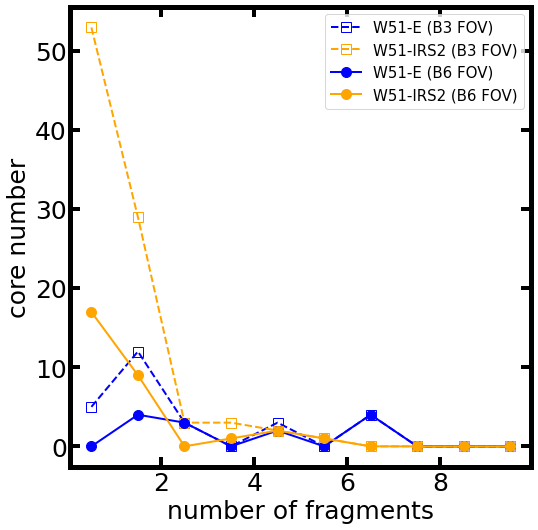

In [4]:
import matplotlib as mpl
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)

#fig = plt.figure(figsize=(24,8))
#ax1 = fig.add_axes([0.1,0.12,0.28,0.8])
#ax2 = fig.add_axes([0.43,0.12,0.28,0.8])
#ax3 = fig.add_axes([0.76,0.12,0.28,0.8])



hdrB6_w51e_almaimf = fits.getheader(Path.w51e_b6_almaimf)  
wcsB6_w51e_almaimf = WCS(hdrB6_w51e_almaimf,naxis=2)
beamb6_w51e_almaimf = Beam.from_fits_header(hdrB6_w51e_almaimf)  

hdrB3_w51e_almaimf = fits.getheader(Path.w51e_b3_almaimf)  
wcsB3_w51e_almaimf = WCS(hdrB3_w51e_almaimf,naxis=2)
beamb3_w51e_almaimf = Beam.from_fits_header(hdrB3_w51e_almaimf) 

hdrB6_w51n_almaimf = fits.getheader(Path.w51n_b6_almaimf)  
wcsB6_w51n_almaimf = WCS(hdrB6_w51n_almaimf,naxis=2)
beamb6_w51n_almaimf = Beam.from_fits_header(hdrB6_w51n_almaimf)  

hdrB3_w51n_almaimf = fits.getheader(Path.w51n_b3_almaimf)  
wcsB3_w51n_almaimf = WCS(hdrB3_w51n_almaimf,naxis=2)
beamb3_w51n_almaimf = Beam.from_fits_header(hdrB3_w51n_almaimf)  

fitsdata_b3 = fits.open(Path.w51e_b3_tt0)
image_b3_w51e = fitsdata_b3[0].data
if len(image_b3_w51e.shape)>2:
    image_b3_w51e = fitsdata_b3[0].data[0][0]
hdrB3_w51e_hr = fits.getheader(Path.w51e_b3_tt0)  
    
fitsdata_b3 = fits.open(Path.w51n_b3_tt0)
image_b3_w51n = fitsdata_b3[0].data
if len(image_b3_w51n.shape)>2:
    image_b3_w51n = fitsdata_b3[0].data[0][0]
hdrB3_w51n_hr = fits.getheader(Path.w51n_b3_tt0)  

fitsdata_b6 = fits.open(Path.w51e_b6_cont)
image_b6_w51e = fitsdata_b6[0].data
if len(image_b6_w51e.shape)>2:
    image_b6_w51e = fitsdata_b6[0].data[0][0]
hdrB6_w51e_hr = fits.getheader(Path.w51e_b6_cont)  
    
fitsdata_b6 = fits.open(Path.w51n_b6_cont)
image_b6_w51n = fitsdata_b6[0].data
if len(image_b6_w51n.shape)>2:
    image_b6_w51n = fitsdata_b6[0].data[0][0]
hdrB6_w51n_hr = fits.getheader(Path.w51n_b6_cont)  
    
catalog_w51e_yso = Table.read(Path.w51e_dendro_matched_catalog ,format='fits')
w51e_xsky_b6 = catalog_w51e_yso['b6_xsky'] ; w51e_ysky_b6 = catalog_w51e_yso['b6_ysky']
w51e_xsky_b3 = catalog_w51e_yso['b3_xsky'] ; w51e_ysky_b3 = catalog_w51e_yso['b3_ysky']

detect_w51e_b6 = np.where(w51e_xsky_b6>0)[0]
detect_w51e_b3 = np.where(w51e_xsky_b3>0)[0]


catalog_w51n_yso = Table.read(Path.w51n_dendro_matched_catalog ,format='fits')
w51n_xsky_b6 = catalog_w51n_yso['b6_xsky'] ; w51n_ysky_b6 = catalog_w51n_yso['b6_ysky']
w51n_xsky_b3 = catalog_w51n_yso['b3_xsky'] ; w51n_ysky_b3 = catalog_w51n_yso['b3_ysky']

detect_w51n_b6 = np.where(w51n_xsky_b6>0)[0]
detect_w51n_b3 = np.where(w51n_xsky_b3>0)[0]

catdata_w51e_b3 = catdata(Path.w51e_almaimf_catalog)
sky_ra_w51e_b3 = catdata_w51e_b3.sky_ra
sky_dec_w51e_b3 = catdata_w51e_b3.sky_dec
catdata_w51e_b6 = catdata(Path.w51e_almaimf_catalog, band='B6')
sky_ra_w51e_b6 = catdata_w51e_b6.sky_ra
sky_dec_w51e_b6 = catdata_w51e_b6.sky_dec
catdata_w51n_b3 = catdata(Path.w51n_almaimf_catalog)
sky_ra_w51n_b3 = catdata_w51n_b3.sky_ra
sky_dec_w51n_b3 = catdata_w51n_b3.sky_dec
catdata_w51n_b6 = catdata(Path.w51n_almaimf_catalog, band='B6')
sky_ra_w51n_b6 = catdata_w51n_b6.sky_ra
sky_dec_w51n_b6 = catdata_w51n_b6.sky_dec

freqb3=92982346121.91989*u.Hz
freqb6=226691598706.70853*u.Hz
kappa_b3 = kappa(freqb3)
kappa_b6 = kappa(freqb6)

temp_w51e = get_temperature(Path.w51e_almaimf_coretemp, sky_ra_w51e_b6,sky_dec_w51e_b6)
temp_w51n = get_temperature(Path.w51n_almaimf_coretemp,sky_ra_w51n_b6,sky_dec_w51n_b6)
print('temp',temp_w51e)
int_peak_w51e = catdata_w51e_b6.int_peak * u.Jy 
int_peak_w51n = catdata_w51n_b6.int_peak * u.Jy 
interr_peak_w51e = catdata_w51e_b6.interr_peak * u.Jy 
interr_peak_w51n = catdata_w51n_b6.interr_peak * u.Jy 
flux_int_w51e = catdata_w51e_b6.flux * u.Jy
flux_int_w51n = catdata_w51n_b6.flux * u.Jy
fluxerr_int_w51e = catdata_w51e_b6.fluxerr * u.Jy
fluxerr_int_w51n = catdata_w51n_b6.fluxerr * u.Jy

major_w51e = catdata_w51e_b6.afwhm*5.41*1000
minor_w51e = catdata_w51e_b6.bfwhm*5.41*1000

major_w51n = catdata_w51n_b6.afwhm*5.1*1000
minor_w51n = catdata_w51n_b6.bfwhm*5.1*1000

size_w51e = (major_w51e*minor_w51e**2)**(1/3)
size_w51n = (major_w51n*minor_w51n**2)**(1/3)

print(int_peak_w51e)

coremass_w51e = get_coremass(freqb6, kappa_b6, 5.41*u.kpc, int_peak_w51e, flux_int_w51e,temp_w51e*u.K)
coremass_w51n = get_coremass(freqb6, kappa_b6, 5.1*u.kpc, int_peak_w51n, flux_int_w51n,temp_w51n*u.K)
coremasserr_w51e=get_coremasserr(freqb6, kappa_b6, 5.41*u.kpc, int_peak_w51e, flux_int_w51e,interr_peak_w51e, fluxerr_int_w51e,temp_w51e*u.K)
coremasserr_w51n=get_coremasserr(freqb6, kappa_b6, 5.1*u.kpc, int_peak_w51n, flux_int_w51n,interr_peak_w51n, fluxerr_int_w51n,temp_w51n*u.K)
bemass_w51e = get_BEmass(major_w51e, minor_w51e,temp_w51e)
bemass_w51n = get_BEmass(major_w51n, minor_w51n,temp_w51n)
jeansmass_w51e = get_Jeansmass(temp_w51e, coremass_w51e.value, major_w51e, minor_w51e)
jeansmass_w51n = get_Jeansmass(temp_w51n, coremass_w51n.value, major_w51n, minor_w51n)

print('mass',coremass_w51e,coremass_w51n )
print('masserr',coremasserr_w51e,coremasserr_w51n )

# examine whether cores reside inside FOV of each high-resolution image
isinside_w51e_b3 = exist_inside_FOV(sky_ra_w51e_b6, sky_dec_w51e_b6, image_b3_w51e, hdrB3_w51e_hr)
isinside_w51e_b6 = exist_inside_FOV(sky_ra_w51e_b6, sky_dec_w51e_b6, image_b6_w51e, hdrB6_w51e_hr)
isinside_w51n_b3 = exist_inside_FOV(sky_ra_w51n_b6, sky_dec_w51n_b6, image_b3_w51n, hdrB3_w51n_hr)
isinside_w51n_b6 = exist_inside_FOV(sky_ra_w51n_b6, sky_dec_w51n_b6, image_b6_w51n, hdrB6_w51n_hr)
print(len(isinside_w51e_b6))
print(len(isinside_w51n_b6))
print(len(isinside_w51e_b3))
print(len(isinside_w51n_b3))
xsky_w51e = []
for i,x in enumerate(w51e_xsky_b6):
    if x > 0:
        xsky_w51e.append(x)
    else:
        xsky_w51e.append(w51e_xsky_b3[i])
ysky_w51e = []
for i,x in enumerate(w51e_ysky_b6):
    if x > 0:
        ysky_w51e.append(x)
    else:
        ysky_w51e.append(w51e_ysky_b3[i])

xsky_w51n = []
for i,x in enumerate(w51n_xsky_b6):
    if x > 0:
        xsky_w51n.append(x)
    else:
        xsky_w51n.append(w51n_xsky_b3[i])
ysky_w51n = []
for i,x in enumerate(w51n_ysky_b6):
    if x > 0:
        ysky_w51n.append(x)
    else:
        ysky_w51n.append(w51n_ysky_b3[i])


xysource_w51e= np.vstack((xsky_w51e, ysky_w51e)).T
xysource_w51n= np.vstack((xsky_w51n, ysky_w51n)).T

hdrhr_w51n_b3= fits.getheader(Path.w51n_b3_tt0) 
hdrhr_w51e_b3= fits.getheader(Path.w51e_b3_tt0) 

# index is for cores so we don't need to do for b6 fov 
# because some YSOs outside B6 FOV but also inside B3 FOV are considered not to be asssociated with cores
numarr_w51e_b3fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b3  )[4]
numarr_w51n_b3fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b3  )[4]
numarr_w51e_b6fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b6  )[4]
numarr_w51n_b6fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b6  )[4]


isinside_w51e_b3_woff = np.intersect1d(isinside_w51e_b3,  catdata_w51e_b3.woffind)
isinside_w51n_b3_woff = np.intersect1d(isinside_w51n_b3,  catdata_w51n_b3.woffind)
isinside_w51e_b6_woff = np.intersect1d(isinside_w51e_b6,  catdata_w51e_b6.woffind)
isinside_w51n_b6_woff = np.intersect1d(isinside_w51n_b6,  catdata_w51n_b6.woffind)

numarr_w51e_b3fov_woff = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b3_woff  )[4]
numarr_w51n_b3fov_woff = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b3_woff )[4]
numarr_w51e_b6fov_woff = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b6_woff  )[4]
numarr_w51n_b6fov_woff = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b6_woff  )[4]

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.15,0.15,0.8,0.8])
bins = np.arange(11)

hist_w51e_b3fov = np.histogram(numarr_w51e_b3fov, bins=bins)[0]
hist_w51n_b3fov = np.histogram(numarr_w51n_b3fov, bins=bins)[0]
hist_w51e_b6fov = np.histogram(numarr_w51e_b6fov, bins=bins)[0]
hist_w51n_b6fov = np.histogram(numarr_w51n_b6fov, bins=bins)[0]
print(hist_w51e_b3fov,hist_w51n_b3fov,hist_w51e_b6fov,hist_w51n_b6fov)
bins2 = (bins[:-1]+bins[1:])/2
ax1.plot(bins2, hist_w51e_b3fov, lw=2, ls='dashed', c='b', label='W51-E (B3 FOV)',marker='s',mec='b',mfc='none',markersize=10)
ax1.plot(bins2, hist_w51n_b3fov, lw=2, ls='dashed', c='orange', label='W51-IRS2 (B3 FOV)',marker='s',mec='orange',mfc='none',markersize=10)
ax1.plot(bins2, hist_w51e_b6fov, lw=2, ls='solid', c='b', label='W51-E (B6 FOV)',marker='o',markersize=10)
ax1.plot(bins2, hist_w51n_b6fov, lw=2, ls='solid', c='orange', label='W51-IRS2 (B6 FOV)',marker='o',markersize=10)


"""
ax1.hist(numarr_w51e_b3fov, bins = bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E (B3 FOV)',lw=4)
ax1.hist(numarr_w51n_b3fov, bins = bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 (B3 FOV)',lw=4)
ax1.hist(numarr_w51e_b6fov, bins=bins, alpha=0.5, color='cyan', label='W51-E (B6 FOV)',lw=4)
ax1.hist(numarr_w51n_b6fov, bins=bins, alpha=0.5, color='peru', label='W51-IRS2 (B6 FOV)',lw=4)
"""
ax1.set_xlabel('number of fragments')
ax1.set_ylabel('core number')
ax1.legend(fontsize=15)
plt.savefig('frag_count.pdf')

ind_w51e_b3fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b3  )[2]
ind_w51n_b3fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b3  )[2]
ind_w51e_b6fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b6  )[2]
ind_w51n_b6fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b6  )[2]
print('ho',ind_w51e_b3fov)
isin_w51e_b3fov = [i in ind_w51e_b3fov for i in range(len(w51e_xsky_b3))]
isin_w51n_b3fov = [i in ind_w51n_b3fov for i in range(len(w51n_xsky_b3))]
isin_w51e_b6fov = [i in ind_w51e_b3fov for i in range(len(w51e_xsky_b6))]
isin_w51n_b6fov = [i in ind_w51n_b3fov for i in range(len(w51n_xsky_b6))]
print('ho',isin_w51e_b3fov)


#catalog_w51e_yso['isincore_b3fov'] = isin_w51e_b3fov
#catalog_w51e_yso['isincore_b6fov'] = isin_w51e_b6fov
#catalog_w51n_yso['isincore_b3fov'] = isin_w51n_b3fov
#catalog_w51n_yso['isincore_b6fov'] = isin_w51n_b6fov
#catalog_w51e_yso.write(w51e_matched_catalog, overwrite=True)
#catalog_w51n_yso.write(w51n_matched_catalog, overwrite=True)







[ 5 12  3  0  3  0  4  0  0  0] [53 29  3  3  2  1  0  0  0  0]
[1 8 3 0 2 0 4 0 0 0] [29 21  3  2  2  0  0  0  0  0]


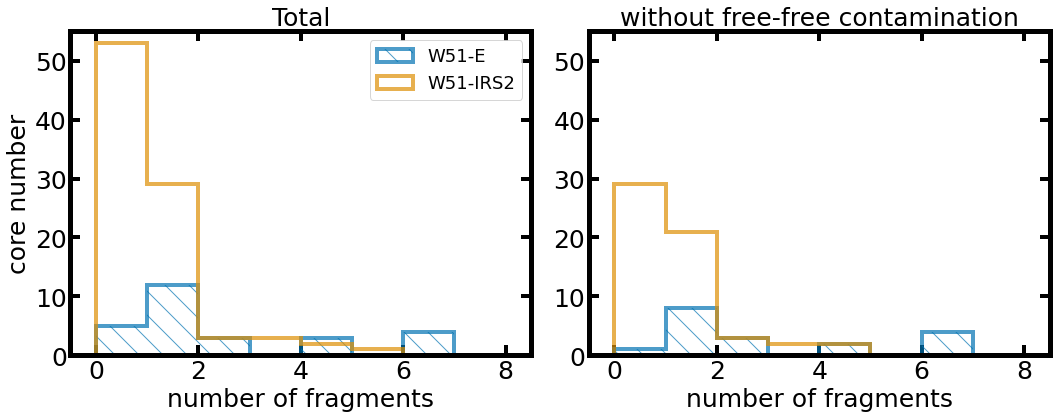

In [5]:
import seaborn as sns
cmap = sns.color_palette("colorblind")

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_axes([0.1,0.17,0.4,0.75])
ax2 = fig.add_axes([0.55,0.17,0.4,0.75])

#ax1.hist(numarr_w51e_b3fov, bins = bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E',lw=4,alpha=0.8)
#ax1.hist(numarr_w51n_b3fov, bins = bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2',lw=4,alpha=0.8)
ax1.hist(numarr_w51e_b3fov, bins=bins, alpha=0.7, color=cmap[0], label='W51-E',lw=4, histtype='step',hatch='\\')
ax1.hist(numarr_w51n_b3fov, bins=bins, alpha=0.7, color=cmap[1], label='W51-IRS2',lw=4, histtype='step')
ax2.hist(numarr_w51e_b3fov_woff, bins=bins, alpha=0.7, color=cmap[0], label='W51-E',lw=4, histtype='step',hatch='\\')
ax2.hist(numarr_w51n_b3fov_woff, bins=bins, alpha=0.7, color=cmap[1], label='W51-IRS2',lw=4, histtype='step')
print(np.histogram(numarr_w51e_b3fov,bins=bins)[0],np.histogram(numarr_w51n_b3fov,bins=bins)[0])
print(np.histogram(numarr_w51e_b3fov_woff,bins=bins)[0],np.histogram(numarr_w51n_b3fov_woff,bins=bins)[0])

ax1.set_xlabel('number of fragments')
ax2.set_xlabel('number of fragments')

ax1.set_ylabel('core number')
ax1.set_title('Total')
ax2.set_title('without free-free contamination')
ax1.legend(fontsize=18)
ax1.set_ylim(0,55)
ax2.set_ylim(0,55)
ax1.set_xlim(-0.5,8.5)
ax2.set_xlim(-0.5,8.5)

plt.savefig('frag_count.pdf')


### core flux vs number of fragments

highresindarr [41, 40, 134, 29, 30, 31, 32, 33, 34, 46, 48, 50, 51, 54, 56, 52, 55, 58, 59, 60, 61, 8, 9, 10, 85, 120, 37, 102, 1, 2, 3, 83, 53, 57, 45, 47, 19, 20, 22, 23, 24, 90, 70, 71, 82, 123, 119, 65, 117, 118, 127, 35, 129, 132]
highresindarr2 [[41], [40], [134], [29, 30, 31, 32, 33, 34], [46, 48, 50, 51, 54, 56], [], [52, 55, 58, 59, 60, 61], [8, 9, 10, 85], [120], [37, 102], [1, 2, 3, 83], [53, 57], [45, 47], [19, 20, 22, 23, 24, 90], [70, 71, 82, 123], [119], [65], [], [117], [118], [], [127], [35], [129], [132], [], []]
[  1   2   3   8   9  10  19  20  22  23  24  29  30  31  32  33  34  35
  37  40  41  45  46  47  48  50  51  52  53  54  55  56  57  58  59  60
  61  65  70  71  82  83  85  90 102 117 118 119 120 123 127 129 132 134]
YSOs associated with cores 54  out of  137
highresindarr [10, 11, 13, 24, 9, 61, 44, 45, 3, 6, 7, 23, 29, 19, 20, 30, 31, 4, 8, 14, 66, 42, 48, 49, 65, 33, 34, 36, 37, 38, 67, 25, 0, 41, 35, 57, 60, 5, 28, 50, 68, 39, 32, 40, 70, 71, 72, 46, 2

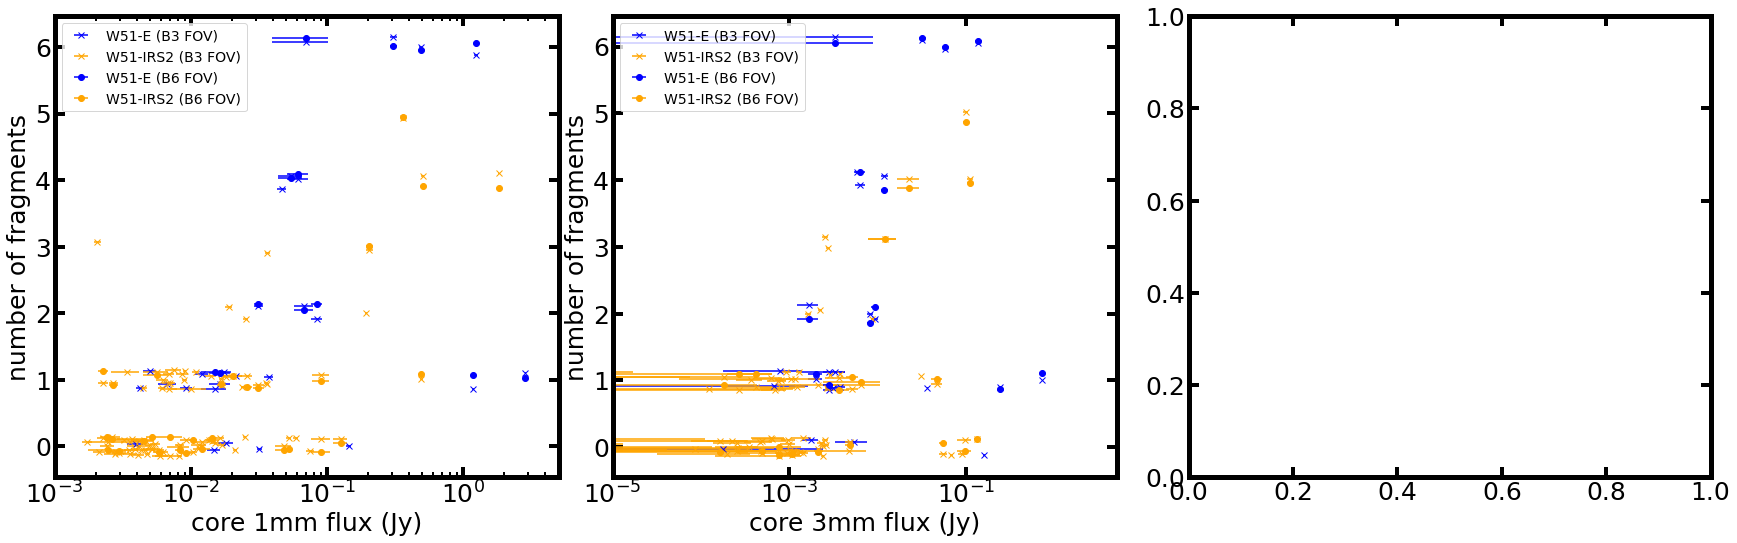

In [6]:
fig = plt.figure(figsize=(25,8))
ax1 = fig.add_axes([0.08,0.15,0.28,0.8])
ax2 = fig.add_axes([0.39,0.15,0.28,0.8])
ax3 = fig.add_axes([0.71,0.15,0.29,0.8])
multiplicity_w51e_b3fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b3  )
multiplicity_w51n_b3fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b3  )
multiplicity_w51e_b6fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b6  )
multiplicity_w51n_b6fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b6  )


w51e_b3fov_b6flux = [catdata_w51e_b6.flux[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6flux = [catdata_w51n_b6.flux[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3flux = [catdata_w51e_b3.flux[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3flux = [catdata_w51n_b3.flux[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]    
print(w51e_b3fov_b6flux, multiplicity_w51e_b3fov[4])    
w51e_b6fov_b6flux = [catdata_w51e_b6.flux[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b6flux = [catdata_w51n_b6.flux[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]
w51e_b6fov_b3flux = [catdata_w51e_b3.flux[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b3flux = [catdata_w51n_b3.flux[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]  

w51e_b3fov_b6fluxerr = [catdata_w51e_b6.fluxerr[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6fluxerr = [catdata_w51n_b6.fluxerr[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3fluxerr = [catdata_w51e_b3.fluxerr[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3fluxerr = [catdata_w51n_b3.fluxerr[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]    
    
w51e_b6fov_b6fluxerr = [catdata_w51e_b6.fluxerr[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b6fluxerr = [catdata_w51n_b6.fluxerr[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]
w51e_b6fov_b3fluxerr = [catdata_w51e_b3.fluxerr[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b3fluxerr = [catdata_w51n_b3.fluxerr[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]  


ax1.errorbar(w51e_b3fov_b6flux, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15, xerr=w51e_b3fov_b6fluxerr,  c='b',  label='W51-E (B3 FOV)', fmt='x')
ax1.errorbar(w51n_b3fov_b6flux, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15, xerr=w51n_b3fov_b6fluxerr, c='orange',  label='W51-IRS2 (B3 FOV)', fmt='x')
ax1.errorbar(w51e_b6fov_b6flux, multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15, xerr=w51e_b6fov_b6fluxerr, c='b', label='W51-E (B6 FOV)', fmt='o')
ax1.errorbar(w51n_b6fov_b6flux, multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15, xerr=w51n_b6fov_b6fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o')

ax2.errorbar(w51e_b3fov_b3flux, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15, xerr=w51e_b3fov_b3fluxerr, c='b',  label='W51-E (B3 FOV)', fmt='x')
ax2.errorbar(w51n_b3fov_b3flux, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15, xerr=w51n_b3fov_b3fluxerr, c='orange',  label='W51-IRS2 (B3 FOV)', fmt='x')
ax2.errorbar(w51e_b6fov_b3flux, multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15, xerr=w51e_b6fov_b3fluxerr, c='b',  label='W51-E (B6 FOV)', fmt='o')
ax2.errorbar(w51n_b6fov_b3flux, multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15, xerr=w51n_b6fov_b3fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o')


ax1.set_xlabel('core 1mm flux (Jy)')
ax2.set_xlabel('core 3mm flux (Jy)')
ax1.set_ylabel('number of fragments')
ax2.set_ylabel('number of fragments')
ax1.legend(fontsize=14)
ax2.legend(fontsize=14)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim(1e-3,5)
ax2.set_xlim(1e-5,5)
plt.savefig('flux_frag.pdf')

highresindarr [40, 29, 30, 31, 32, 33, 34, 46, 48, 50, 51, 54, 56, 52, 55, 58, 59, 60, 61, 120, 37, 102, 1, 2, 3, 83, 53, 57, 45, 47, 19, 20, 22, 23, 24, 90, 70, 71, 82, 123, 65, 118, 127, 35, 129, 132]
highresindarr2 [[40], [29, 30, 31, 32, 33, 34], [46, 48, 50, 51, 54, 56], [52, 55, 58, 59, 60, 61], [120], [37, 102], [1, 2, 3, 83], [53, 57], [45, 47], [19, 20, 22, 23, 24, 90], [70, 71, 82, 123], [65], [], [118], [127], [35], [129], [132]]
[  1   2   3  19  20  22  23  24  29  30  31  32  33  34  35  37  40  45
  46  47  48  50  51  52  53  54  55  56  57  58  59  60  61  65  70  71
  82  83  90 102 118 120 123 127 129 132]
YSOs associated with cores 46  out of  137
highresindarr [10, 11, 13, 24, 9, 44, 45, 19, 20, 30, 31, 4, 8, 14, 66, 42, 48, 49, 65, 33, 34, 36, 37, 38, 67, 25, 0, 41, 57, 5, 50, 39, 32, 40, 46, 21, 64, 59, 69, 63, 22]
highresindarr2 [[10, 11, 13, 24], [9], [44, 45], [19, 20, 30, 31], [4, 8, 14], [66], [42], [48, 49], [], [65], [33, 34], [36, 37, 38], [], [67], [], [

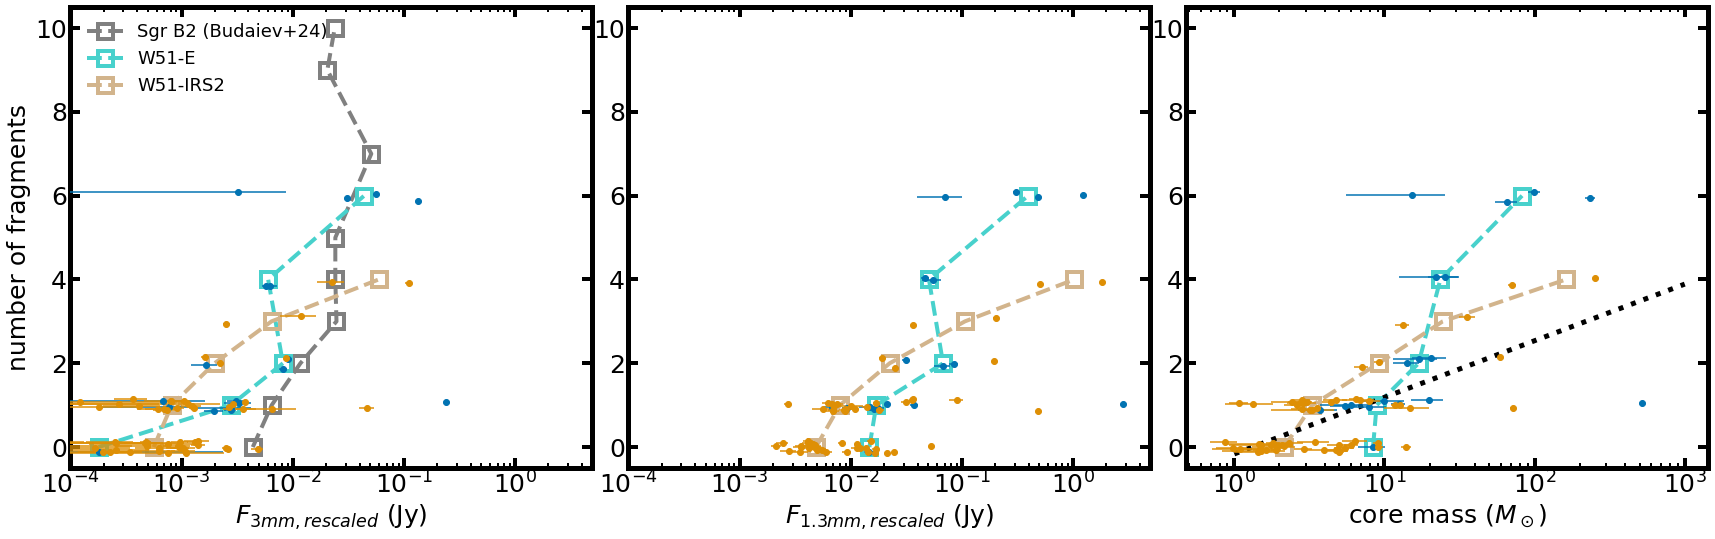

In [7]:
from scipy.optimize import curve_fit

def linear(x,a,b):
    return x*a+b
fig = plt.figure(figsize=(25,8))
ax2 = fig.add_axes([0.07,0.15,0.29,0.8])
ax1 = fig.add_axes([0.38,0.15,0.29,0.8])
ax3 = fig.add_axes([0.69,0.15,0.29,0.8])
multiplicity_w51e_b3fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b3_woff  )
multiplicity_w51n_b3fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b3_woff  )
multiplicity_w51e_b6fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b6_woff  )
multiplicity_w51n_b6fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b6_woff  )


w51e_b3fov_b6flux = [catdata_w51e_b6.flux[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6flux = [catdata_w51n_b6.flux[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3flux = [catdata_w51e_b3.flux[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3flux = [catdata_w51n_b3.flux[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]    
print(w51e_b3fov_b6flux, multiplicity_w51e_b3fov[4])    
w51e_b6fov_b6flux = [catdata_w51e_b6.flux[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b6flux = [catdata_w51n_b6.flux[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]
w51e_b6fov_b3flux = [catdata_w51e_b3.flux[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b3flux = [catdata_w51n_b3.flux[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]  

w51e_b3fov_b6fluxerr = [catdata_w51e_b6.fluxerr[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6fluxerr = [catdata_w51n_b6.fluxerr[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3fluxerr = [catdata_w51e_b3.fluxerr[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3fluxerr = [catdata_w51n_b3.fluxerr[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]    
    
w51e_b6fov_b6fluxerr = [catdata_w51e_b6.fluxerr[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b6fluxerr = [catdata_w51n_b6.fluxerr[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]
w51e_b6fov_b3fluxerr = [catdata_w51e_b3.fluxerr[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b3fluxerr = [catdata_w51n_b3.fluxerr[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]  

coremass_w51e_selected = np.array([coremass_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
coremass_w51n_selected = np.array([coremass_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
coremasserr_w51e_selected = np.array([coremasserr_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
coremasserr_w51n_selected = np.array([coremasserr_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])

temp_w51e_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]] for ind in multiplicity_w51e_b3fov[3]])
temp_w51n_selected = np.array([temp_w51n[np.where(catdata_w51n_b6.no==ind)[0]] for ind in multiplicity_w51n_b3fov[3]])


bemass_w51e_selected = np.array([bemass_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
bemass_w51n_selected = np.array([bemass_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
jeansmass_w51e_selected = np.array([jeansmass_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
jeansmass_w51n_selected = np.array([jeansmass_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])


ax1.errorbar( w51e_b3fov_b6flux, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15,xerr=w51e_b3fov_b6fluxerr,  c=cmap[0], fmt='o',zorder=50)
ax1.errorbar(w51n_b3fov_b6flux,  multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,xerr=w51n_b3fov_b6fluxerr, c=cmap[1],  fmt='o',zorder=50)
#ax1.errorbar( multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15, w51e_b6fov_b6flux,yerr=w51e_b6fov_b6fluxerr, c='b', label='W51-E (B6 FOV)', fmt='o',zorder=50)
#ax1.errorbar(multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15, w51n_b6fov_b6flux, yerr=w51n_b6fov_b6fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o',zorder=50)

ax2.errorbar(w51e_b3fov_b3flux,  multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15,xerr=w51e_b3fov_b3fluxerr, c=cmap[0],  fmt='o',zorder=50)
ax2.errorbar( w51n_b3fov_b3flux, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,xerr=w51n_b3fov_b3fluxerr, c=cmap[1],   fmt='o',zorder=50)

ax3.errorbar(coremass_w51e_selected, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15,xerr=coremasserr_w51e_selected, c=cmap[0],  fmt='o',zorder=50)
ax3.errorbar(coremass_w51n_selected, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,xerr=coremasserr_w51n_selected, c=cmap[1],   fmt='o',zorder=50)
#ax2.errorbar(multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15,w51e_b6fov_b3flux,  yerr=w51e_b6fov_b3fluxerr, c='b',  label='W51-E (B6 FOV)', fmt='o',zorder=50)
#ax2.errorbar(multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15,w51n_b6fov_b3flux,  yerr=w51n_b6fov_b3fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o',zorder=50)
xarr = np.arange(10)
median_w51e_b3fov_b6flux = np.array([np.nanmedian(np.array(w51e_b3fov_b6flux)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51e_b6fov_b6flux = np.array([np.nanmedian(np.array(w51e_b6fov_b6flux)[np.where(multiplicity_w51e_b6fov[4]==i)]) for i in xarr])
median_w51n_b3fov_b6flux = np.array([np.nanmedian(np.array(w51n_b3fov_b6flux)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#median_w51n_b6fov_b6flux = np.array([np.nanmedian(np.array(w51n_b6fov_b6flux)[np.where(multiplicity_w51n_b6fov[4]==i)]) for i in xarr])

median_w51e_b3fov_b3flux = np.array([np.nanmedian(np.array(w51e_b3fov_b3flux)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51e_b6fov_b3flux = np.array([np.nanmedian(np.array(w51e_b6fov_b3flux)[np.where(multiplicity_w51e_b6fov[4]==i)]) for i in xarr])
median_w51n_b3fov_b3flux = np.array([np.nanmedian(np.array(w51n_b3fov_b3flux)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#median_w51n_b6fov_b3flux = np.array([np.nanmedian(np.array(w51n_b6fov_b3flux)[np.where(multiplicity_w51n_b6fov[4]==i)]) for i in xarr])

median_w51e_mass = np.array([np.nanmedian(np.array(coremass_w51e_selected)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
median_w51n_mass = np.array([np.nanmedian(np.array(coremass_w51n_selected)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])


occurances_lowres = [10,  9,  7,  5,  5,  5,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,
        3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lowres_flux = np.array([0.01059128, 0.00909196, 0.02260418, 0.06354622, 0.01073138,
       0.00907187, 0.01514028, 0.01298016, 0.0121241 , 0.0093319 ,
       0.00752502, 0.00507354, 0.04531774, 0.01804966, 0.01133546,
       0.01064564, 0.00771095, 0.00751052, 0.0919993 , 0.06882451,
       0.02418834, 0.00998853, 0.00849448, 0.00624354, 0.00603234,
       0.00553882, 0.00486414, 0.00470662, 0.00348881, 0.00348881,
       0.00209246, 0.00189364, 0.00170339, 0.00133012, 0.01273668,
       0.0123312 , 0.01032122, 0.00919014, 0.00690729, 0.00689153,
       0.00661672, 0.00623315, 0.00558779, 0.00552865, 0.0049822 ,
       0.00488167, 0.00384736, 0.00349865, 0.00336652, 0.00332265,
       0.00319572, 0.00298395, 0.00296533, 0.00292376, 0.00292221,
       0.00281395, 0.00277322, 0.00274509, 0.002736  , 0.00255715,
       0.00253562, 0.00249509, 0.00231837, 0.00220659, 0.00219206,
       0.00197808, 0.00192051, 0.00181068, 0.00169148, 0.00165056,
       0.0014714 , 0.00144944, 0.00136348, 0.0012477 , 0.00113799,
       0.00109437,0.00176712,0.00209246,0.00311928,0.00269714,0.00207316,0.00175978,
                            0.00368528,0.00193705,0.00133012,0.00146678, 0.0008578,0.00411188,
                            0.00181958, 0.0019389,0.0019389,0.00385688])
                   

xarr2 = np.unique(occurances_lowres)

medarr = np.zeros(len(xarr2))
for i,x in enumerate(xarr2):
    ind = np.where(occurances_lowres==x)
    medarr[i] = np.median(lowres_flux[ind])
ax1.plot(median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], xarr[np.isfinite(median_w51e_b3fov_b6flux)],marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(xarr[np.isfinite(median_w51e_b3fov_b6flux)], median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], marker='s',  mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='solid', c='mediumturquoise', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)
ax1.plot(median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)]*(5.1/5.41)**2,xarr[np.isfinite(median_w51n_b3fov_b6flux)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')
#ax1.plot(xarr[np.isfinite(median_w51n_b3fov_b6flux)], median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax1.plot(xarr[np.isfinite(median_w51n_b6fov_b6flux)], median_w51n_b6fov_b6flux[np.isfinite(median_w51n_b6fov_b6flux)], marker='s', mew=4,mec='tan', mfc='none',ls='solid', c='tan', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51n_b6fov_b6flux)], median_w51n_b6fov_b6flux[np.isfinite(median_w51n_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)

ax2.plot(medarr*(8.13/5.41)**2, xarr2, marker='s', mew=4,mec='gray', mfc='none',ls='dashed', c='gray', lw=4 ,markersize=15, label='Sgr B2 (Budaiev+24)')

ax2.plot(median_w51e_b3fov_b3flux[np.isfinite(median_w51e_b3fov_b3flux)], xarr[np.isfinite(median_w51e_b3fov_b3flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(xarr[np.isfinite(median_w51e_b3fov_b6flux)], median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], marker='s',  mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax2.plot(xarr[np.isfinite(median_w51e_b6fov_b3flux)], median_w51e_b6fov_b3flux[np.isfinite(median_w51e_b6fov_b3flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='solid', c='mediumturquoise', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)
ax2.plot(median_w51n_b3fov_b3flux[np.isfinite(median_w51n_b3fov_b3flux)]*(5.1/5.41)**2,xarr[np.isfinite(median_w51n_b3fov_b3flux)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')
#ax1.plot(xarr[np.isfinite(median_w51n_b3fov_b6flux)], median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax2.plot(xarr[np.isfinite(median_w51n_b6fov_b3flux)], median_w51n_b6fov_b3flux[np.isfinite(median_w51n_b6fov_b3flux)], marker='s', mew=4,mec='tan', mfc='none',ls='solid', c='tan', lw=4,markersize=15)


ax3.plot(median_w51e_mass[np.isfinite(median_w51e_mass)], xarr[np.isfinite(median_w51e_mass)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
ax3.plot(median_w51n_mass[np.isfinite(median_w51n_mass)], xarr[np.isfinite(median_w51n_mass)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')


popt, pcov = curve_fit(linear, np.log10(coremass_w51n_selected), multiplicity_w51n_b3fov[4])

print(popt, pcov)
xarr = np.linspace(0,3,100)
ax3.plot(10**xarr, linear(xarr,*popt), ls='dotted', c='k',lw=5)

ax1.set_xlabel('$F_{1.3mm, rescaled}$ (Jy)')
ax2.set_xlabel('$F_{3mm, rescaled}$ (Jy)')
ax3.set_xlabel(r'core mass ($M_\odot$)')
ax2.set_ylabel('number of fragments')
#ax2.set_ylabel('number of fragments')
ax2.legend(fontsize=18, frameon=False, loc='upper left')
#ax2.legend(fontsize=18,loc='upper left')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_xlim(1e-4,5)
ax2.set_xlim(1e-4,5)
ax1.set_ylim(-0.5, 10.5)
ax2.set_ylim(-0.5, 10.5)
ax3.set_ylim(-0.5, 10.5)

plt.savefig('frag_coreflux.png')

highresindarr [40, 29, 30, 31, 32, 33, 34, 46, 48, 50, 51, 54, 56, 52, 55, 58, 59, 60, 61, 120, 37, 102, 1, 2, 3, 83, 53, 57, 45, 47, 19, 20, 22, 23, 24, 90, 70, 71, 82, 123, 65, 118, 127, 35, 129, 132]
highresindarr2 [[40], [29, 30, 31, 32, 33, 34], [46, 48, 50, 51, 54, 56], [52, 55, 58, 59, 60, 61], [120], [37, 102], [1, 2, 3, 83], [53, 57], [45, 47], [19, 20, 22, 23, 24, 90], [70, 71, 82, 123], [65], [], [118], [127], [35], [129], [132]]
[  1   2   3  19  20  22  23  24  29  30  31  32  33  34  35  37  40  45
  46  47  48  50  51  52  53  54  55  56  57  58  59  60  61  65  70  71
  82  83  90 102 118 120 123 127 129 132]
YSOs associated with cores 46  out of  137
highresindarr [10, 11, 13, 24, 9, 44, 45, 19, 20, 30, 31, 4, 8, 14, 66, 42, 48, 49, 65, 33, 34, 36, 37, 38, 67, 25, 0, 41, 57, 5, 50, 39, 32, 40, 46, 21, 64, 59, 69, 63, 22]
highresindarr2 [[10, 11, 13, 24], [9], [44, 45], [19, 20, 30, 31], [4, 8, 14], [66], [42], [48, 49], [], [65], [33, 34], [36, 37, 38], [], [67], [], [

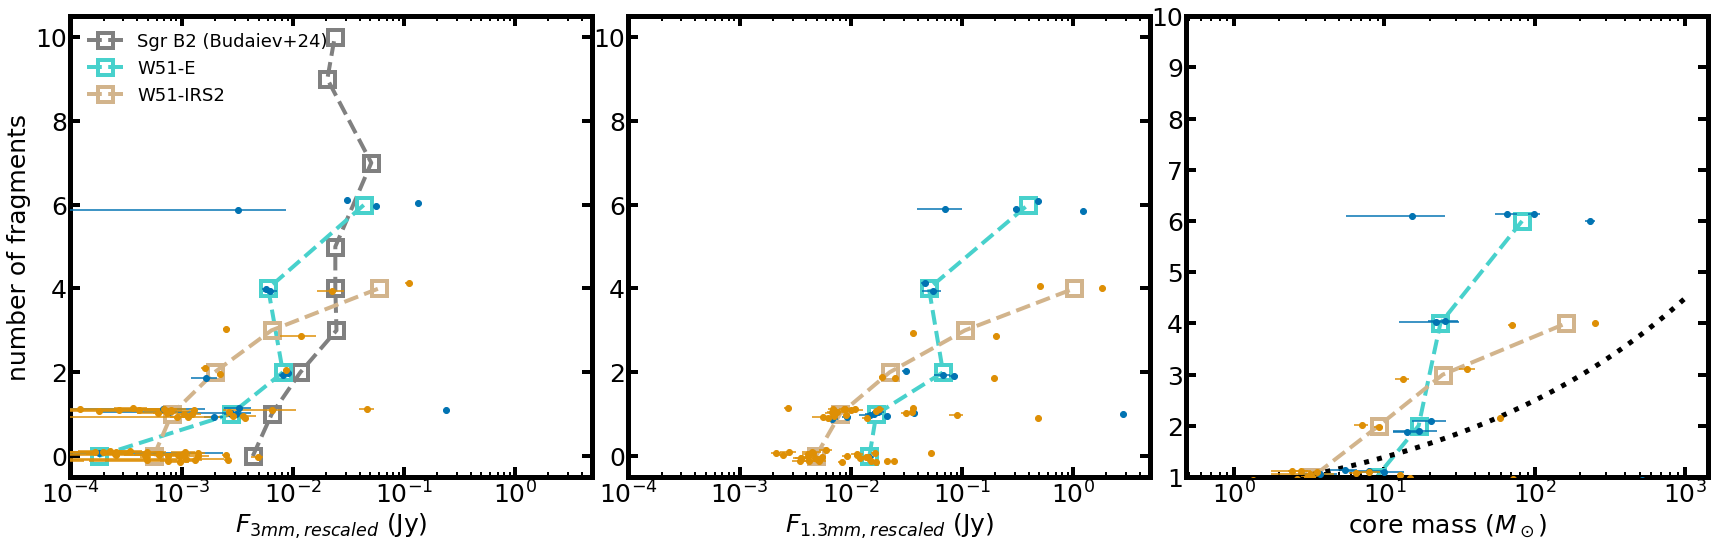

In [8]:
from scipy.optimize import curve_fit

def linear(x,a,b):
    return x*a+b
fig = plt.figure(figsize=(25,8))
ax2 = fig.add_axes([0.07,0.15,0.29,0.8])
ax1 = fig.add_axes([0.38,0.15,0.29,0.8])
ax3 = fig.add_axes([0.69,0.15,0.29,0.8])
multiplicity_w51e_b3fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b3_woff  )
multiplicity_w51n_b3fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b3_woff  )
multiplicity_w51e_b6fov = multiplicity(hdrhr_w51e_b3,Path.w51e_almaimf_catalog,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b6_woff  )
multiplicity_w51n_b6fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b6_woff  )


w51e_b3fov_b6flux = [catdata_w51e_b6.flux[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6flux = [catdata_w51n_b6.flux[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3flux = [catdata_w51e_b3.flux[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3flux = [catdata_w51n_b3.flux[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]    
print(w51e_b3fov_b6flux, multiplicity_w51e_b3fov[4])    
w51e_b6fov_b6flux = [catdata_w51e_b6.flux[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b6flux = [catdata_w51n_b6.flux[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]
w51e_b6fov_b3flux = [catdata_w51e_b3.flux[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b3flux = [catdata_w51n_b3.flux[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]  

w51e_b3fov_b6fluxerr = [catdata_w51e_b6.fluxerr[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6fluxerr = [catdata_w51n_b6.fluxerr[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3fluxerr = [catdata_w51e_b3.fluxerr[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3fluxerr = [catdata_w51n_b3.fluxerr[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]    
    
w51e_b6fov_b6fluxerr = [catdata_w51e_b6.fluxerr[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b6fluxerr = [catdata_w51n_b6.fluxerr[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]
w51e_b6fov_b3fluxerr = [catdata_w51e_b3.fluxerr[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b6fov[3]]
w51n_b6fov_b3fluxerr = [catdata_w51n_b3.fluxerr[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b6fov[3]]  

coremass_w51e_selected = np.array([coremass_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
coremass_w51n_selected = np.array([coremass_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
coremasserr_w51e_selected = np.array([coremasserr_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
coremasserr_w51n_selected = np.array([coremasserr_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])

temp_w51e_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]] for ind in multiplicity_w51e_b3fov[3]])
temp_w51n_selected = np.array([temp_w51n[np.where(catdata_w51n_b6.no==ind)[0]] for ind in multiplicity_w51n_b3fov[3]])


bemass_w51e_selected = np.array([bemass_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
bemass_w51n_selected = np.array([bemass_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
jeansmass_w51e_selected = np.array([jeansmass_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
jeansmass_w51n_selected = np.array([jeansmass_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])


ax1.errorbar( w51e_b3fov_b6flux, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15,xerr=w51e_b3fov_b6fluxerr,  c=cmap[0], fmt='o',zorder=50)
ax1.errorbar(w51n_b3fov_b6flux,  multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,xerr=w51n_b3fov_b6fluxerr, c=cmap[1],  fmt='o',zorder=50)
#ax1.errorbar( multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15, w51e_b6fov_b6flux,yerr=w51e_b6fov_b6fluxerr, c='b', label='W51-E (B6 FOV)', fmt='o',zorder=50)
#ax1.errorbar(multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15, w51n_b6fov_b6flux, yerr=w51n_b6fov_b6fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o',zorder=50)

ax2.errorbar(w51e_b3fov_b3flux,  multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15,xerr=w51e_b3fov_b3fluxerr, c=cmap[0],  fmt='o',zorder=50)
ax2.errorbar( w51n_b3fov_b3flux, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,xerr=w51n_b3fov_b3fluxerr, c=cmap[1],   fmt='o',zorder=50)

ax3.errorbar(coremass_w51e_selected, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15,xerr=coremasserr_w51e_selected, c=cmap[0],  fmt='o',zorder=50)
ax3.errorbar(coremass_w51n_selected, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,xerr=coremasserr_w51n_selected, c=cmap[1],   fmt='o',zorder=50)
#ax2.errorbar(multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15,w51e_b6fov_b3flux,  yerr=w51e_b6fov_b3fluxerr, c='b',  label='W51-E (B6 FOV)', fmt='o',zorder=50)
#ax2.errorbar(multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15,w51n_b6fov_b3flux,  yerr=w51n_b6fov_b3fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o',zorder=50)
xarr = np.arange(10)
median_w51e_b3fov_b6flux = np.array([np.nanmedian(np.array(w51e_b3fov_b6flux)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51e_b6fov_b6flux = np.array([np.nanmedian(np.array(w51e_b6fov_b6flux)[np.where(multiplicity_w51e_b6fov[4]==i)]) for i in xarr])
median_w51n_b3fov_b6flux = np.array([np.nanmedian(np.array(w51n_b3fov_b6flux)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#median_w51n_b6fov_b6flux = np.array([np.nanmedian(np.array(w51n_b6fov_b6flux)[np.where(multiplicity_w51n_b6fov[4]==i)]) for i in xarr])

median_w51e_b3fov_b3flux = np.array([np.nanmedian(np.array(w51e_b3fov_b3flux)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51e_b6fov_b3flux = np.array([np.nanmedian(np.array(w51e_b6fov_b3flux)[np.where(multiplicity_w51e_b6fov[4]==i)]) for i in xarr])
median_w51n_b3fov_b3flux = np.array([np.nanmedian(np.array(w51n_b3fov_b3flux)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#median_w51n_b6fov_b3flux = np.array([np.nanmedian(np.array(w51n_b6fov_b3flux)[np.where(multiplicity_w51n_b6fov[4]==i)]) for i in xarr])

median_w51e_mass = np.array([np.nanmedian(np.array(coremass_w51e_selected)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
median_w51n_mass = np.array([np.nanmedian(np.array(coremass_w51n_selected)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])


occurances_lowres = [10,  9,  7,  5,  5,  5,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,
        3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lowres_flux = np.array([0.01059128, 0.00909196, 0.02260418, 0.06354622, 0.01073138,
       0.00907187, 0.01514028, 0.01298016, 0.0121241 , 0.0093319 ,
       0.00752502, 0.00507354, 0.04531774, 0.01804966, 0.01133546,
       0.01064564, 0.00771095, 0.00751052, 0.0919993 , 0.06882451,
       0.02418834, 0.00998853, 0.00849448, 0.00624354, 0.00603234,
       0.00553882, 0.00486414, 0.00470662, 0.00348881, 0.00348881,
       0.00209246, 0.00189364, 0.00170339, 0.00133012, 0.01273668,
       0.0123312 , 0.01032122, 0.00919014, 0.00690729, 0.00689153,
       0.00661672, 0.00623315, 0.00558779, 0.00552865, 0.0049822 ,
       0.00488167, 0.00384736, 0.00349865, 0.00336652, 0.00332265,
       0.00319572, 0.00298395, 0.00296533, 0.00292376, 0.00292221,
       0.00281395, 0.00277322, 0.00274509, 0.002736  , 0.00255715,
       0.00253562, 0.00249509, 0.00231837, 0.00220659, 0.00219206,
       0.00197808, 0.00192051, 0.00181068, 0.00169148, 0.00165056,
       0.0014714 , 0.00144944, 0.00136348, 0.0012477 , 0.00113799,
       0.00109437,0.00176712,0.00209246,0.00311928,0.00269714,0.00207316,0.00175978,
                            0.00368528,0.00193705,0.00133012,0.00146678, 0.0008578,0.00411188,
                            0.00181958, 0.0019389,0.0019389,0.00385688])
                   

xarr2 = np.unique(occurances_lowres)

medarr = np.zeros(len(xarr2))
for i,x in enumerate(xarr2):
    ind = np.where(occurances_lowres==x)
    medarr[i] = np.median(lowres_flux[ind])
ax1.plot(median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], xarr[np.isfinite(median_w51e_b3fov_b6flux)],marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(xarr[np.isfinite(median_w51e_b3fov_b6flux)], median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], marker='s',  mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='solid', c='mediumturquoise', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)
ax1.plot(median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)]*(5.1/5.41)**2,xarr[np.isfinite(median_w51n_b3fov_b6flux)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')
#ax1.plot(xarr[np.isfinite(median_w51n_b3fov_b6flux)], median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax1.plot(xarr[np.isfinite(median_w51n_b6fov_b6flux)], median_w51n_b6fov_b6flux[np.isfinite(median_w51n_b6fov_b6flux)], marker='s', mew=4,mec='tan', mfc='none',ls='solid', c='tan', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51n_b6fov_b6flux)], median_w51n_b6fov_b6flux[np.isfinite(median_w51n_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)

ax2.plot(medarr*(8.13/5.41)**2, xarr2, marker='s', mew=4,mec='gray', mfc='none',ls='dashed', c='gray', lw=4 ,markersize=15, label='Sgr B2 (Budaiev+24)')

ax2.plot(median_w51e_b3fov_b3flux[np.isfinite(median_w51e_b3fov_b3flux)], xarr[np.isfinite(median_w51e_b3fov_b3flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(xarr[np.isfinite(median_w51e_b3fov_b6flux)], median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], marker='s',  mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax2.plot(xarr[np.isfinite(median_w51e_b6fov_b3flux)], median_w51e_b6fov_b3flux[np.isfinite(median_w51e_b6fov_b3flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='solid', c='mediumturquoise', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)
ax2.plot(median_w51n_b3fov_b3flux[np.isfinite(median_w51n_b3fov_b3flux)]*(5.1/5.41)**2,xarr[np.isfinite(median_w51n_b3fov_b3flux)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')
#ax1.plot(xarr[np.isfinite(median_w51n_b3fov_b6flux)], median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax2.plot(xarr[np.isfinite(median_w51n_b6fov_b3flux)], median_w51n_b6fov_b3flux[np.isfinite(median_w51n_b6fov_b3flux)], marker='s', mew=4,mec='tan', mfc='none',ls='solid', c='tan', lw=4,markersize=15)


ax3.plot(median_w51e_mass[np.isfinite(median_w51e_mass)], xarr[np.isfinite(median_w51e_mass)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
ax3.plot(median_w51n_mass[np.isfinite(median_w51n_mass)], xarr[np.isfinite(median_w51n_mass)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')

nonzeroind = np.where(np.array(multiplicity_w51n_b3fov[4])>0)[0]
print('ho',nonzeroind)
print(multiplicity_w51n_b3fov[4])
print('ho',np.array(multiplicity_w51n_b3fov[4])[nonzeroind])
popt, pcov = curve_fit(linear, np.log10(coremass_w51n_selected[nonzeroind]), np.log10(np.array(multiplicity_w51n_b3fov[4])[nonzeroind]))

print(popt, pcov)
xarr = np.logspace(0,3,100)
ax3.plot(xarr, 10**linear(np.log10(xarr),*popt), ls='dotted', c='k',lw=5)

ax1.set_xlabel('$F_{1.3mm, rescaled}$ (Jy)')
ax2.set_xlabel('$F_{3mm, rescaled}$ (Jy)')
ax3.set_xlabel(r'core mass ($M_\odot$)')
ax2.set_ylabel('number of fragments')
#ax2.set_ylabel('number of fragments')
ax2.legend(fontsize=18, frameon=False, loc='upper left')
#ax2.legend(fontsize=18,loc='upper left')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_xlim(1e-4,5)
ax2.set_xlim(1e-4,5)
ax1.set_ylim(-0.5, 10.5)
ax2.set_ylim(-0.5, 10.5)
ax3.set_ylim(-0.5, 10.5)
ax3.set_ylim(1,10)
#ax3.set_yscale('log')

plt.savefig('frag_coreflux2.png')




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


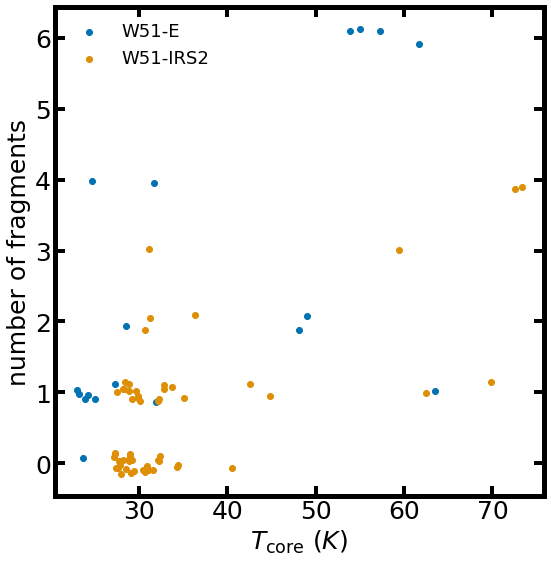

In [9]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1,0.1,0.85,0.85])

ax1.scatter( temp_w51e_selected, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15,  c=cmap[0],zorder=50, label='W51-E')
ax1.scatter( temp_w51n_selected, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,  c=cmap[1], zorder=50, label='W51-IRS2')

ax1.set_xlabel(r'$T_{\rm core}$ $(K)$')
ax1.set_ylabel('number of fragments')
ax1.legend(fontsize=18,frameon=False)


### the most massive YSO flux vs core flux

0       flux_b6      
         Jy        
-------------------
0.06496462767716864 0 0.06496462767716864
1        flux_b6       
          Jy         
---------------------
 0.005144975856236045
 0.010210946745762138
0.0065745273896672864
  0.03714995285611901
  0.02832844662181555
 0.003448190037524163 3 0.03714995285611901
2       flux_b6       
         Jy         
--------------------
 0.01277785448617972
 0.04351679899883891
0.009810804087771147
0.006258011567881795
0.005238167413378553
0.003436114213059235 1 0.04351679899883891
3       flux_b6       
         Jy         
--------------------
0.012529997250230894
0.004488638770076018
0.007716231125060911
0.019256143294264432
  0.0055740521460461
0.008231959571351337 3 0.019256143294264432
4 flux_b6
   Jy  
-------
     -- 0 nan
5       flux_b6       
         Jy         
--------------------
0.011432290071008846
0.004213474826758595 0 0.011432290071008846
6        flux_b6       
          Jy         
---------------------
 0.005781

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

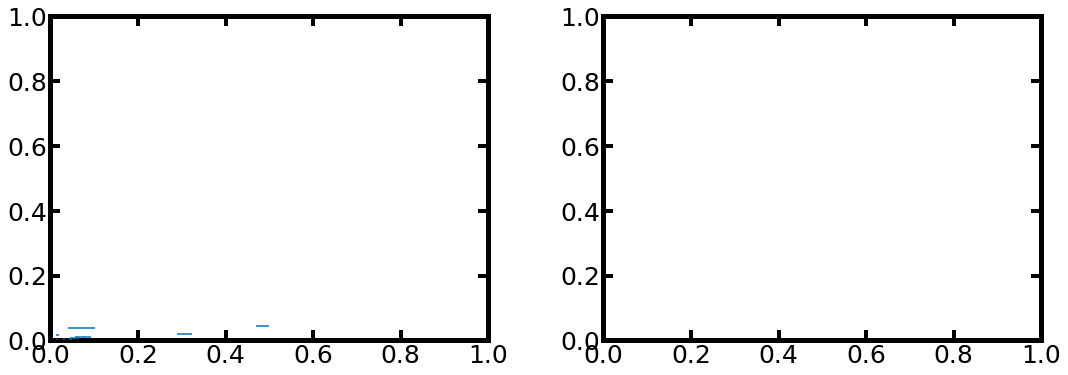

In [10]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_axes([0.1,0.17,0.38,0.75])
ax2 = fig.add_axes([0.58,0.17,0.38,0.75])
#multiplicity_w51e_b3fov = multiplicity(hdrhr_w51e_b3,cat_w51e,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b3_woff  )
#multiplicity_w51n_b3fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b3_woff  )

#multiplicity_w51e_b6fov = multiplicity(hdrhr_w51e_b3,cat_w51e,xysource_w51e,isb3=False,beam=beamb6_w51e_almaimf,label=isinside_w51e_b6  )
#multiplicity_w51n_b6fov = multiplicity(hdrhr_w51n_b3,Path.w51n_almaimf_catalog,xysource_w51n,isb3=False,beam=beamb6_w51n_almaimf,label=isinside_w51n_b6  )

# index of YSOs 
ysoind_w51e = multiplicity_w51e_b3fov[5]
ysoind_w51n = multiplicity_w51n_b3fov[5]

ysoflux_b6_w51e = catalog_w51e_yso['flux_b6']
ysoflux_b3_w51e = catalog_w51e_yso['flux_b3']
ysoflux_b6_w51n = catalog_w51n_yso['flux_b6']
ysoflux_b3_w51n = catalog_w51n_yso['flux_b3']

ysoflux_upperr_b6_w51e = catalog_w51e_yso['flux_upperr_b6'] - catalog_w51e_yso['flux_b6']
ysoflux_lowerr_b6_w51e = catalog_w51e_yso['flux_b6'] - catalog_w51e_yso['flux_lowerr_b6']

ysoflux_upperr_b3_w51e = catalog_w51e_yso['flux_upperr_b3'] - catalog_w51e_yso['flux_b3']
ysoflux_lowerr_b3_w51e = catalog_w51e_yso['flux_b3'] - catalog_w51e_yso['flux_lowerr_b3']

ysoflux_upperr_b6_w51n = catalog_w51n_yso['flux_upperr_b6'] - catalog_w51n_yso['flux_b6']
ysoflux_lowerr_b6_w51n = catalog_w51n_yso['flux_b6'] - catalog_w51n_yso['flux_lowerr_b6']

ysoflux_upperr_b3_w51n = catalog_w51n_yso['flux_upperr_b3'] - catalog_w51n_yso['flux_b3']
ysoflux_lowerr_b3_w51n = catalog_w51n_yso['flux_b3'] - catalog_w51n_yso['flux_lowerr_b3']


yso_constTmass_w51e = catalog_w51e_yso['constT_mass']
yso_MBBTmass_w51e = catalog_w51e_yso['MBBT_mass']
yso_constTmass_w51n = catalog_w51n_yso['constT_mass']
yso_MBBTmass_w51n = catalog_w51n_yso['MBBT_mass']

yso_constTmass_upperr_w51e = catalog_w51e_yso['constT_mass_upperr'] - catalog_w51e_yso['constT_mass']
yso_constTmass_lowerr_w51e = catalog_w51e_yso['constT_mass'] - catalog_w51e_yso['constT_mass_lowerr']

yso_constTmass_upperr_w51n = catalog_w51n_yso['constT_mass_upperr'] - catalog_w51n_yso['constT_mass']
yso_constTmass_lowerr_w51n = catalog_w51n_yso['constT_mass'] - catalog_w51n_yso['constT_mass_lowerr']

yso_MBBTmass_upperr_w51e = catalog_w51e_yso['MBBT_mass_upperr'] - catalog_w51e_yso['MBBT_mass']
yso_MBBTmass_lowerr_w51e = catalog_w51e_yso['MBBT_mass'] - catalog_w51e_yso['MBBT_mass_lowerr']

yso_MBBTmass_upperr_w51n = catalog_w51n_yso['MBBT_mass_upperr'] - catalog_w51n_yso['MBBT_mass']
yso_MBBTmass_lowerr_w51n = catalog_w51n_yso['MBBT_mass'] - catalog_w51n_yso['MBBT_mass_lowerr']


ysoflux_b6_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
ysoflux_b3_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
ysoflux_b6_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
ysoflux_b3_w51n_arr = np.ones(len(ysoind_w51n))*(-999)

ysoflux_upperr_b6_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
ysoflux_upperr_b3_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
ysoflux_upperr_b6_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
ysoflux_upperr_b3_w51n_arr = np.ones(len(ysoind_w51n))*(-999)

ysoflux_lowerr_b6_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
ysoflux_lowerr_b3_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
ysoflux_lowerr_b6_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
ysoflux_lowerr_b3_w51n_arr = np.ones(len(ysoind_w51n))*(-999)

yso_constTmass_w51e_max_arr =np.ones(len(ysoind_w51e))*(-999)
yso_MBBTmass_w51e_max_arr = np.ones(len(ysoind_w51e))*(-999)
yso_constTmass_w51n_max_arr= np.ones(len(ysoind_w51n))*(-999)
yso_MBBTmass_w51n_max_arr = np.ones(len(ysoind_w51n))*(-999)

yso_constTmass_upperr_w51e_max_arr = np.ones(len(ysoind_w51e))*(-999)
yso_constTmass_lowerr_w51e_max_arr = np.ones(len(ysoind_w51e))*(-999)
yso_constTmass_upperr_w51n_max_arr = np.ones(len(ysoind_w51n))*(-999)
yso_constTmass_lowerr_w51n_max_arr = np.ones(len(ysoind_w51n))*(-999)

yso_MBBTmass_upperr_w51e_max_arr = np.ones(len(ysoind_w51e))*(-999)
yso_MBBTmass_lowerr_w51e_max_arr =np.ones(len(ysoind_w51e))*(-999)
yso_MBBTmass_upperr_w51n_max_arr = np.ones(len(ysoind_w51n))*(-999)
yso_MBBTmass_lowerr_w51n_max_arr = np.ones(len(ysoind_w51n))*(-999)


yso_constTmass_w51e_sum_arr =np.ones(len(ysoind_w51e))*(-999)
yso_MBBTmass_w51e_sum_arr = np.ones(len(ysoind_w51e))*(-999)
yso_constTmass_w51n_sum_arr= np.ones(len(ysoind_w51n))*(-999)
yso_MBBTmass_w51n_sum_arr = np.ones(len(ysoind_w51n))*(-999)

yso_constTmass_upperr_w51e_sum_arr = np.ones(len(ysoind_w51e))*(-999)
yso_constTmass_lowerr_w51e_sum_arr = np.ones(len(ysoind_w51e))*(-999)
yso_constTmass_upperr_w51n_sum_arr = np.ones(len(ysoind_w51n))*(-999)
yso_constTmass_lowerr_w51n_sum_arr = np.ones(len(ysoind_w51n))*(-999)

yso_MBBTmass_upperr_w51e_sum_arr = np.ones(len(ysoind_w51e))*(-999)
yso_MBBTmass_lowerr_w51e_sum_arr =np.ones(len(ysoind_w51e))*(-999)
yso_MBBTmass_upperr_w51n_sum_arr = np.ones(len(ysoind_w51n))*(-999)
yso_MBBTmass_lowerr_w51n_sum_arr = np.ones(len(ysoind_w51n))*(-999)

iscomplete_mass_constT_w51e_arr = np.ones(len(ysoind_w51e),dtype=bool)
iscomplete_mass_constT_w51n_arr = np.ones(len(ysoind_w51n),dtype=bool)
iscomplete_mass_MBBT_w51e_arr = np.ones(len(ysoind_w51e),dtype=bool)
iscomplete_mass_MBBT_w51n_arr = np.ones(len(ysoind_w51n),dtype=bool)

sum_mass_constT_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
sum_mass_constT_upperr_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
sum_mass_constT_lowerr_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
sum_mass_MBBT_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
sum_mass_MBBT_upperr_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
sum_mass_MBBT_lowerr_w51e_arr = np.ones(len(ysoind_w51e))*(-999)

sum_mass_constT_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
sum_mass_constT_upperr_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
sum_mass_constT_lowerr_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
sum_mass_MBBT_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
sum_mass_MBBT_upperr_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
sum_mass_MBBT_lowerr_w51n_arr = np.ones(len(ysoind_w51n))*(-999)

sum_flux_b6_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
sum_flux_upperr_b6_w51e_arr = np.ones(len(ysoind_w51e))*(-999)
sum_flux_lowerr_b6_w51e_arr = np.ones(len(ysoind_w51e))*(-999)

sum_flux_b3_w51e_arr =  np.ones(len(ysoind_w51e))*(-999)
sum_flux_upperr_b3_w51e_arr =  np.ones(len(ysoind_w51e))*(-999)
sum_flux_lowerr_b3_w51e_arr =  np.ones(len(ysoind_w51e))*(-999)


sum_flux_b6_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
sum_flux_upperr_b6_w51n_arr = np.ones(len(ysoind_w51n))*(-999)
sum_flux_lowerr_b6_w51n_arr = np.ones(len(ysoind_w51n))*(-999)

sum_flux_b3_w51n_arr =  np.ones(len(ysoind_w51n))*(-999)
sum_flux_upperr_b3_w51n_arr =  np.ones(len(ysoind_w51n))*(-999)
sum_flux_lowerr_b3_w51n_arr =  np.ones(len(ysoind_w51n))*(-999)

for i, ysoind in enumerate(ysoind_w51e):
    if len(ysoind)>0:
        b6maxfluxind = np.nanargmax(ysoflux_b6_w51e[ysoind])
        b3maxfluxind = np.nanargmax(ysoflux_b3_w51e[ysoind])
        ysoflux_b6_w51e_arr[i] = ysoflux_b6_w51e[ysoind][b6maxfluxind]
        ysoflux_b3_w51e_arr[i] = ysoflux_b3_w51e[ysoind][b3maxfluxind]
        ysoflux_upperr_b6_w51e_arr[i] = ysoflux_upperr_b6_w51e[ysoind][b6maxfluxind]
        ysoflux_upperr_b3_w51e_arr[i] = ysoflux_upperr_b3_w51e[ysoind][b3maxfluxind]
        ysoflux_lowerr_b6_w51e_arr[i] = ysoflux_lowerr_b6_w51e[ysoind][b6maxfluxind]
        ysoflux_lowerr_b3_w51e_arr[i] = ysoflux_lowerr_b3_w51e[ysoind][b3maxfluxind]
        print(i, ysoflux_b6_w51e[ysoind], b6maxfluxind ,ysoflux_b6_w51e_arr[i])

        ysoind_finite = [k for k in ysoind if str(k)!='nan']

        sum_flux_b6_w51e_arr[i] = np.sum(ysoflux_b6_w51e[ysoind_finite][ysoflux_b6_w51e[ysoind_finite]>0])
        sum_flux_upperr_b6_w51e_arr[i] = np.sum(ysoflux_upperr_b6_w51e[ysoind_finite][ysoflux_upperr_b6_w51e[ysoind_finite]>0])
        sum_flux_lowerr_b6_w51e_arr[i] = np.sum(ysoflux_lowerr_b6_w51e[ysoind_finite][ysoflux_lowerr_b6_w51e[ysoind_finite]>0])

        sum_flux_b3_w51e_arr[i] = np.sum(ysoflux_b3_w51e[ysoind_finite][ysoflux_b3_w51e[ysoind_finite]>0])
        sum_flux_upperr_b3_w51e_arr[i] = np.sum(ysoflux_upperr_b3_w51e[ysoind_finite][ysoflux_upperr_b3_w51e[ysoind_finite]>0])
        sum_flux_lowerr_b3_w51e_arr[i] = np.sum(ysoflux_lowerr_b3_w51e[ysoind_finite][ysoflux_lowerr_b3_w51e[ysoind_finite]>0])
            
        if any(yso_constTmass_w51e[ysoind]>0):
            
            
            max_mass_constT_ind = np.nanargmax(yso_constTmass_w51e[ysoind_finite])
            yso_constTmass_w51e_max_arr[i] = yso_constTmass_w51e[ysoind_finite][max_mass_constT_ind]
            yso_constTmass_upperr_w51e_max_arr[i] = yso_constTmass_upperr_w51e[ysoind_finite][max_mass_constT_ind]
            yso_constTmass_lowerr_w51e_max_arr[i] = yso_constTmass_lowerr_w51e[ysoind_finite][max_mass_constT_ind]
            
            
            
            sum_mass_constT_w51e_arr[i] = np.sum(yso_constTmass_w51e[ysoind_finite][yso_constTmass_w51e[ysoind_finite]>0])
            sum_mass_constT_upperr_w51e_arr[i] = np.sqrt(np.sum((yso_constTmass_upperr_w51e[ysoind_finite][yso_constTmass_upperr_w51e[ysoind_finite]>0])**2))
            sum_mass_constT_lowerr_w51e_arr[i] = np.sqrt(np.sum((yso_constTmass_lowerr_w51e[ysoind_finite][yso_constTmass_lowerr_w51e[ysoind_finite]>0])**2))
            #print(i,yso_constTmass_w51e[yso_constTmass_w51e>0] )

            if any(yso_constTmass_w51e[ysoind_finite]<0):
                iscomplete_mass_constT_w51e_arr[i] = False


        if any(yso_MBBTmass_w51e[ysoind]>0):
            
            

            max_mass_MBBT_ind = np.nanargmax(yso_MBBTmass_w51e[ysoind_finite])
            yso_MBBTmass_w51e_max_arr[i] = yso_MBBTmass_w51e[ysoind_finite][max_mass_MBBT_ind]
            yso_MBBTmass_upperr_w51e_max_arr[i] = yso_MBBTmass_upperr_w51e[ysoind_finite][max_mass_MBBT_ind]
            yso_MBBTmass_lowerr_w51e_max_arr[i] = yso_MBBTmass_lowerr_w51e[ysoind_finite][max_mass_MBBT_ind]
            sum_mass_MBBT_w51e_arr[i] = np.sum(yso_MBBTmass_w51e[ysoind_finite][yso_MBBTmass_w51e[ysoind_finite]>0])
            sum_mass_MBBT_upperr_w51e_arr[i] = np.sqrt(np.sum((yso_MBBTmass_upperr_w51e[ysoind_finite][yso_MBBTmass_upperr_w51e[ysoind_finite]>0])**2))
            sum_mass_MBBT_lowerr_w51e_arr[i] = np.sqrt(np.sum((yso_MBBTmass_lowerr_w51e[ysoind_finite][yso_MBBTmass_lowerr_w51e[ysoind_finite]>0])**2))
            
            if any(yso_MBBTmass_w51e[ysoind_finite]<0):
                iscomplete_mass_MBBT_w51e_arr[i] = False



for i, ysoind in enumerate(ysoind_w51n):
    if len(ysoind)>0:
        b6maxfluxind = np.argmax(ysoflux_b6_w51n[ysoind])
        b3maxfluxind = np.argmax(ysoflux_b3_w51n[ysoind])
        ysoflux_b6_w51n_arr[i] = ysoflux_b6_w51n[ysoind][b6maxfluxind]
        ysoflux_b3_w51n_arr[i] = ysoflux_b3_w51n[ysoind][b3maxfluxind]
        ysoflux_upperr_b6_w51n_arr[i] = ysoflux_upperr_b6_w51n[ysoind][b6maxfluxind]
        ysoflux_upperr_b3_w51n_arr[i] = ysoflux_upperr_b3_w51n[ysoind][b3maxfluxind]
        ysoflux_lowerr_b6_w51n_arr[i] = ysoflux_lowerr_b6_w51n[ysoind][b6maxfluxind]
        ysoflux_lowerr_b3_w51n_arr[i] = ysoflux_lowerr_b3_w51n[ysoind][b3maxfluxind]
        
        ysoind_finite = [k for k in ysoind if str(k)!='nan']
        
        
        sum_flux_b6_w51n_arr[i] = np.sum(ysoflux_b6_w51n[ysoind_finite][ysoflux_b6_w51n[ysoind_finite]>0])
        sum_flux_upperr_b6_w51n_arr[i] = np.sum(ysoflux_upperr_b6_w51n[ysoind_finite][ysoflux_upperr_b6_w51n[ysoind_finite]>0])
        sum_flux_lowerr_b6_w51n_arr[i] = np.sum(ysoflux_lowerr_b6_w51n[ysoind_finite][ysoflux_lowerr_b6_w51n[ysoind_finite]>0])

        sum_flux_b3_w51n_arr[i] = np.sum(ysoflux_b3_w51n[ysoind_finite][ysoflux_b3_w51n[ysoind_finite]>0])
        sum_flux_upperr_b3_w51n_arr[i] = np.sum(ysoflux_upperr_b3_w51n[ysoind_finite][ysoflux_upperr_b3_w51n[ysoind_finite]>0])
        sum_flux_lowerr_b3_w51n_arr[i] = np.sum(ysoflux_lowerr_b3_w51n[ysoind_finite][ysoflux_lowerr_b3_w51n[ysoind_finite]>0])
            

        if any(yso_constTmass_w51n[ysoind]>0):
            max_mass_constT_ind = np.argmax(yso_constTmass_w51n[ysoind_finite])
            yso_constTmass_w51n_max_arr[i] = yso_constTmass_w51n[ysoind_finite][max_mass_constT_ind]
            yso_constTmass_upperr_w51n_max_arr[i] = yso_constTmass_upperr_w51n[ysoind_finite][max_mass_constT_ind]
            yso_constTmass_lowerr_w51n_max_arr[i] = yso_constTmass_lowerr_w51n[ysoind_finite][max_mass_constT_ind]
            sum_mass_constT_w51n_arr[i] = np.sum(yso_constTmass_w51n[ysoind_finite][yso_constTmass_w51n[ysoind_finite]>0])
            sum_mass_constT_upperr_w51n_arr[i] = np.sqrt(np.sum((yso_constTmass_upperr_w51n[ysoind_finite][yso_constTmass_upperr_w51n[ysoind_finite]>0])**2))
            sum_mass_constT_lowerr_w51n_arr[i] = np.sqrt(np.sum((yso_constTmass_lowerr_w51n[ysoind_finite][yso_constTmass_lowerr_w51n[ysoind_finite]>0])**2))

            if any(yso_constTmass_w51n[ysoind_finite]<0):
                iscomplete_mass_constT_w51n_arr[i] = False
                #print(i,ysoind,ysoind_finite)
                #print(len(ysoind),len(ysoind_finite))


        if any(yso_MBBTmass_w51n[ysoind]>0):

            max_mass_MBBT_ind = np.argmax(yso_MBBTmass_w51n[ysoind_finite])
            yso_MBBTmass_w51n_max_arr[i] = yso_MBBTmass_w51n[ysoind_finite][max_mass_MBBT_ind]
            yso_MBBTmass_upperr_w51n_max_arr[i] = yso_MBBTmass_upperr_w51n[ysoind_finite][max_mass_MBBT_ind]
            yso_MBBTmass_lowerr_w51n_max_arr[i] = yso_MBBTmass_lowerr_w51n[ysoind_finite][max_mass_MBBT_ind]
            sum_mass_MBBT_w51n_arr[i] = np.sum(yso_MBBTmass_w51n[ysoind_finite][yso_MBBTmass_w51n[ysoind_finite]>0])
            sum_mass_MBBT_upperr_w51n_arr[i] = np.sqrt(np.sum((yso_MBBTmass_upperr_w51n[ysoind_finite][yso_MBBTmass_upperr_w51n[ysoind_finite]>0])**2))
            sum_mass_MBBT_lowerr_w51n_arr[i] = np.sqrt(np.sum((yso_MBBTmass_lowerr_w51n[ysoind_finite][yso_MBBTmass_lowerr_w51n[ysoind_finite]>0])**2))
            
            if any(yso_MBBTmass_w51n[ysoind_finite]<0):
                iscomplete_mass_MBBT_w51n_arr[i] = True
               # print(i, yso_MBBTmass_w51n[ysoind], iscomplete_mass_MBBT_w51n_arr[i])
              
        
ysofluxerr_b6_w51e = np.array(list(zip(ysoflux_lowerr_b6_w51e_arr, ysoflux_upperr_b6_w51e_arr))).T   
ysofluxerr_b3_w51e = np.array(list(zip(ysoflux_lowerr_b3_w51e_arr, ysoflux_upperr_b3_w51e_arr))).T    
ysofluxerr_b6_w51n = np.array(list(zip(ysoflux_lowerr_b6_w51n_arr, ysoflux_upperr_b6_w51n_arr))).T    
ysofluxerr_b3_w51n = np.array(list(zip(ysoflux_lowerr_b3_w51n_arr, ysoflux_upperr_b3_w51n_arr))).T    

ysofluxerr_b6_w51e = np.array(list(zip(ysoflux_lowerr_b6_w51e_arr, ysoflux_upperr_b6_w51e_arr))).T   
ysofluxerr_b3_w51e = np.array(list(zip(ysoflux_lowerr_b3_w51e_arr, ysoflux_upperr_b3_w51e_arr))).T    
ysofluxerr_b6_w51n = np.array(list(zip(ysoflux_lowerr_b6_w51n_arr, ysoflux_upperr_b6_w51n_arr))).T    
ysofluxerr_b3_w51n = np.array(list(zip(ysoflux_lowerr_b3_w51n_arr, ysoflux_upperr_b3_w51n_arr))).T  



 

w51e_selected_ind_constT_complete = np.where((yso_constTmass_w51e_max_arr>0)&(iscomplete_mass_constT_w51e_arr))[0]
w51e_selected_ind_constT_nocomplete = np.where((yso_constTmass_w51e_max_arr>0)&(~iscomplete_mass_constT_w51e_arr))[0]

w51n_selected_ind_constT_complete = np.where((yso_constTmass_w51n_max_arr>0)&(iscomplete_mass_constT_w51n_arr))[0]
w51n_selected_ind_constT_nocomplete = np.where((yso_constTmass_w51n_max_arr>0)&(~iscomplete_mass_constT_w51n_arr))[0]

w51e_selected_ind_MBBT_complete = np.where((yso_constTmass_w51e_max_arr>0)&(iscomplete_mass_MBBT_w51e_arr))[0]
w51e_selected_ind_MBBT_nocomplete = np.where((yso_constTmass_w51e_max_arr>0)&(~iscomplete_mass_MBBT_w51e_arr))[0]

w51n_selected_ind_MBBT_complete = np.where((yso_constTmass_w51n_max_arr>0)&(iscomplete_mass_MBBT_w51n_arr))[0]
w51n_selected_ind_MBBT_nocomplete = np.where((yso_constTmass_w51n_max_arr>0)&(~iscomplete_mass_MBBT_w51n_arr))[0]


sum_flux_err_b6_w51e = np.array(list(zip(sum_flux_lowerr_b6_w51e_arr, sum_flux_upperr_b6_w51e_arr))).T
sum_flux_err_b3_w51e = np.array(list(zip(sum_flux_lowerr_b3_w51e_arr, sum_flux_upperr_b3_w51e_arr))).T
sum_flux_err_b6_w51n = np.array(list(zip(sum_flux_lowerr_b6_w51n_arr, sum_flux_upperr_b6_w51n_arr))).T
sum_flux_err_b3_w51n = np.array(list(zip(sum_flux_lowerr_b3_w51n_arr, sum_flux_upperr_b3_w51n_arr))).T

sum_mass_constT_w51e_err_complete = np.array(list(zip(sum_mass_constT_lowerr_w51e_arr[w51e_selected_ind_constT_complete], 
                                                      sum_mass_constT_upperr_w51e_arr[w51e_selected_ind_constT_complete]))).T   
sum_mass_MBBT_w51e_err_complete = np.array(list(zip(sum_mass_MBBT_lowerr_w51e_arr[w51e_selected_ind_MBBT_complete], 
                                                    sum_mass_MBBT_upperr_w51e_arr[w51e_selected_ind_MBBT_complete]))).T    
sum_mass_constT_w51n_err_complete = np.array(list(zip(sum_mass_constT_lowerr_w51n_arr[w51n_selected_ind_constT_complete],
                                                       sum_mass_constT_upperr_w51n_arr[w51n_selected_ind_constT_complete]))).T   
sum_mass_MBBT_w51n_err_complete = np.array(list(zip(sum_mass_MBBT_lowerr_w51n_arr[w51n_selected_ind_MBBT_complete],
                                                    sum_mass_MBBT_upperr_w51n_arr[w51n_selected_ind_MBBT_complete]))).T  
sum_mass_constT_w51e_err_nocomplete = np.array(list(zip(sum_mass_constT_lowerr_w51e_arr[w51e_selected_ind_constT_nocomplete], 
                                                      sum_mass_constT_upperr_w51e_arr[w51e_selected_ind_constT_nocomplete]))).T   
sum_mass_MBBT_w51e_err_nocomplete = np.array(list(zip(sum_mass_MBBT_lowerr_w51e_arr[w51e_selected_ind_MBBT_nocomplete], 
                                                    sum_mass_MBBT_upperr_w51e_arr[w51e_selected_ind_MBBT_nocomplete]))).T    
sum_mass_constT_w51n_err_nocomplete = np.array(list(zip(sum_mass_constT_lowerr_w51n_arr[w51n_selected_ind_constT_nocomplete],
                                                       sum_mass_constT_upperr_w51n_arr[w51n_selected_ind_constT_nocomplete]))).T   
sum_mass_MBBT_w51n_err_nocomplete = np.array(list(zip(sum_mass_MBBT_lowerr_w51n_arr[w51n_selected_ind_MBBT_nocomplete],
                                                    sum_mass_MBBT_upperr_w51n_arr[w51n_selected_ind_MBBT_nocomplete]))).T  


yso_constTmass_w51e_max_err_constT_complete = np.array(list(zip(yso_constTmass_lowerr_w51e_max_arr[w51e_selected_ind_constT_complete], 
                                                yso_constTmass_upperr_w51e_max_arr[w51e_selected_ind_constT_complete]))).T  
yso_constTmass_w51e_max_err_constT_nocomplete = np.array(list(zip(yso_constTmass_lowerr_w51e_max_arr[w51e_selected_ind_constT_nocomplete], 
                                                yso_constTmass_upperr_w51e_max_arr[w51e_selected_ind_constT_nocomplete]))).T  

yso_MBBTmass_w51e_max_err_MBBT_complete = np.array(list(zip(yso_MBBTmass_lowerr_w51e_max_arr[w51e_selected_ind_MBBT_complete], 
                                                yso_MBBTmass_upperr_w51e_max_arr[w51e_selected_ind_MBBT_complete]))).T
yso_MBBTmass_w51e_max_err_MBBT_nocomplete = np.array(list(zip(yso_MBBTmass_lowerr_w51e_max_arr[w51e_selected_ind_MBBT_nocomplete], 
                                                yso_MBBTmass_upperr_w51e_max_arr[w51e_selected_ind_MBBT_nocomplete]))).T    

yso_constTmass_w51n_max_err_constT_complete = np.array(list(zip(yso_constTmass_lowerr_w51n_max_arr[w51n_selected_ind_constT_complete], 
                                                yso_constTmass_upperr_w51n_max_arr[w51n_selected_ind_constT_complete]))).T  
yso_constTmass_w51n_max_err_constT_nocomplete = np.array(list(zip(yso_constTmass_lowerr_w51n_max_arr[w51n_selected_ind_constT_nocomplete], 
                                                yso_constTmass_upperr_w51n_max_arr[w51n_selected_ind_constT_nocomplete]))).T  

yso_MBBTmass_w51n_max_err_MBBT_complete = np.array(list(zip(yso_MBBTmass_lowerr_w51n_max_arr[w51n_selected_ind_MBBT_complete], 
                                                yso_MBBTmass_upperr_w51n_max_arr[w51n_selected_ind_MBBT_complete]))).T
yso_MBBTmass_w51n_max_err_MBBT_nocomplete = np.array(list(zip(yso_MBBTmass_lowerr_w51n_max_arr[w51n_selected_ind_MBBT_nocomplete], 
                                                yso_MBBTmass_upperr_w51n_max_arr[w51n_selected_ind_MBBT_nocomplete]))).T   

"""
w51e_b3fov_b6flux = [catdata_w51e_b6.flux[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6flux = [catdata_w51n_b6.flux[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3flux = [catdata_w51e_b3.flux[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3flux = [catdata_w51n_b3.flux[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]] 
w51e_b3fov_b6fluxerr = [catdata_w51e_b6.fluxerr[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b6fluxerr = [catdata_w51n_b6.fluxerr[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]
w51e_b3fov_b3fluxerr = [catdata_w51e_b3.fluxerr[np.where(catdata_w51e_b3.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]]
w51n_b3fov_b3fluxerr = [catdata_w51n_b3.fluxerr[np.where(catdata_w51n_b3.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]]  
"""
print('ho')

print(w51e_b3fov_b6flux)
print(ysoflux_b6_w51e_arr)
print(w51e_b3fov_b6fluxerr)
print(ysofluxerr_b6_w51e)
ax1.errorbar(w51e_b3fov_b6flux, ysoflux_b6_w51e_arr,xerr=w51e_b3fov_b6fluxerr,  yerr=ysofluxerr_b6_w51e, c=cmap[0],zorder=50, label='W51-E', fmt='none')
ax1.errorbar(w51n_b3fov_b6flux,  ysoflux_b6_w51n_arr,xerr=w51n_b3fov_b6fluxerr, yerr=ysofluxerr_b6_w51n, c=cmap[1],zorder=50, label='W51-IRS2', fmt='none')
ax1.scatter(w51e_b3fov_b6flux, ysoflux_b6_w51e_arr, s=60,c=cmap[0],zorder=50)
ax1.scatter(w51n_b3fov_b6flux,  ysoflux_b6_w51n_arr, s=60,c=cmap[1],zorder=50)
#ax1.errorbar( multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15, w51e_b6fov_b6flux,yerr=w51e_b6fov_b6fluxerr, c='b', label='W51-E (B6 FOV)', fmt='o',zorder=50)
#ax1.errorbar(multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15, w51n_b6fov_b6flux, yerr=w51n_b6fov_b6fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o',zorder=50)

ax2.errorbar(w51e_b3fov_b3flux, ysoflux_b3_w51e_arr,xerr=w51e_b3fov_b3fluxerr,  yerr=ysofluxerr_b3_w51e, c=cmap[0],zorder=50, label='W51-E', fmt='none')
ax2.errorbar(w51n_b3fov_b3flux,  ysoflux_b3_w51n_arr,xerr=w51n_b3fov_b3fluxerr, yerr=ysofluxerr_b3_w51n, c=cmap[1],zorder=50, label='W51-IRS2', fmt='none')
ax2.scatter(w51e_b3fov_b3flux, ysoflux_b3_w51e_arr, s=60,c=cmap[0],zorder=50)
ax2.scatter(w51n_b3fov_b3flux,  ysoflux_b3_w51n_arr, s=60,c=cmap[1],zorder=50)
#ax2.errorbar(multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15,w51e_b6fov_b3flux,  yerr=w51e_b6fov_b3fluxerr, c='b',  label='W51-E (B6 FOV)', fmt='o',zorder=50)
#ax2.errorbar(multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15,w51n_b6fov_b3flux,  yerr=w51n_b6fov_b3fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o',zorder=50)
xarr = np.arange(10)
#median_w51e_b3fov_b6flux = np.array([np.nanmedian(np.array(w51e_b3fov_b6flux)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51e_b6fov_b6flux = np.array([np.nanmedian(np.array(w51e_b6fov_b6flux)[np.where(multiplicity_w51e_b6fov[4]==i)]) for i in xarr])
#median_w51n_b3fov_b6flux = np.array([np.nanmedian(np.array(w51n_b3fov_b6flux)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#median_w51n_b6fov_b6flux = np.array([np.nanmedian(np.array(w51n_b6fov_b6flux)[np.where(multiplicity_w51n_b6fov[4]==i)]) for i in xarr])

#median_w51e_b3fov_b3flux = np.array([np.nanmedian(np.array(w51e_b3fov_b3flux)[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51e_b6fov_b3flux = np.array([np.nanmedian(np.array(w51e_b6fov_b3flux)[np.where(multiplicity_w51e_b6fov[4]==i)]) for i in xarr])
#median_w51n_b3fov_b3flux = np.array([np.nanmedian(np.array(w51n_b3fov_b3flux)[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#median_w51n_b6fov_b3flux = np.array([np.nanmedian(np.array(w51n_b6fov_b3flux)[np.where(multiplicity_w51n_b6fov[4]==i)]) for i in xarr])
"""
ax3.errorbar(coremass_w51e_selected[w51e_selected_ind_constT_complete], yso_constTmass_w51e_max_arr[w51e_selected_ind_constT_complete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_constT_complete],  yerr=yso_constTmass_w51e_max_err_constT_complete,
             c=cmap[0], fmt='none',zorder=50, label='W51-E')
ax3.errorbar(coremass_w51e_selected[w51e_selected_ind_constT_nocomplete], yso_constTmass_w51e_max_arr[w51e_selected_ind_constT_nocomplete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_constT_nocomplete],  yerr=yso_constTmass_w51e_max_err_constT_nocomplete,
             c=cmap[0], fmt='none',zorder=50, label='W51-E')
ax3.scatter(coremass_w51e_selected[w51e_selected_ind_constT_complete], yso_constTmass_w51e_max_arr[w51e_selected_ind_constT_complete],
            s=60,c=cmap[0],zorder=50, label='W51-E')
ax3.scatter(coremass_w51e_selected[w51e_selected_ind_constT_nocomplete], yso_constTmass_w51e_max_arr[w51e_selected_ind_constT_nocomplete],
            s=60,edgecolor=cmap[0], facecolor='none',zorder=50, label='W51-E')
ax3.errorbar(coremass_w51n_selected[w51n_selected_ind_constT_complete], yso_constTmass_w51n_max_arr[w51n_selected_ind_constT_complete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_constT_complete],  yerr=yso_constTmass_w51n_max_err_constT_complete,
             c=cmap[1], fmt='none',zorder=50, label='W51-IRS2')
ax3.errorbar(coremass_w51n_selected[w51n_selected_ind_constT_nocomplete], yso_constTmass_w51n_max_arr[w51n_selected_ind_constT_nocomplete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_constT_nocomplete],  yerr=yso_constTmass_w51n_max_err_constT_nocomplete,
             c=cmap[1], fmt='none',zorder=50, label='W51-IRS2')
ax3.scatter(coremass_w51n_selected[w51n_selected_ind_constT_complete], yso_constTmass_w51n_max_arr[w51n_selected_ind_constT_complete],
            s=60,c=cmap[1],zorder=50, label='W51-IRS2')
ax3.scatter(coremass_w51n_selected[w51n_selected_ind_constT_nocomplete], yso_constTmass_w51n_max_arr[w51n_selected_ind_constT_nocomplete],
            s=60,edgecolor=cmap[1], facecolor='none',zorder=50, label='W51-IRS2')

ax4.errorbar(coremass_w51e_selected[w51e_selected_ind_MBBT_complete], yso_MBBTmass_w51e_max_arr[w51e_selected_ind_MBBT_complete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_MBBT_complete],  yerr=yso_MBBTmass_w51e_max_err_MBBT_complete,
             c=cmap[0], fmt='none',zorder=50, label='W51-E')
ax4.errorbar(coremass_w51e_selected[w51e_selected_ind_MBBT_nocomplete], yso_MBBTmass_w51e_max_arr[w51e_selected_ind_MBBT_nocomplete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_MBBT_nocomplete],  yerr=yso_MBBTmass_w51e_max_err_MBBT_nocomplete,
             c=cmap[0], fmt='none',zorder=50, label='W51-E')
ax4.errorbar(coremass_w51n_selected[w51n_selected_ind_MBBT_complete], yso_MBBTmass_w51n_max_arr[w51n_selected_ind_MBBT_complete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_MBBT_complete],  yerr=yso_MBBTmass_w51n_max_err_MBBT_complete,
             c=cmap[1], fmt='none',zorder=50, label='W51-IRS2')
ax4.errorbar(coremass_w51n_selected[w51n_selected_ind_MBBT_nocomplete], yso_MBBTmass_w51n_max_arr[w51n_selected_ind_MBBT_nocomplete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_MBBT_nocomplete],  yerr=yso_MBBTmass_w51n_max_err_MBBT_nocomplete,
             c=cmap[1], fmt='none',zorder=50, label='W51-IRS2')
ax4.scatter(coremass_w51e_selected[w51e_selected_ind_MBBT_complete], yso_MBBTmass_w51e_max_arr[w51e_selected_ind_MBBT_complete],
           c=cmap[0],zorder=50, label='W51-E',s=60)
ax4.scatter(coremass_w51e_selected[w51e_selected_ind_MBBT_nocomplete], yso_MBBTmass_w51e_max_arr[w51e_selected_ind_MBBT_nocomplete],
           edgecolor=cmap[0], facecolor='none',zorder=50, label='W51-E',s=60)
ax4.scatter(coremass_w51n_selected[w51n_selected_ind_MBBT_complete], yso_MBBTmass_w51n_max_arr[w51n_selected_ind_MBBT_complete],
           c=cmap[1],zorder=50, label='W51-IRS2',s=60)
ax4.scatter(coremass_w51n_selected[w51n_selected_ind_MBBT_nocomplete], yso_MBBTmass_w51n_max_arr[w51n_selected_ind_MBBT_nocomplete],
           edgecolor=cmap[1], facecolor='none',zorder=50, label='W51-IRS2',s=60)
"""
#xarr2 = np.unique(occurances_lowres)

#medarr = np.zeros(len(xarr2))
#for i,x in enumerate(xarr2):
#    ind = np.where(occurances_lowres==x)
#    medarr[i] = np.median(lowres_flux[ind])
#ax1.plot(median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], xarr[np.isfinite(median_w51e_b3fov_b6flux)],marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(xarr[np.isfinite(median_w51e_b3fov_b6flux)], median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], marker='s',  mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='solid', c='mediumturquoise', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)
#ax1.plot(median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)]*(5.1/5.41)**2,xarr[np.isfinite(median_w51n_b3fov_b6flux)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')
#ax1.plot(xarr[np.isfinite(median_w51n_b3fov_b6flux)], median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax1.plot(xarr[np.isfinite(median_w51n_b6fov_b6flux)], median_w51n_b6fov_b6flux[np.isfinite(median_w51n_b6fov_b6flux)], marker='s', mew=4,mec='tan', mfc='none',ls='solid', c='tan', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51n_b6fov_b6flux)], median_w51n_b6fov_b6flux[np.isfinite(median_w51n_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)

#ax2.plot(medarr*(8.13/5.41)**2, xarr2, marker='s', mew=4,mec='gray', mfc='none',ls='dashed', c='gray', lw=4 ,markersize=15, label='Budaiev+24')

#ax2.plot(median_w51e_b3fov_b3flux[np.isfinite(median_w51e_b3fov_b3flux)], xarr[np.isfinite(median_w51e_b3fov_b3flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(xarr[np.isfinite(median_w51e_b3fov_b6flux)], median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)], marker='s',  mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax2.plot(xarr[np.isfinite(median_w51e_b6fov_b3flux)], median_w51e_b6fov_b3flux[np.isfinite(median_w51e_b6fov_b3flux)], marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='solid', c='mediumturquoise', lw=4,markersize=15)
#ax1.plot(xarr[np.isfinite(median_w51e_b6fov_b6flux)], median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='solid', c='k', lw=6,markersize=20)
#ax2.plot(median_w51n_b3fov_b3flux[np.isfinite(median_w51n_b3fov_b3flux)]*(5.1/5.41)**2,xarr[np.isfinite(median_w51n_b3fov_b3flux)],  marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4,markersize=15, label='W51-IRS2')
#ax1.plot(xarr[np.isfinite(median_w51n_b3fov_b6flux)], median_w51n_b3fov_b6flux[np.isfinite(median_w51n_b3fov_b6flux)], marker='s', mew=4,mec='k', mfc='none',ls='dashed', c='k', lw=6,markersize=20)
#ax2.plot(xarr[np.isfinite(median_w51n_b6fov_b3flux)], median_w51n_b6fov_b3flux[np.isfinite(median_w51n_b6fov_b3flux)], marker='s', mew=4,mec='tan', mfc='none',ls='solid', c='tan', lw=4,markersize=15)
#print(xarr[np.isfinite(median_w51e_b3fov_b6flux)],median_w51e_b3fov_b6flux[np.isfinite(median_w51e_b3fov_b6flux)])
#print(xarr[np.isfinite(median_w51e_b6fov_b6flux)],median_w51e_b6fov_b6flux[np.isfinite(median_w51e_b6fov_b6flux)])

ax1.set_xlabel(r'$F_{\rm core, 1.3\,{\rm mm}}$ (Jy)')
ax2.set_xlabel(r'$F_{\rm core, 3\,{\rm mm}}$ (Jy)')
ax2.set_ylabel(r'max($F_{\rm YSO, 3\,{\rm mm}})$ (Jy)')
ax1.set_ylabel(r'max($F_{\rm YSO, 1.3\,{\rm mm}})$ (Jy)')

#ax3.set_xlabel(r'$M_{\rm core}$ $(M_\odot)$')
#ax4.set_xlabel(r'$M_{\rm core}$ $(M_\odot)$')
#ax3.set_ylabel(r'$max(M_{\rm YSO, constT})$ $(M_\odot)$')
#ax4.set_ylabel(r'$max(M_{\rm YSO, MBBT})$ $(M_\odot)$')


#ax1.plot([1e-5,10],[1e-5,10], ls='dashed', c='k',lw=3)
#ax2.plot([1e-5,10],[1e-5,10], ls='dashed', c='k',lw=3)

#ax2.set_ylabel('number of fragments')
ax2.legend(fontsize=18, frameon=False)
#ax2.legend(fontsize=18,loc='upper left')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlim(1e-3,10)
ax2.set_xlim(1e-5,5)
ax1.set_ylim(1e-4,1)
ax2.set_ylim(1e-4,1)
"""
ax3.set_xlim(0.5,500)
ax4.set_xlim(0.5,500)
ax3.set_ylim(0.1,100)
ax4.set_ylim(0.1,100)
ax3.set_xscale('log')
ax4.set_xscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
"""
#ax1.set_ylim(-0.5, 10.5)
#ax2.set_ylim(
#ax2.set_ylim(-0.5, 10.5)

plt.savefig('frag_coreflux2.png')

In [ ]:


ax1.errorbar(w51e_b3fov_b6flux, ysoflux_b6_w51e_arr,xerr=w51e_b3fov_b6fluxerr,  yerr=ysofluxerr_b6_w51e, c=cmap[0],zorder=50, label='W51-E', fmt='none')
ax1.errorbar(w51n_b3fov_b6flux,  ysoflux_b6_w51n_arr,xerr=w51n_b3fov_b6fluxerr, yerr=ysofluxerr_b6_w51n, c=cmap[1],zorder=50, label='W51-IRS2', fmt='none')
ax1.scatter(w51e_b3fov_b6flux, ysoflux_b6_w51e_arr, s=60,c=cmap[0],zorder=50)
ax1.scatter(w51n_b3fov_b6flux,  ysoflux_b6_w51n_arr, s=60,c=cmap[1],zorder=50)
#ax1.errorbar( multiplicity_w51e_b6fov[4]+np.random.rand(len(multiplicity_w51e_b6fov[4]))*0.3-0.15, w51e_b6fov_b6flux,yerr=w51e_b6fov_b6fluxerr, c='b', label='W51-E (B6 FOV)', fmt='o',zorder=50)
#ax1.errorbar(multiplicity_w51n_b6fov[4]+np.random.rand(len(multiplicity_w51n_b6fov[4]))*0.3-0.15, w51n_b6fov_b6flux, yerr=w51n_b6fov_b6fluxerr, c='orange',  label='W51-IRS2 (B6 FOV)', fmt='o',zorder=50)

ax2.errorbar(w51e_b3fov_b3flux, ysoflux_b3_w51e_arr,xerr=w51e_b3fov_b3fluxerr,  yerr=ysofluxerr_b3_w51e, c=cmap[0],zorder=50, label='W51-E', fmt='none')
ax2.errorbar(w51n_b3fov_b3flux,  ysoflux_b3_w51n_arr,xerr=w51n_b3fov_b3fluxerr, yerr=ysofluxerr_b3_w51n, c=cmap[1],zorder=50, label='W51-IRS2', fmt='none')
ax2.scatter(w51e_b3fov_b3flux, ysoflux_b3_w51e_arr, s=60,c=cmap[0],zorder=50)
ax2.scatter(w51n_b3fov_b3flux,  ysoflux_b3_w51n_arr, s=60,c=cmap[1],zorder=50)



[] []


TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

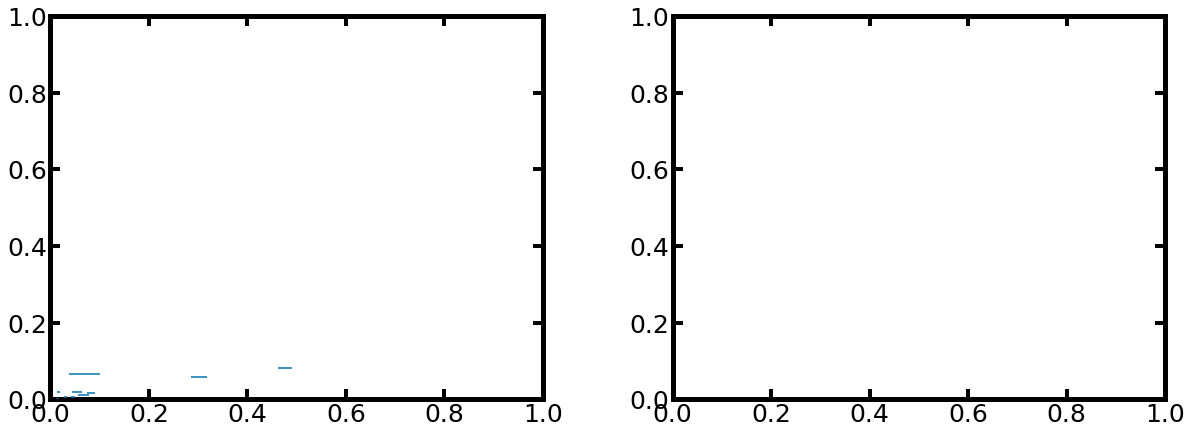

In [10]:
fig = plt.figure(figsize=(18,14))
#ax1 = fig.add_axes([0.1,0.58,0.38,0.38])
#ax2 = fig.add_axes([0.58,0.58,0.38,0.38])
ax3 = fig.add_axes([0.1,0.1,0.38,0.38])
ax4 = fig.add_axes([0.58,0.1,0.38,0.38])
print(coremass_w51e_selected[w51e_selected_ind_constT_nocomplete], sum_mass_constT_w51e_arr[w51e_selected_ind_constT_nocomplete])
"""
ax1.errorbar(coremass_w51e_selected[w51e_selected_ind_constT_complete], sum_mass_constT_w51e_arr[w51e_selected_ind_constT_complete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_constT_complete],  yerr=sum_mass_constT_w51e_err_complete,
             c=cmap[0], fmt='none',zorder=50, )
ax1.errorbar(coremass_w51e_selected[w51e_selected_ind_constT_nocomplete], sum_mass_constT_w51e_arr[w51e_selected_ind_constT_nocomplete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_constT_nocomplete],  yerr=sum_mass_constT_w51e_err_nocomplete,
             c=cmap[0], fmt='none',zorder=50, )
ax1.scatter(coremass_w51e_selected[w51e_selected_ind_constT_complete], sum_mass_constT_w51e_arr[w51e_selected_ind_constT_complete],
            s=60,c=cmap[0],zorder=50, label='W51-E')
ax1.scatter(coremass_w51e_selected[w51e_selected_ind_constT_nocomplete], sum_mass_constT_w51e_arr[w51e_selected_ind_constT_nocomplete],
            s=60,edgecolor=cmap[0], facecolor='none',zorder=50)
ax1.errorbar(coremass_w51n_selected[w51n_selected_ind_constT_complete], sum_mass_constT_w51n_arr[w51n_selected_ind_constT_complete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_constT_complete],  yerr=sum_mass_constT_w51n_err_complete,
             c=cmap[1], fmt='none',zorder=50, )
ax1.errorbar(coremass_w51n_selected[w51n_selected_ind_constT_nocomplete], sum_mass_constT_w51n_arr[w51n_selected_ind_constT_nocomplete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_constT_nocomplete],  yerr=sum_mass_constT_w51n_err_nocomplete,
             c=cmap[1], fmt='none',zorder=50, )
ax1.scatter(coremass_w51n_selected[w51n_selected_ind_constT_complete], sum_mass_constT_w51n_arr[w51n_selected_ind_constT_complete],
            s=60,c=cmap[1],zorder=50, label='W51-IRS2')
ax1.scatter(coremass_w51n_selected[w51n_selected_ind_constT_nocomplete], sum_mass_constT_w51n_arr[w51n_selected_ind_constT_nocomplete],
            s=60,edgecolor=cmap[1], facecolor='none',zorder=50)


ax2.errorbar(coremass_w51e_selected[w51e_selected_ind_MBBT_complete], sum_mass_MBBT_w51e_arr[w51e_selected_ind_MBBT_complete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_MBBT_complete],  yerr=sum_mass_MBBT_w51e_err_complete,
             c=cmap[0], fmt='none',zorder=50, )
ax2.errorbar(coremass_w51e_selected[w51e_selected_ind_MBBT_nocomplete], sum_mass_MBBT_w51e_arr[w51e_selected_ind_MBBT_nocomplete],
             xerr=coremasserr_w51e_selected[w51e_selected_ind_MBBT_nocomplete],  yerr=sum_mass_MBBT_w51e_err_nocomplete,
             c=cmap[0], fmt='none',zorder=50, )
ax2.scatter(coremass_w51e_selected[w51e_selected_ind_MBBT_complete], sum_mass_MBBT_w51e_arr[w51e_selected_ind_MBBT_complete],
            s=60,c=cmap[0],zorder=50, label='W51-E')
ax2.scatter(coremass_w51e_selected[w51e_selected_ind_MBBT_nocomplete], sum_mass_MBBT_w51e_arr[w51e_selected_ind_MBBT_nocomplete],
            s=60,edgecolor=cmap[0], facecolor='none',zorder=50)
ax2.errorbar(coremass_w51n_selected[w51n_selected_ind_MBBT_complete], sum_mass_MBBT_w51n_arr[w51n_selected_ind_MBBT_complete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_MBBT_complete],  yerr=sum_mass_MBBT_w51n_err_complete,
             c=cmap[1], fmt='none',zorder=50, )
ax2.errorbar(coremass_w51n_selected[w51n_selected_ind_MBBT_nocomplete], sum_mass_MBBT_w51n_arr[w51n_selected_ind_MBBT_nocomplete],
             xerr=coremasserr_w51n_selected[w51n_selected_ind_MBBT_nocomplete],  yerr=sum_mass_MBBT_w51n_err_nocomplete,
             c=cmap[1], fmt='none',zorder=50, )
ax2.scatter(coremass_w51n_selected[w51n_selected_ind_MBBT_complete], sum_mass_MBBT_w51n_arr[w51n_selected_ind_MBBT_complete],
            s=60,c=cmap[1],zorder=50, label='W51-IRS2')
ax2.scatter(coremass_w51n_selected[w51n_selected_ind_MBBT_nocomplete], sum_mass_MBBT_w51n_arr[w51n_selected_ind_MBBT_nocomplete],
            s=60,edgecolor=cmap[1], facecolor='none',zorder=50)
"""

ax3.errorbar(np.array(w51e_b3fov_b6flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b6_w51e_arr, xerr = w51e_b3fov_b6fluxerr,
             yerr=sum_flux_err_b6_w51e,
             c=cmap[0], fmt='none',zorder=50 )
ax3.scatter( np.array(w51e_b3fov_b6flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b6_w51e_arr, s=60,
             c=cmap[0],zorder=50 )
ax3.errorbar( np.array(w51n_b3fov_b6flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b6_w51n_arr, xerr = w51n_b3fov_b6fluxerr,
             yerr=sum_flux_err_b6_w51n,
             c=cmap[1], fmt='none',zorder=50 )
ax3.scatter( np.array(w51n_b3fov_b6flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b6_w51n_arr, s=60,
             c=cmap[1],zorder=50 )

ax4.errorbar(np.array(w51e_b3fov_b3flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b3_w51e_arr, xerr = w51e_b3fov_b3fluxerr,
             yerr=sum_flux_err_b3_w51e,
             c=cmap[0], fmt='none',zorder=50 )
ax4.scatter( np.array(w51e_b3fov_b3flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b3_w51e_arr, s=60,
             c=cmap[0],zorder=50 )
ax4.errorbar( np.array(w51n_b3fov_b3flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b3_w51n_arr, xerr = w51n_b3fov_b3fluxerr,
             yerr=sum_flux_err_b3_w51n,
             c=cmap[1], fmt='none',zorder=50 )
ax4.scatter( np.array(w51n_b3fov_b3flux)* (1-np.exp(-(2/2.355)**2*8*np.log(2)))   , sum_flux_b3_w51n_arr, s=60,
             c=cmap[1],zorder=50 )

ax1.plot([0.01,8000], [0.01*7/3,8000*7/3], ls='dashed', c='gray')
ax2.plot([0.01,8000], [0.01*7/3,8000*7/3], ls='dashed', c='gray')
ax1.plot([0.01,8000], [0.01,8000], ls='dashed', c='gray')
ax2.plot([0.01,8000], [0.01,8000], ls='dashed', c='gray')
ax1.plot([0.01,8000], [0.01*3/7,8000*3/7], ls='dashed', c='gray')
ax2.plot([0.01,8000], [0.01*3/7,8000*3/7], ls='dashed', c='gray')
ax1.plot([0.01,8000], [0.01/9,8000/9], ls='dashed', c='gray')
ax2.plot([0.01,8000], [0.01/9,8000/9], ls='dashed', c='gray')
ax1.plot([0.01,8000], [0.01/19,8000/19], ls='dashed', c='gray')
ax2.plot([0.01,8000], [0.01/19,8000/19], ls='dashed', c='gray')

ax3.plot([1e-4,10],[1e-4,10], ls='dashed',c='gray')
ax3.plot([1e-4,10],[1e-5,1], ls='dashed',c='gray')
ax3.plot([1e-4,10],[1e-6,0.1], ls='dashed',c='gray')

ax4.plot([1e-4,10],[1e-4,10], ls='dashed',c='gray')
ax4.plot([1e-4,10],[1e-5,1], ls='dashed',c='gray')
ax4.plot([1e-4,10],[1e-6,0.1], ls='dashed',c='gray')

ax1.text(10,7/3*1.5*10,r'$\epsilon_{\rm env}=70\%$', color='gray',rotation=40,fontsize=15)
ax2.text(10,7/3*1.5*10,r'$\epsilon_{\rm env}=70\%$', color='gray',rotation=40,fontsize=15)
ax1.text(10*1.5,1*1.5*10*1.5,r'$\epsilon_{\rm env}=50\%$', color='gray',rotation=40,fontsize=15)
ax2.text(10*1.5,1*1.5*10*1.5,r'$\epsilon_{\rm env}=50\%$', color='gray',rotation=40,fontsize=15)
ax1.text(10*1.5**2,3/7*1.5*10*1.5**2,r'$\epsilon_{\rm env}=30\%$', color='gray',rotation=40,fontsize=15)
ax2.text(10*1.5**2,3/7*1.5*10*1.5**2,r'$\epsilon_{\rm env}=30\%$', color='gray',rotation=40,fontsize=15)
ax1.text(10*1.5**3,1/9*1.5*10*1.5**3,r'$\epsilon_{\rm env}=10\%$', color='gray',rotation=40,fontsize=15)
ax2.text(10*1.5**3,1/9*1.5*10*1.5**3,r'$\epsilon_{\rm env}=10\%$', color='gray',rotation=40,fontsize=15)
ax1.text(10*1.5**4,1/19*1.5*10*1.5**4,r'$\epsilon_{\rm env}=5\%$', color='gray',rotation=40,fontsize=15)
ax2.text(10*1.5**4,1/19*1.5*10*1.5**4,r'$\epsilon_{\rm env}=5\%$', color='gray',rotation=40,fontsize=15)
ax1.set_xlim(0.5,800)
ax2.set_xlim(0.5,800)
ax1.set_ylim(0.1,200)
ax2.set_ylim(0.1,200)
ax3.set_xlim(1e-3,1e1)
ax3.set_ylim(1e-3,1e0)
ax4.set_xlim(1e-5,1e0)
ax4.set_ylim(1e-4,1e-1)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax4.set_xscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax1.set_xlabel(r'$M_{\rm core}$ $(M_\odot)$')
ax2.set_xlabel(r'$M_{\rm core}$ $(M_\odot)$')
ax1.set_ylabel(r'$sum(M_{\rm YSO, constT})$ $(M_\odot)$')
ax2.set_ylabel(r'$sum(M_{\rm YSO, MBBT})$ $(M_\odot)$')
ax3.set_xlabel(r'$F_{\rm core, 1.3mm}$ (Jy)')
ax4.set_xlabel(r'$F_{\rm core, 3mm}$ (Jy)')
ax3.set_ylabel(r'$sum(F_{\rm YSO, 1.3mm})$ (Jy)')
ax4.set_ylabel(r'$sum(F_{\rm YSO, 3mm})$ (Jy)')
ax1.legend(fontsize=15,frameon=False)
plt.savefig('coremass_ysosummass2.png')


In [ ]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.8,0.8])

w51e_b6_core_remained_flux = 1-sum_flux_b6_w51e_arr/w51e_b3fov_b6flux
w51n_b6_core_remained_flux = 1-sum_flux_b6_w51n_arr/w51n_b3fov_b6flux


ax1.scatter(temp_w51e_selected, w51e_b6_core_remained_flux , c=cmap[0], label='W51-E')
ax1.scatter(temp_w51n_selected, w51n_b6_core_remained_flux , c=cmap[1], label='W51-IRS2')
ax1.set_ylim(0.75,1.05)
ax1.set_xlabel(r'$T_{\rm core}$ (K)')
ax1.set_ylabel(r'$f_{\rm core, remained}$')
ax1.legend(fontsize=18, frameon=False)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


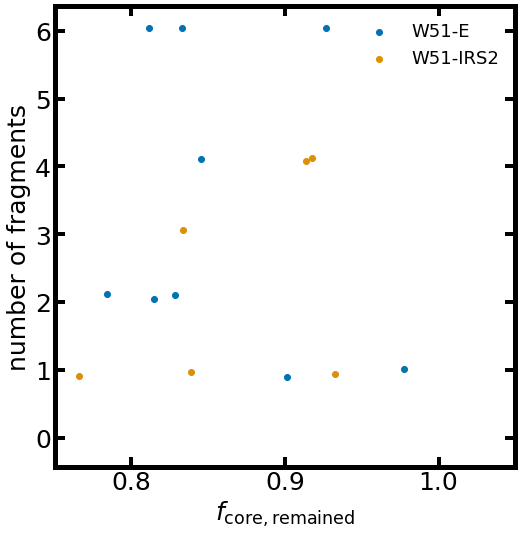

In [11]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.8,0.8])

w51e_b6_core_remained_flux = 1-sum_flux_b6_w51e_arr/w51e_b3fov_b6flux
w51n_b6_core_remained_flux = 1-sum_flux_b6_w51n_arr/w51n_b3fov_b6flux


ax1.scatter(w51e_b6_core_remained_flux , multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15, c=cmap[0], label='W51-E')
ax1.scatter(w51n_b6_core_remained_flux , multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15,c=cmap[1], label='W51-IRS2')
ax1.set_xlim(0.75,1.05)
ax1.set_ylabel('number of fragments')
ax1.set_xlabel(r'$f_{\rm core, remained}$')
ax1.legend(fontsize=18, frameon=False)





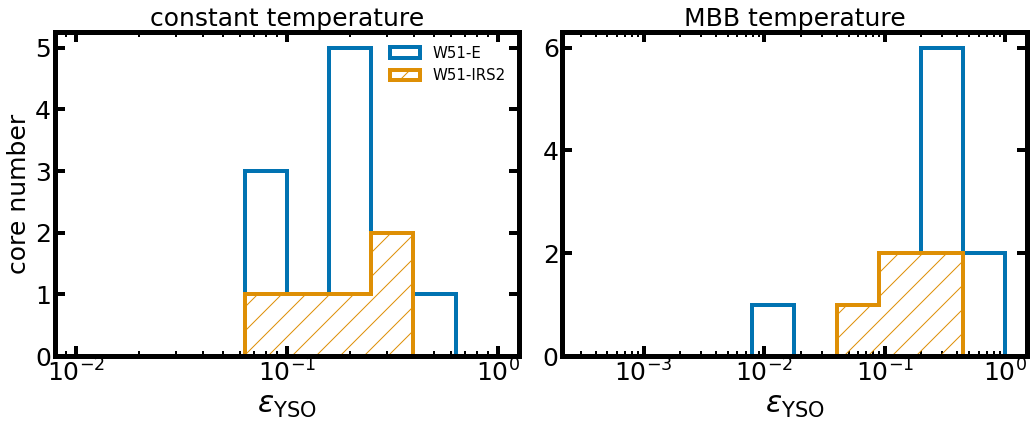

In [12]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_axes([0.08,0.15,0.43,0.75])
ax2 = fig.add_axes([0.55,0.15,0.43,0.75])
sum_mass_MBBT_w51e = sum_mass_MBBT_w51e_arr[w51e_selected_ind_MBBT_complete]
sum_mass_MBBT_w51n = sum_mass_MBBT_w51n_arr[w51n_selected_ind_MBBT_complete]
sum_mass_constT_w51e = sum_mass_constT_w51e_arr[w51e_selected_ind_constT_complete]
sum_mass_constT_w51n = sum_mass_constT_w51n_arr[w51n_selected_ind_constT_complete]
sum_mass_MBBT_w51e_ind = np.where(sum_mass_MBBT_w51e>0)[0]
sum_mass_MBBT_w51n_ind = np.where(sum_mass_MBBT_w51n>0)[0]
sum_mass_constT_w51e_ind = np.where(sum_mass_constT_w51e>0)[0]
sum_mass_constT_w51n_ind = np.where(sum_mass_constT_w51n>0)[0]


epsilon_yso_w51e_constT = sum_mass_constT_w51e[sum_mass_constT_w51e_ind]/(coremass_w51e_selected[w51e_selected_ind_constT_complete][sum_mass_constT_w51e_ind]
                                                                      +sum_mass_constT_w51e[sum_mass_constT_w51e_ind])
epsilon_yso_w51n_constT = sum_mass_constT_w51n[sum_mass_constT_w51n_ind]/(coremass_w51n_selected[w51n_selected_ind_constT_complete][sum_mass_constT_w51n_ind]
                                                                      +sum_mass_constT_w51n[sum_mass_constT_w51n_ind])
epsilon_yso_w51e_MBBT = sum_mass_MBBT_w51e[sum_mass_MBBT_w51e_ind]/(coremass_w51e_selected[w51e_selected_ind_MBBT_complete][sum_mass_MBBT_w51e_ind]
                                                                      +sum_mass_MBBT_w51e[sum_mass_MBBT_w51e_ind])
epsilon_yso_w51n_MBBT = sum_mass_MBBT_w51n[sum_mass_MBBT_w51n_ind]/(coremass_w51n_selected[w51n_selected_ind_MBBT_complete][sum_mass_MBBT_w51n_ind]
                                                                      +sum_mass_MBBT_w51n[sum_mass_MBBT_w51n_ind])
bins1 = np.logspace(-3.5,0,11)
bins2 = np.logspace(-2,0,11)

ax1.hist(epsilon_yso_w51e_constT, histtype='step', color=cmap[0], label='W51-E',lw=4, bins=bins2)
ax1.hist(epsilon_yso_w51n_constT, histtype='step', color=cmap[1], label='W51-IRS2',lw=4, bins=bins2,hatch='/')
ax2.hist(epsilon_yso_w51e_MBBT, histtype='step', color=cmap[0], label='W51-E',lw=4, bins=bins1)
ax2.hist(epsilon_yso_w51n_MBBT, histtype='step', color=cmap[1], label='W51-IRS2',lw=4, bins=bins1,hatch='/')

#ax1.set_xscale('log')
#ax2.set_xscale('log')
#ax1.set_yscale('log')
#ax2.set_yscale('log')
#ax1.set_xlabel(r'$M_{\rm core}$ $(M_\odot)$')
#ax2.set_xlabel(r'$M_{\rm core}$ $(M_\odot)$')
#ax1.set_ylabel(r'$sum(M_{\rm YSO, constT})$ $(M_\odot)$')
#ax2.set_ylabel(r'$sum(M_{\rm YSO, MBBT})$ $(M_\odot)$')
ax1.legend(fontsize=15,frameon=False)
#plt.savefig('coremass_ysosummass.png')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_title('constant temperature',fontsize=25)
ax2.set_title('MBB temperature',fontsize=25)
ax1.set_xlabel(r'$\epsilon_{\rm YSO}$',fontsize=30)
ax2.set_xlabel(r'$\epsilon_{\rm YSO}$',fontsize=30)
ax1.set_ylabel('core number')
plt.savefig('epsilon_yso.png')



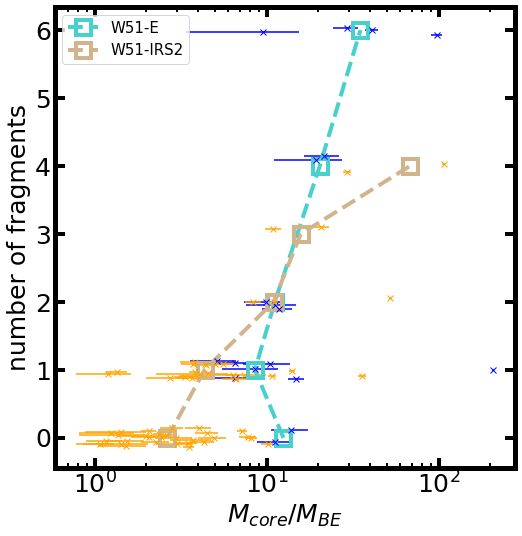

In [13]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.errorbar(coremass_w51e_selected/bemass_w51e_selected, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15, 
            xerr = coremasserr_w51e_selected/bemass_w51e_selected, c='b', fmt='x')
ax1.errorbar(coremass_w51n_selected/bemass_w51n_selected, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15, 
            xerr =coremasserr_w51n_selected/bemass_w51n_selected, c='orange', fmt='x')
xarr = np.arange(10)

median_w51e_ratio = np.array([np.nanmedian(coremass_w51e_selected[np.where(multiplicity_w51e_b3fov[4]==i)]/bemass_w51e_selected[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
median_w51n_ratio = np.array([np.nanmedian(coremass_w51n_selected[np.where(multiplicity_w51n_b3fov[4]==i)]/bemass_w51n_selected[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
ax1.plot(median_w51e_ratio[np.isfinite(median_w51e_ratio)], xarr[np.isfinite(median_w51e_ratio)],marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
ax1.plot(median_w51n_ratio[np.isfinite(median_w51n_ratio)], xarr[np.isfinite(median_w51n_ratio)],marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4 ,markersize=15, label='W51-IRS2')

ax1.set_xlabel('$M_{core}/M_{BE}$')
ax1.set_ylabel('number of fragments')
ax1.legend(fontsize=15)
ax1.set_xscale('log')




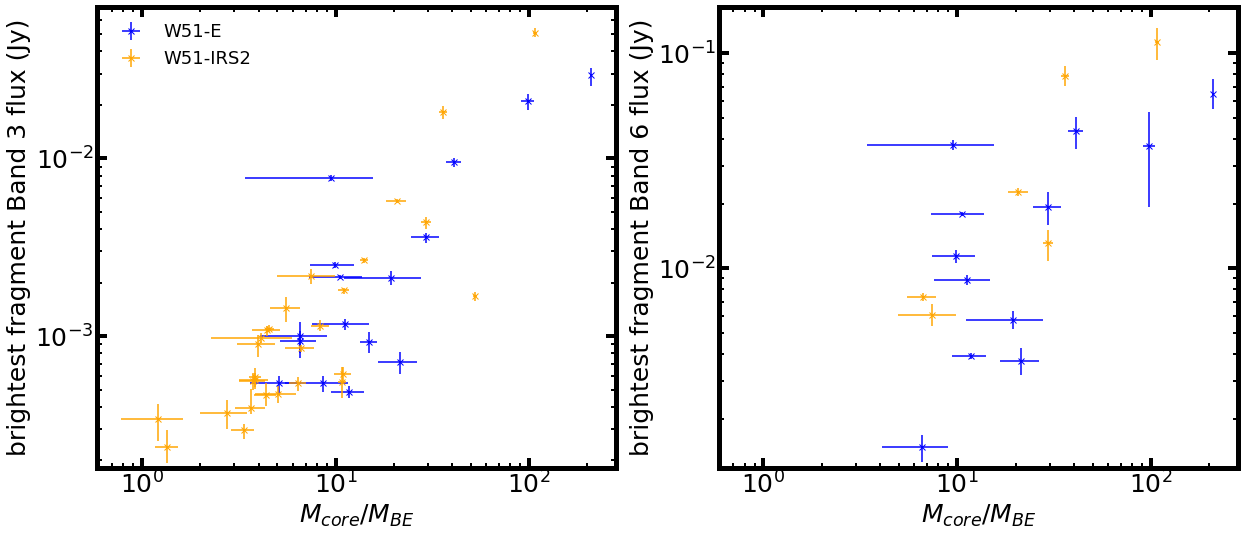

In [14]:
fig = plt.figure(figsize=(18,8))
ax2 = fig.add_axes([0.1,0.15,0.4,0.8])
ax1 = fig.add_axes([0.58,0.15,0.4,0.8])
ax1.errorbar(coremass_w51e_selected/bemass_w51e_selected, ysoflux_b6_w51e_arr, 
            xerr = coremasserr_w51e_selected/bemass_w51e_selected, yerr=ysofluxerr_b6_w51e, c='b', fmt='x')
ax1.errorbar(coremass_w51n_selected/bemass_w51n_selected, ysoflux_b6_w51n_arr, 
            xerr = coremasserr_w51n_selected/bemass_w51n_selected, yerr=ysofluxerr_b6_w51n, c='orange', fmt='x')


ax2.errorbar(coremass_w51e_selected/bemass_w51e_selected, ysoflux_b3_w51e_arr, 
            xerr = coremasserr_w51e_selected/bemass_w51e_selected, yerr=ysofluxerr_b3_w51e, c='b', fmt='x', label='W51-E')
ax2.errorbar(coremass_w51n_selected/bemass_w51n_selected, ysoflux_b3_w51n_arr, 
            xerr = coremasserr_w51n_selected/bemass_w51n_selected, yerr=ysofluxerr_b3_w51n, c='orange', fmt='x', label='W51-IRS2')

ax1.set_xlabel('$M_{core}/M_{BE}$')
ax2.set_xlabel('$M_{core}/M_{BE}$')
ax2.set_ylabel('brightest fragment Band 3 flux (Jy)')
ax1.set_ylabel('brightest fragment Band 6 flux (Jy)')
ax2.legend(fontsize=18, frameon=False)
#ax2.legend(fontsize=18,loc='upper left')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')


[0.22090865 0.30613472 0.48292376 0.52795379 0.27539318 0.8398146
 0.32770794 0.57582018 0.44825346 0.6693875  0.32379414 0.2922179
 0.28758738 0.41771393 0.48599954 0.45350366 0.50420155 0.41081961]
[0.29071753 0.42362448 0.19660138 0.56681524 0.4831437  0.30729639
 0.41899862 0.32028873 0.55089804 0.46353468 0.37275916 0.46769094
 0.59381081 0.52031483 0.34992407 0.51048675 0.59307793 0.66681458
 0.95623465 0.49682883 0.45134667 0.72099271 0.46125698 0.77625831
 0.93541482 0.58790851 0.57609443 1.41008031 0.57183038 0.71093868
 0.47172734 0.46161845 0.67830217 0.68929734 0.77487871 0.59964316
 0.87171829 0.61372075 0.48694952 0.4920726  0.58030707 0.84708678
 0.77566866 0.47356604 0.74597081 0.75087319 0.96887607 0.69408259
 0.99727114 0.98746492 1.29108865 0.87074966 1.00303653 1.1552325
 0.98762589 1.13253008 1.11662013]


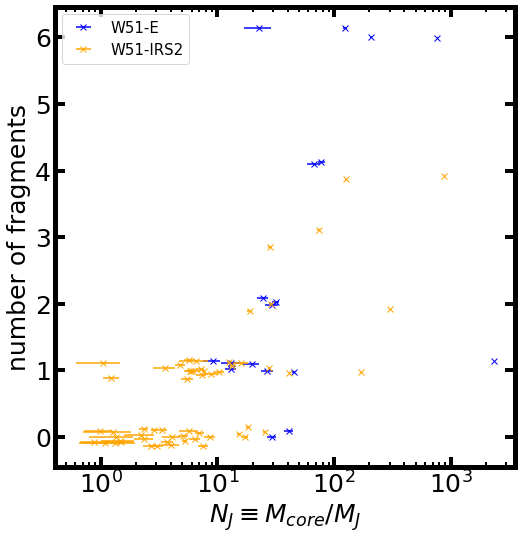

In [15]:
print(jeansmass_w51e_selected)
print(jeansmass_w51n_selected)
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.errorbar(coremass_w51e_selected/jeansmass_w51e_selected, multiplicity_w51e_b3fov[4]+np.random.rand(len(multiplicity_w51e_b3fov[4]))*0.3-0.15, 
            xerr = coremasserr_w51e_selected/bemass_w51e_selected, c='b', fmt='x',label='W51-E')
ax1.errorbar(coremass_w51n_selected/jeansmass_w51n_selected, multiplicity_w51n_b3fov[4]+np.random.rand(len(multiplicity_w51n_b3fov[4]))*0.3-0.15, 
            xerr =coremasserr_w51n_selected/bemass_w51n_selected, c='orange', fmt='x',label='W51-IRS2')
xarr = np.arange(10)

#median_w51e_ratio = np.array([np.nanmedian(coremass_w51e_selected[np.where(multiplicity_w51e_b3fov[4]==i)]/bemass_w51e_selected[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51n_ratio = np.array([np.nanmedian(coremass_w51n_selected[np.where(multiplicity_w51n_b3fov[4]==i)]/bemass_w51n_selected[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#ax1.plot(median_w51e_ratio[np.isfinite(median_w51e_ratio)], xarr[np.isfinite(median_w51e_ratio)],marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(median_w51n_ratio[np.isfinite(median_w51n_ratio)], xarr[np.isfinite(median_w51n_ratio)],marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4 ,markersize=15, label='W51-IRS2')

ax1.set_xlabel(r'$N_{J}\equiv M_{core}/M_{J}$')
ax1.set_ylabel('number of fragments')
ax1.legend(fontsize=15)
ax1.set_xscale('log')







*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[0.22090865 0.30613472 0.48292376 0.52795379 0.27539318 0.8398146
 0.32770794 0.57582018 0.44825346 0.6693875  0.32379414 0.2922179
 0.28758738 0.41771393 0.48599954 0.45350366 0.50420155 0.41081961] [0.29071753 0.42362448 0.19660138 0.56681524 0.4831437  0.30729639
 0.41899862 0.32028873 0.55089804 0.46353468 0.37275916 0.46769094
 0.59381081 0.52031483 0.34992407 0.51048675 0.59307793 0.66681458
 0.95623465 0.49682883 0.45134667 0.72099271 0.46125698 0.77625831
 0.93541482 0.58790851 0.57609443 1.41008031 0.57183038 0.71093868
 0.47172734 0.46161845 0.67830217 0.68929734 0.77487871 0.59964316
 0.87171829 0.61372075 0.48694952 0.4920726  0.58030707 0.84708678
 0.77566866 0.47356604 0.74597081 0.75087319 0.96887607 0.69408259
 0.99727114 0.98746492 1.29108865 0.87074966 1.00303653 1.1552325
 0.98762589 1.13253008 1.11662013]
0.058023466346309456
0.07964481401196899
0.26169120218468056 0.964146807934278
2 29 5
0.40700000000000003
0.1836842105263158


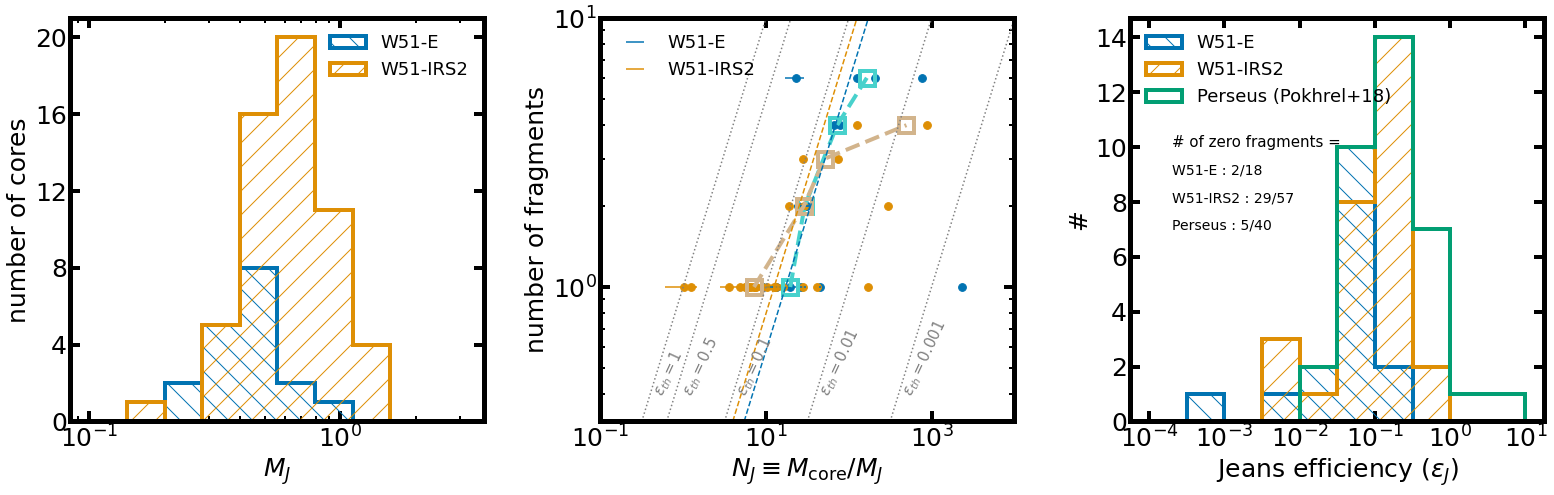

In [16]:
fig = plt.figure(figsize=(23,7))
ax3 = fig.add_axes([0.07,0.15,0.25,0.8])
ax1 = fig.add_axes([0.39,0.15,0.25,0.8])
ax2 = fig.add_axes([0.71,0.15,0.25,0.8])
bins = np.logspace(-1, 0.5, 11)
ax3.hist(jeansmass_w51e_selected,  bins=bins,histtype='step', color=cmap[0], label='W51-E', hatch='\\', lw=4)
ax3.hist(jeansmass_w51n_selected,  bins=bins,histtype='step', color=cmap[1], label='W51-IRS2', hatch='/', lw=4)
print(jeansmass_w51e_selected,jeansmass_w51n_selected,)
ax3.set_xlabel('$M_J$')
ax3.set_xscale('log')
ax3.set_ylabel('number of cores')
ax3.legend(fontsize=18, frameon=False)
ax3.set_yticks([0,4,8,12,16,20])
ax1.scatter(coremass_w51e_selected/jeansmass_w51e_selected, multiplicity_w51e_b3fov[4], s=60,c=cmap[0])
ax1.scatter(coremass_w51n_selected/jeansmass_w51n_selected, multiplicity_w51n_b3fov[4], s=60,c=cmap[1])

ax1.errorbar(coremass_w51e_selected/jeansmass_w51e_selected, multiplicity_w51e_b3fov[4], 
            xerr = coremasserr_w51e_selected/bemass_w51e_selected, c=cmap[0], fmt='none',label='W51-E')
ax1.errorbar(coremass_w51n_selected/jeansmass_w51n_selected, multiplicity_w51n_b3fov[4], 
            xerr =coremasserr_w51n_selected/bemass_w51n_selected, c=cmap[1], fmt='none',label='W51-IRS2')
jeans_number_w51e = coremass_w51e_selected/jeansmass_w51e_selected
jeans_number_w51n = coremass_w51n_selected/jeansmass_w51n_selected

xarr = np.arange(9)+1

median_w51e_ratio = np.array([np.nanmedian(jeans_number_w51e[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
median_w51n_ratio = np.array([np.nanmedian(jeans_number_w51n[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])

ax1.plot(median_w51e_ratio[np.isfinite(median_w51e_ratio)], xarr[np.isfinite(median_w51e_ratio)],marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15)
ax1.plot(median_w51n_ratio[np.isfinite(median_w51n_ratio)], xarr[np.isfinite(median_w51n_ratio)],marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4 ,markersize=15, )
w51e_average = np.average(multiplicity_w51e_b3fov[4]/(coremass_w51e_selected/jeansmass_w51e_selected))
w51n_average = np.average(multiplicity_w51n_b3fov[4]/(coremass_w51n_selected/jeansmass_w51n_selected))

#median_w51e_ratio = np.array([np.nanmedian(coremass_w51e_selected[np.where(multiplicity_w51e_b3fov[4]==i)]/bemass_w51e_selected[np.where(multiplicity_w51e_b3fov[4]==i)]) for i in xarr])
#median_w51n_ratio = np.array([np.nanmedian(coremass_w51n_selected[np.where(multiplicity_w51n_b3fov[4]==i)]/bemass_w51n_selected[np.where(multiplicity_w51n_b3fov[4]==i)]) for i in xarr])
#ax1.plot(median_w51e_ratio[np.isfinite(median_w51e_ratio)], xarr[np.isfinite(median_w51e_ratio)],marker='s', mew=4,mec='mediumturquoise', mfc='none',ls='dashed', c='mediumturquoise', lw=4 ,markersize=15, label='W51-E')
#ax1.plot(median_w51n_ratio[np.isfinite(median_w51n_ratio)], xarr[np.isfinite(median_w51n_ratio)],marker='s', mew=4,mec='tan', mfc='none',ls='dashed', c='tan', lw=4 ,markersize=15, label='W51-IRS2')

ax1.set_xlabel(r'$N_{J}\equiv M_{\rm core}/M_{J}$')
ax1.set_ylabel('number of fragments')
ax1.legend(fontsize=18, frameon=False)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(0.9,10)
ax1.plot([10**-0.5,1e3],[10**-0.5,1e3], ls='dotted',c='gray')
ax1.plot([10**-0.5/0.5,1e3/0.5],[10**-0.5,1e3], ls='dotted',c='gray')
ax1.plot([10**-0.5/0.1,1e3/0.1],[10**-0.5,1e3], ls='dotted',c='gray')
ax1.plot([10**-0.5/0.01,1e3/0.01],[10**-0.5,1e3], ls='dotted',c='gray')
ax1.plot([10**-0.5/0.001,1e3/0.001],[10**-0.5,1e3], ls='dotted',c='gray')

ax1.plot([10**-0.5/w51e_average,1e3/w51e_average],[10**-0.5,1e3], ls='dashed',c=cmap[0])
ax1.plot([10**-0.5/w51n_average,1e3/w51n_average],[10**-0.5,1e3], ls='dashed',c=cmap[1])

ax1.text(0.4, 0.4, r'$\epsilon_{th}=1$',fontsize=15, color='gray',rotation=65)
ax1.text(0.9, 0.4, r'$\epsilon_{th}=0.5$',fontsize=15, color='gray',rotation=65)
ax1.text(4, 0.4, r'$\epsilon_{th}=0.1$',fontsize=15, color='gray',rotation=65)
ax1.text(40, 0.4, r'$\epsilon_{th}=0.01$',fontsize=15, color='gray',rotation=65)
ax1.text(400, 0.4, r'$\epsilon_{th}=0.001$',fontsize=15, color='gray',rotation=65)

print(w51e_average)
print(w51n_average)
jeans_efficiency_w51e = multiplicity_w51e_b3fov[4]/(coremass_w51e_selected/jeansmass_w51e_selected)
jeans_efficiency_w51n = multiplicity_w51n_b3fov[4]/(coremass_w51n_selected/jeansmass_w51n_selected)

print(np.max(jeans_efficiency_w51e),np.max(jeans_efficiency_w51n))

ax1.set_xlim(1e-1,1e4)
ax1.set_ylim(10**-0.5,10)

pokhrel18 = np.array([0.14, 0.07, 0.08, 0.23, 0.53, 0, 1.38, 0.18, 0, 0, 0.09, 0.79, 0.03, 0.07, 0.28, 0.1,0.01,
            0.1, 0.04, 0.1, 0.27, 0.37, 0.63, 0.44, 0.18, 0.08, 0.0, 0.04, 0.1, 0.04, 0.6, 0.06, 0.26,
            0.23, 0.06,0.14, 0, 7.92, 0.44, 0.2])
print(np.median(pokhrel18))
pokhrel182 = [0.14, 0.07, 0.08, 0.23, 0.53, 0.0,  0.18, 0, 0, 0.09, 0.79, 0.03, 0.07, 0.28, 0.1,0.01,
            0.1, 0.04, 0.1, 0.27, 0.37, 0.63, 0.44, 0.18, 0.08, 0.0, 0.04, 0.1, 0.04, 0.6, 0.06, 0.26,
            0.23, 0.06,0.14, 0, 0.44, 0.2]
bins = np.logspace(-4,1,11)
zerocount_w51e = len(np.where( np.array(multiplicity_w51e_b3fov[4])==0)[0])
zerocount_w51n = len(np.where( np.array(multiplicity_w51n_b3fov[4])==0)[0])
zerocount_pokhrel = len(np.where(pokhrel18==0.0)[0])
print(zerocount_w51e, zerocount_w51n, zerocount_pokhrel)
ax2.hist(jeans_efficiency_w51e,  bins=bins,histtype='step', color=cmap[0], label='W51-E', hatch='\\', lw=4)
ax2.hist(jeans_efficiency_w51n,  bins=bins,histtype='step', color=cmap[1], label='W51-IRS2', hatch='/',lw=4)
ax2.hist(pokhrel18, bins=bins, histtype='step', color=cmap[2],lw=4, label='Perseus (Pokhrel+18)' )
ax2.legend(fontsize=18,loc='upper left', frameon=False)
ax2.set_xscale('log')
ax2.set_xlabel(r'Jeans efficiency ($\epsilon_J$)')
ax2.set_ylabel('#')
ax2.set_xticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax2.text(2e-4,10, '# of zero fragments = ',fontsize=15) 
ax2.text(2e-4,9, 'W51-E : %d/%d'%(zerocount_w51e, len(jeans_efficiency_w51e)),fontsize=14)
ax2.text(2e-4,8, 'W51-IRS2 : %d/%d'%(zerocount_w51n, len(jeans_efficiency_w51n)),fontsize=14)
ax2.text(2e-4,7, 'Perseus : %d/%d'%(zerocount_pokhrel, len(pokhrel18)),fontsize=14)

print(np.average(pokhrel18))
print(np.average(pokhrel182))
plt.savefig('jeans_analysis.png')


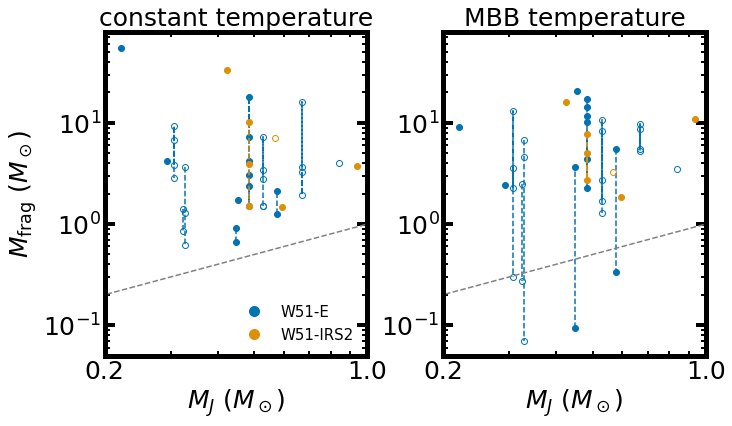

In [30]:
from matplotlib import ticker
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.14,0.17,0.365,0.75])
ax2 = fig.add_axes([0.61,0.17,0.365,0.75])

for i, ysoind in enumerate(ysoind_w51e):
    if len(ysoind)>0:
        positive_ind = np.where(yso_constTmass_w51e[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax1.plot(np.ones(xlen)*jeansmass_w51e_selected[i],yso_constTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[0])
            else:
                ax1.plot(np.ones(xlen)*jeansmass_w51e_selected[i],yso_constTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[0])
        positive_ind = np.where(yso_MBBTmass_w51e[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax2.plot(np.ones(xlen)*jeansmass_w51e_selected[i],yso_MBBTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[0])
            else:
                ax2.plot(np.ones(xlen)*jeansmass_w51e_selected[i],yso_MBBTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[0])
        


for i, ysoind in enumerate(ysoind_w51n):
    if len(ysoind)>0:
        positive_ind = np.where(yso_constTmass_w51n[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax1.plot(np.ones(xlen)*jeansmass_w51n_selected[i],yso_constTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[1])
            else:
                ax1.plot(np.ones(xlen)*jeansmass_w51n_selected[i],yso_constTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[1])
        positive_ind = np.where(yso_MBBTmass_w51n[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax2.plot(np.ones(xlen)*jeansmass_w51n_selected[i],yso_MBBTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[1])
            else:
                ax2.plot(np.ones(xlen)*jeansmass_w51n_selected[i],yso_MBBTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[1])
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.plot([0.1,5], [0.1,5], ls='dashed', c='gray')
ax2.plot([0.1,5], [0.1,5], ls='dashed', c='gray')

#ax1.set_xlim(0.2,1)
#ax2.set_xlim(0.2,1)

ax1.set_xlabel(r'$M_{J}$ $(M_\odot)$')
ax2.set_xlabel(r'$M_{J}$ $(M_\odot)$')
ax1.set_ylabel(r'$M_{\rm frag}$ $(M_\odot)$')
#ax2.set_ylabel(r'$M_{\rm env, MBBT}$ $(M_\odot)$')
handles=[]
dummy_w51e = Line2D([0], [0], label='W51-E', marker='o', markersize=10, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
dummy_w51n = Line2D([0], [0], label='W51-IRS2', marker='o', markersize=10, 
          markerfacecolor=cmap[1], linestyle='',markeredgecolor=cmap[1])
handles.extend([dummy_w51e, dummy_w51n])
ax1.legend(handles=handles,fontsize=15,frameon=False,loc='lower right')
ax1.set_xticks([0.2,1])
ax2.set_xticks([0.2,1])

ax1.set_ylim(0.05,80)
ax2.set_ylim(0.05,80)
ax1.set_xlim(0.2,1)
ax2.set_xlim(0.2,1)
ax1.set_title('constant temperature')
ax2.set_title('MBB temperature')
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
plt.savefig('jeansmass_vs_ysomass.png')
                

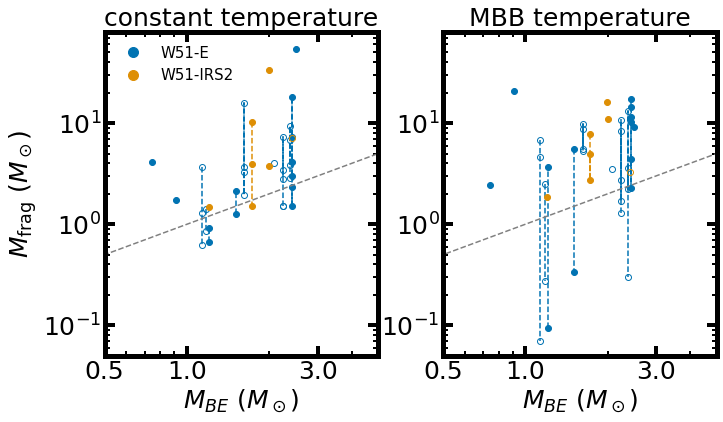

In [18]:


fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.14,0.17,0.38,0.75])
ax2 = fig.add_axes([0.61,0.17,0.38,0.75])

for i, ysoind in enumerate(ysoind_w51e):
    if len(ysoind)>0:
        positive_ind = np.where(yso_constTmass_w51e[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax1.plot(np.ones(xlen)*bemass_w51e_selected[i],yso_constTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[0])
            else:
                ax1.plot(np.ones(xlen)*bemass_w51e_selected[i],yso_constTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[0])
        positive_ind = np.where(yso_MBBTmass_w51e[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax2.plot(np.ones(xlen)*bemass_w51e_selected[i],yso_MBBTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[0])
            else:
                ax2.plot(np.ones(xlen)*bemass_w51e_selected[i],yso_MBBTmass_w51e[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[0])
        


for i, ysoind in enumerate(ysoind_w51n):
    if len(ysoind)>0:
        positive_ind = np.where(yso_constTmass_w51n[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax1.plot(np.ones(xlen)*bemass_w51n_selected[i],yso_constTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[1])
            else:
                ax1.plot(np.ones(xlen)*bemass_w51n_selected[i],yso_constTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[1])
        positive_ind = np.where(yso_MBBTmass_w51n[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax2.plot(np.ones(xlen)*bemass_w51n_selected[i],yso_MBBTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', c=cmap[1])
            else:
                ax2.plot(np.ones(xlen)*bemass_w51n_selected[i],yso_MBBTmass_w51n[ysoind][positive_ind],
                         marker='o', ls='dashed', mfc='none', color=cmap[1])
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.plot([0.1,5], [0.1,5], ls='dashed', c='gray')
ax2.plot([0.1,5], [0.1,5], ls='dashed', c='gray')

#ax1.set_xlim(0.2,1)
#ax2.set_xlim(0.2,1)

ax1.set_xlabel(r'$M_{BE}$ $(M_\odot)$')
ax2.set_xlabel(r'$M_{BE}$ $(M_\odot)$')
ax1.set_ylabel(r'$M_{\rm frag}$ $(M_\odot)$')
#ax2.set_ylabel(r'$M_{\rm env, MBBT}$ $(M_\odot)$')
handles=[]
dummy_w51e = Line2D([0], [0], label='W51-E', marker='o', markersize=10, 
          markerfacecolor=cmap[0], linestyle='',markeredgecolor=cmap[0])
dummy_w51n = Line2D([0], [0], label='W51-IRS2', marker='o', markersize=10, 
          markerfacecolor=cmap[1], linestyle='',markeredgecolor=cmap[1])
handles.extend([dummy_w51e, dummy_w51n])
ax1.legend(handles=handles,fontsize=15,frameon=False)
ax1.set_xticks([0.5,1,3])
ax2.set_xticks([0.5,1,3])

ax1.set_ylim(0.05,80)
ax2.set_ylim(0.05,80)
ax1.set_xlim(0.5,5)
ax2.set_xlim(0.5,5)
ax1.set_title('constant temperature')
ax2.set_title('MBB temperature')
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
plt.savefig('jeansmass_vs_ysomass.png')

Text(0, 0.5, 'number of fragments')

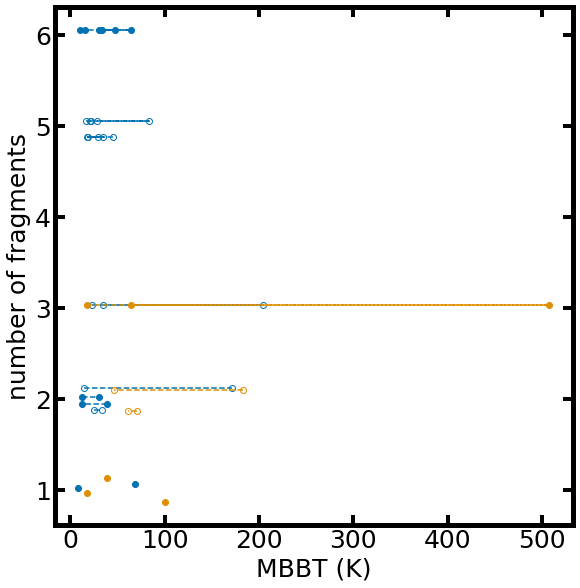

In [19]:
import random

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.15,0.15,0.9,0.9])
temp_yso_w51e = catalog_w51e_yso['temp']
temp_yso_w51n = catalog_w51n_yso['temp']

for i, ysoind in enumerate(ysoind_w51e):
    if len(ysoind)>0:
        positive_ind = np.where(temp_yso_w51e[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax1.plot(temp_yso_w51e[ysoind][positive_ind],np.ones(xlen)*(xlen+random.random()*0.3-0.15),
                         marker='o', ls='dashed', c=cmap[0], label='W51-E')
            else:
                ax1.plot(temp_yso_w51e[ysoind][positive_ind],np.ones(xlen)*(xlen+random.random()*0.3-0.15),
                         marker='o', ls='dashed', mfc='none', color=cmap[0])

for i, ysoind in enumerate(ysoind_w51n):
        positive_ind = np.where(temp_yso_w51n[ysoind]>0)[0]
        xlen = len(positive_ind)
        if xlen>0:
            if len(ysoind)==xlen:
                ax1.plot(temp_yso_w51n[ysoind][positive_ind],np.ones(xlen)*(xlen+random.random()*0.3-0.15),
                         marker='o', ls='dashed', c=cmap[1], label='W51-IRS2')
            else:
                ax1.plot(temp_yso_w51n[ysoind][positive_ind],np.ones(xlen)*(xlen+random.random()*0.3-0.15),
                         marker='o', ls='dashed', mfc='none', color=cmap[1])
        


#ax1.set_xscale('log')
#ax2.set_xscale('log')
#ax1.set_yscale('log')
#ax2.set_yscale('log')


ax1.set_xlabel('MBBT (K)')
ax1.set_ylabel('number of fragments')


#ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))





### protostellar vs prestellar (w51e)



[12] [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17]
[0.01476] [2.856    1.238    0.485    0.3071   0.02129  0.08442  0.05473  0.06794
 0.03131  0.07018  0.04665  0.01639  0.009237 0.03728  0.01502  0.01764
 0.006736]
[63.54 61.72 57.26 54.98 23.27 49.07 31.74 48.08 28.58 53.95 24.72 27.35
 23.   25.01 31.97 23.98 24.22]
1.389204150126222e-05 0.25395575579476326 0.040192997556569576
[14.0085182   9.03297783  6.03218213  1.90570627  5.00938231  9.04994205
  5.45499064  1.81921994  2.14813058  4.76268864  2.91171225  4.9916332
  2.07319707  1.62693318  2.31899893  3.45510158  4.97852291  6.39679663
  1.76808263  1.43021203  3.97260202  0.98274564  0.86889773  1.93066391
  1.09976208  1.46271071  1.48632431  1.50238976  1.50123762 23.75      ] [252.60311592  71.72938196  58.75656824  71.02498078  35.64237097
  12.71016567  11.68397826   9.15477268   3.53346573   7.05635521
  13.24968708   3.06546176   6.4629397    7.94188851   3.30664533
   4.76171677  14.88398986   2.81911917   2.76

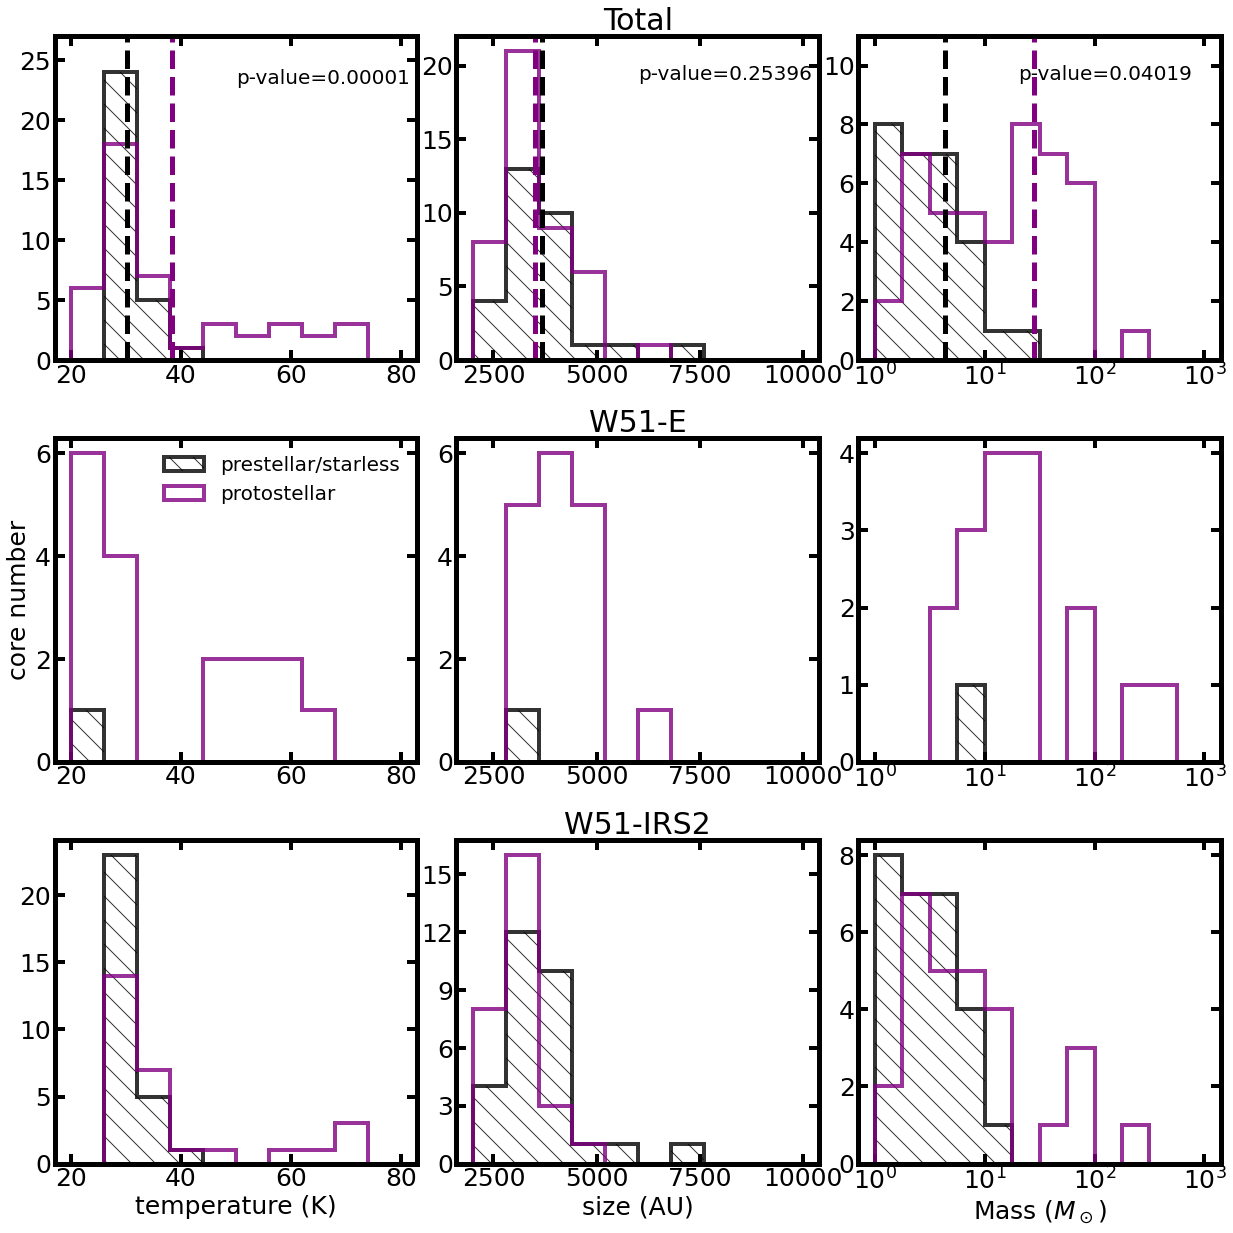

In [11]:
from scipy import stats

w51e_size_selected = np.array([size_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51n_size_selected = np.array([size_w51n[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51e_temp_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51n_temp_selected = np.array([temp_w51n[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51e_size_selected = np.array([size_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51n_size_selected = np.array([size_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
w51e_temp_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51n_temp_selected = np.array([temp_w51n[np.where(catdata_w51n_b6.no==ind)[0]][0] for ind in multiplicity_w51n_b3fov[3]])
prestellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])==0)[0]
protostellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])>0)[0]
prestellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])==0)[0]
protostellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])>0)[0]
print(prestellar_w51e,protostellar_w51e)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_axes([0.08,0.07,0.28,0.25])
ax2 = fig.add_axes([0.39,0.07,0.28,0.25])
ax3 = fig.add_axes([0.7,0.07,0.28,0.25])
ax4 = fig.add_axes([0.08,0.38,0.28,0.25])
ax5 = fig.add_axes([0.39,0.38,0.28,0.25])
ax6 = fig.add_axes([0.7,0.38,0.28,0.25])
ax7 = fig.add_axes([0.08,0.69,0.28,0.25])
ax8 = fig.add_axes([0.39,0.69,0.28,0.25])
ax9 = fig.add_axes([0.7,0.69,0.28,0.25])

fluxbins=np.logspace(-0.5,1,num=11)
print(np.array(w51e_b3fov_b6flux)[prestellar_w51e],np.array(w51e_b3fov_b6flux)[protostellar_w51e])
print(w51e_temp_selected[protostellar_w51e])
#ax1.hist(np.array(w51e_b3fov_b6flux)[prestellar_w51e],bins=fluxbins, alpha=0.8,  histtype='step', facecolor='none',edgecolor='k', hatch='\\',label='prestellar/starless',lw=4)
#ax1.hist(np.array(w51e_b3fov_b6flux)[protostellar_w51e],bins=fluxbins, alpha=0.8,histtype='step',facecolor='none',edgecolor='purple', label='protostellar',lw=4)
massbins=np.logspace(0,3,num=13)
sizebins=np.linspace(2000,10000,num=11)
tempbins=np.linspace(20,80,num=11)


ax3.hist(coremass_w51n_selected[prestellar_w51n],bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax3.hist(coremass_w51n_selected[protostellar_w51n],bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)
ax2.hist(w51n_size_selected[prestellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax2.hist(w51n_size_selected[protostellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax1.hist(w51n_temp_selected[prestellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax1.hist(w51n_temp_selected[protostellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

ax4.hist(w51e_temp_selected[prestellar_w51e],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax4.hist(w51e_temp_selected[protostellar_w51e],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax5.hist(w51e_size_selected[prestellar_w51e],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax5.hist(w51e_size_selected[protostellar_w51e],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax6.hist(coremass_w51e_selected[prestellar_w51e],bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax6.hist(coremass_w51e_selected[protostellar_w51e],bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)


coremass_prestellar_total = np.append(coremass_w51n_selected[prestellar_w51n], w51e_temp_selected[prestellar_w51e])
coremass_protostellar_total = np.append(coremass_w51n_selected[protostellar_w51n], w51e_temp_selected[protostellar_w51e])
size_prestellar_total = np.append(w51n_size_selected[prestellar_w51n], w51e_size_selected[prestellar_w51e])
size_protostellar_total = np.append(w51n_size_selected[protostellar_w51n], w51e_size_selected[protostellar_w51e])
temp_prestellar_total = np.append(w51n_temp_selected[prestellar_w51n], w51n_temp_selected[prestellar_w51e])
temp_protostellar_total = np.append(w51n_temp_selected[protostellar_w51n], w51e_temp_selected[protostellar_w51e])


print(stats.ks_2samp(coremass_prestellar_total, coremass_protostellar_total).pvalue,
      stats.ks_2samp(size_prestellar_total, size_protostellar_total).pvalue,
      stats.ks_2samp(temp_prestellar_total, temp_protostellar_total).pvalue)
ax7.text(50, 23, 'p-value=%6.5f'%stats.ks_2samp(coremass_prestellar_total, coremass_protostellar_total).pvalue,fontsize=20)
ax8.text(6000, 19, 'p-value=%6.5f'%stats.ks_2samp(size_prestellar_total, size_protostellar_total).pvalue,fontsize=20)
ax9.text(20,9.5, 'p-value=%6.5f'%stats.ks_2samp(temp_prestellar_total, temp_protostellar_total).pvalue,fontsize=20)


ax9.hist(coremass_prestellar_total,bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax9.hist(coremass_protostellar_total,bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)
print(coremass_prestellar_total,coremass_protostellar_total)
ax8.hist(size_prestellar_total,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax8.hist(size_protostellar_total,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax7.hist(temp_prestellar_total,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax7.hist(temp_protostellar_total,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

#ax11.hist(w51n_temp_selected[prestellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
#ax11.hist(w51n_temp_selected[protostellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

ax7.vlines(np.average(temp_prestellar_total),0,27, color='k', ls='dashed', lw=5)
ax7.vlines(np.average(temp_protostellar_total),0,27, color='purple', ls='dashed', lw=5)
ax8.vlines(np.average(size_prestellar_total),0,22, color='k', ls='dashed', lw=5)
ax8.vlines(np.average(size_protostellar_total),0,22, color='purple', ls='dashed', lw=5)
ax9.vlines(np.average(coremass_prestellar_total),0,11, color='k', ls='dashed', lw=5)
ax9.vlines(np.average(coremass_protostellar_total),0,11, color='purple', ls='dashed', lw=5)

ax3.set_xlabel(r'Mass ($M_\odot$)')
ax2.set_xlabel('size (AU)')
ax1.set_xlabel('temperature (K)')
ax4.set_ylabel('core number')
ax2.set_title('W51-IRS2',fontsize=30)
ax5.set_title('W51-E',fontsize=30)
ax8.set_title('Total',fontsize=30)

ax3.set_xscale('log')
ax6.set_xscale('log')
ax9.set_xscale('log')
ax3.set_xticks([1e0,1e1,1e2,1e3])
ax6.set_xticks([1e0,1e1,1e2,1e3])
ax9.set_xticks([1e0,1e1,1e2,1e3])

ax4.legend(fontsize=20, frameon=False)
ax2.set_yticks([0,3,6,9,12,15])
ax7.set_ylim(0,27)
ax8.set_ylim(0,22)
ax9.set_ylim(0,11)

plt.savefig('proto_vs_pre.pdf')
plt.savefig('proto_vs_pre.png')





[12] [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17]
[0.01476] [2.856    1.238    0.485    0.3071   0.02129  0.08442  0.05473  0.06794
 0.03131  0.07018  0.04665  0.01639  0.009237 0.03728  0.01502  0.01764
 0.006736]
[63.54 61.72 57.26 54.98 23.27 49.07 31.74 48.08 28.58 53.95 24.72 27.35
 23.   25.01 31.97 23.98 24.22]
0.004535254576621517 0.006045894119613093 0.056502317397719604
ho 3.6545607859757716 5.694460303278292


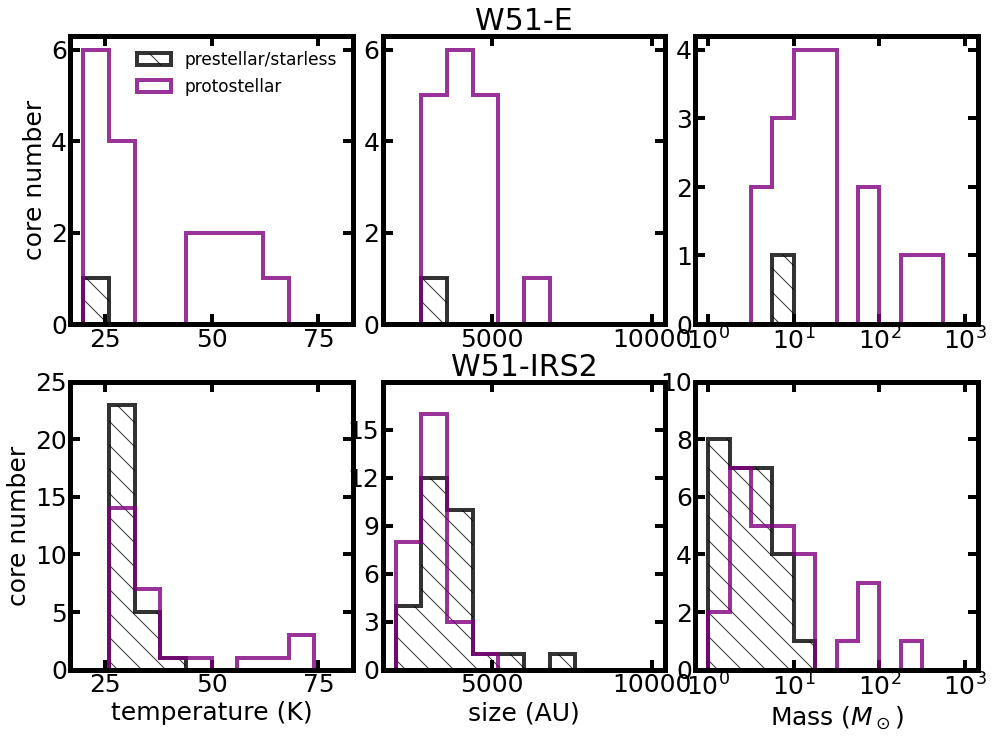

In [12]:
from scipy import stats

w51e_size_selected = np.array([size_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51n_size_selected = np.array([size_w51n[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51e_temp_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51n_temp_selected = np.array([temp_w51n[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51e_size_selected = np.array([size_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51n_size_selected = np.array([size_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
w51e_temp_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51n_temp_selected = np.array([temp_w51n[np.where(catdata_w51n_b6.no==ind)[0]][0] for ind in multiplicity_w51n_b3fov[3]])
prestellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])==0)[0]
protostellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])>0)[0]
prestellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])==0)[0]

protostellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])>0)[0]
protostellar_w51n2 = np.where((np.array(multiplicity_w51n_b3fov[4])>0)&(coremass_w51n_selected<30))[0]

print(prestellar_w51e,protostellar_w51e)
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_axes([0.08,0.07,0.28,0.4])
ax2 = fig.add_axes([0.39,0.07,0.28,0.4])
ax3 = fig.add_axes([0.7,0.07,0.28,0.4])
ax4 = fig.add_axes([0.08,0.55,0.28,0.4])
ax5 = fig.add_axes([0.39,0.55,0.28,0.4])
ax6 = fig.add_axes([0.7,0.55,0.28,0.4])
#ax7 = fig.add_axes([0.08,0.69,0.28,0.25])
#ax8 = fig.add_axes([0.39,0.69,0.28,0.25])
#ax9 = fig.add_axes([0.7,0.69,0.28,0.25])

fluxbins=np.logspace(-0.5,1,num=11)
print(np.array(w51e_b3fov_b6flux)[prestellar_w51e],np.array(w51e_b3fov_b6flux)[protostellar_w51e])
print(w51e_temp_selected[protostellar_w51e])
#ax1.hist(np.array(w51e_b3fov_b6flux)[prestellar_w51e],bins=fluxbins, alpha=0.8,  histtype='step', facecolor='none',edgecolor='k', hatch='\\',label='prestellar/starless',lw=4)
#ax1.hist(np.array(w51e_b3fov_b6flux)[protostellar_w51e],bins=fluxbins, alpha=0.8,histtype='step',facecolor='none',edgecolor='purple', label='protostellar',lw=4)
massbins=np.logspace(0,3,num=13)
sizebins=np.linspace(2000,10000,num=11)
tempbins=np.linspace(20,80,num=11)


ax3.hist(coremass_w51n_selected[prestellar_w51n],bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax3.hist(coremass_w51n_selected[protostellar_w51n],bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)
ax2.hist(w51n_size_selected[prestellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax2.hist(w51n_size_selected[protostellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax1.hist(w51n_temp_selected[prestellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax1.hist(w51n_temp_selected[protostellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

ax4.hist(w51e_temp_selected[prestellar_w51e],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax4.hist(w51e_temp_selected[protostellar_w51e],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax5.hist(w51e_size_selected[prestellar_w51e],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax5.hist(w51e_size_selected[protostellar_w51e],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax6.hist(coremass_w51e_selected[prestellar_w51e],bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax6.hist(coremass_w51e_selected[protostellar_w51e],bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)


coremass_prestellar_total = np.append(coremass_w51n_selected[prestellar_w51n], w51e_temp_selected[prestellar_w51e])
coremass_protostellar_total = np.append(coremass_w51n_selected[protostellar_w51n], w51e_temp_selected[protostellar_w51e])
size_prestellar_total = np.append(w51n_size_selected[prestellar_w51n], w51e_size_selected[prestellar_w51e])
size_protostellar_total = np.append(w51n_size_selected[protostellar_w51n], w51e_size_selected[protostellar_w51e])
temp_prestellar_total = np.append(w51n_temp_selected[prestellar_w51n], w51n_temp_selected[prestellar_w51e])
temp_protostellar_total = np.append(w51n_temp_selected[protostellar_w51n], w51e_temp_selected[protostellar_w51e])


print(stats.ks_2samp(coremass_w51n_selected[prestellar_w51n], coremass_w51n_selected[protostellar_w51n2]).pvalue,
      stats.ks_2samp(w51n_size_selected[prestellar_w51n], w51n_size_selected[protostellar_w51n]).pvalue,
      stats.ks_2samp(w51n_temp_selected[prestellar_w51n], w51n_temp_selected[protostellar_w51n]).pvalue)
#ax1.text(80*0.6, 25*0.8, 'p-value=%5.4f'%stats.ks_2samp(coremass_w51n_selected[prestellar_w51n], coremass_w51n_selected[protostellar_w51n]).pvalue,fontsize=17)
#ax2.text(10000*0.6, 18*0.8, 'p-value=%5.4f'%stats.ks_2samp(w51n_size_selected[prestellar_w51n], w51n_size_selected[protostellar_w51n]).pvalue,fontsize=17)
#ax3.text(10**1.5,10*0.8, 'p-value=%5.4f'%stats.ks_2samp(w51n_temp_selected[prestellar_w51n], w51n_temp_selected[protostellar_w51n]).pvalue,fontsize=17)


#ax9.hist(coremass_prestellar_total,bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
#ax9.hist(coremass_protostellar_total,bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)
#ax8.hist(size_prestellar_total,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
#ax8.hist(size_protostellar_total,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
#ax7.hist(temp_prestellar_total,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
#ax7.hist(temp_protostellar_total,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

#ax11.hist(w51n_temp_selected[prestellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
#ax11.hist(w51n_temp_selected[protostellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

#ax1.vlines(np.average(w51n_temp_selected[prestellar_w51n]),0,27, color='k', ls='dashed', lw=5)
#ax1.vlines(np.average(w51n_temp_selected[protostellar_w51n]),0,27, color='purple', ls='dashed', lw=5)
#ax2.vlines(np.average(w51n_size_selected[prestellar_w51n]),0,22, color='k', ls='dashed', lw=5)
#ax2.vlines(np.average(w51n_size_selected[protostellar_w51n]),0,22, color='purple', ls='dashed', lw=5)
#ax3.vlines(np.average(coremass_w51n_selected[prestellar_w51n]),0,11, color='k', ls='dashed', lw=5)
#ax3.vlines(np.average(coremass_w51n_selected[protostellar_w51n]),0,11, color='purple', ls='dashed', lw=5)
print('ho',np.average(coremass_w51n_selected[prestellar_w51n]),np.average(coremass_w51n_selected[protostellar_w51n2]))
ax1.set_ylim(0,25)
ax2.set_ylim(0,18)
ax3.set_ylim(0,10)
ax3.set_xlabel(r'Mass ($M_\odot$)')
ax2.set_xlabel('size (AU)')
ax1.set_xlabel('temperature (K)')
ax4.set_ylabel('core number')
ax1.set_ylabel('core number')

ax2.set_title('W51-IRS2',fontsize=30)
ax5.set_title('W51-E',fontsize=30)
#ax8.set_title('Total',fontsize=30)

ax3.set_xscale('log')
ax6.set_xscale('log')
#ax9.set_xscale('log')
ax3.set_xticks([1e0,1e1,1e2,1e3])
ax6.set_xticks([1e0,1e1,1e2,1e3])
#ax9.set_xticks([1e0,1e1,1e2,1e3])

ax4.legend(fontsize=17, frameon=False)
ax2.set_yticks([0,3,6,9,12,15])
#ax7.set_ylim(0,27)
#ax8.set_ylim(0,22)
#ax9.set_ylim(0,11)

plt.savefig('proto_vs_pre.pdf')
plt.savefig('proto_vs_pre.png')





In [ ]:
from scipy import stats

w51e_size_selected = np.array([size_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51n_size_selected = np.array([size_w51n[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51e_temp_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51n_temp_selected = np.array([temp_w51n[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51e_size_selected = np.array([size_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51n_size_selected = np.array([size_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
w51e_temp_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51n_temp_selected = np.array([temp_w51n[np.where(catdata_w51n_b6.no==ind)[0]][0] for ind in multiplicity_w51n_b3fov[3]])
prestellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])==0)[0]
protostellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])>0)[0]
prestellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])==0)[0]
protostellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])>0)[0]
print(prestellar_w51e,protostellar_w51e)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_axes([0.06,0.07,0.2,0.25])
ax2 = fig.add_axes([0.29,0.07,0.2,0.25])
ax3 = fig.add_axes([0.52,0.07,0.2,0.25])
ax11 = fig.add_axes([0.75,0.07,0.2,0.25])

ax4 = fig.add_axes([0.06,0.38,0.2,0.25])
ax5 = fig.add_axes([0.29,0.38,0.2,0.25])
ax6 = fig.add_axes([0.52,0.38,0.2,0.25])
ax22 = fig.add_axes([0.75,0.38,0.2,0.25])

ax7 = fig.add_axes([0.06,0.69,0.2,0.25])
ax8 = fig.add_axes([0.29,0.69,0.2,0.25])
ax9 = fig.add_axes([0.52,0.69,0.2,0.25])
ax33 = fig.add_axes([0.75,0.69,0.2,0.25])

fluxbins=np.logspace(-0.5,1,num=11)
print(np.array(w51e_b3fov_b6flux)[prestellar_w51e],np.array(w51e_b3fov_b6flux)[protostellar_w51e])
print(w51e_temp_selected[protostellar_w51e])
#ax1.hist(np.array(w51e_b3fov_b6flux)[prestellar_w51e],bins=fluxbins, alpha=0.8,  histtype='step', facecolor='none',edgecolor='k', hatch='\\',label='prestellar/starless',lw=4)
#ax1.hist(np.array(w51e_b3fov_b6flux)[protostellar_w51e],bins=fluxbins, alpha=0.8,histtype='step',facecolor='none',edgecolor='purple', label='protostellar',lw=4)
massbins=np.logspace(0,3,num=13)
sizebins=np.linspace(2000,10000,num=11)
tempbins=np.linspace(20,80,num=11)


ax3.hist(coremass_w51n_selected[prestellar_w51n],bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax3.hist(coremass_w51n_selected[protostellar_w51n],bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)
ax2.hist(w51n_size_selected[prestellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax2.hist(w51n_size_selected[protostellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax1.hist(w51n_temp_selected[prestellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax1.hist(w51n_temp_selected[protostellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

ax4.hist(w51e_temp_selected[prestellar_w51e],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax4.hist(w51e_temp_selected[protostellar_w51e],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax5.hist(w51e_size_selected[prestellar_w51e],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax5.hist(w51e_size_selected[protostellar_w51e],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax6.hist(coremass_w51e_selected[prestellar_w51e],bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax6.hist(coremass_w51e_selected[protostellar_w51e],bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)

coremass_prestellar_total = np.append(coremass_w51n_selected[prestellar_w51n], w51e_temp_selected[prestellar_w51e])
coremass_protostellar_total = np.append(coremass_w51n_selected[protostellar_w51n], w51e_temp_selected[protostellar_w51e])
size_prestellar_total = np.append(w51n_size_selected[prestellar_w51n], w51e_size_selected[prestellar_w51e])
size_protostellar_total = np.append(w51n_size_selected[protostellar_w51n], w51e_size_selected[protostellar_w51e])
temp_prestellar_total = np.append(w51n_temp_selected[prestellar_w51n], w51n_temp_selected[prestellar_w51e])
temp_protostellar_total = np.append(w51n_temp_selected[protostellar_w51n], w51e_temp_selected[protostellar_w51e])
print(stats.ks_2samp(coremass_prestellar_total, coremass_protostellar_total).pvalue,
      stats.ks_2samp(size_prestellar_total, size_protostellar_total).pvalue,
      stats.ks_2samp(temp_prestellar_total, temp_protostellar_total).pvalue)
ax7.text(37, 23, 'p-value=%6.1e'%stats.ks_2samp(coremass_prestellar_total, coremass_protostellar_total).pvalue,fontsize=20)
ax8.text(4000, 19, 'p-value=%6.1e'%stats.ks_2samp(size_prestellar_total, size_protostellar_total).pvalue,fontsize=20)
ax9.text(10,9.5, 'p-value=%6.1e'%stats.ks_2samp(temp_prestellar_total, temp_protostellar_total).pvalue,fontsize=20)


ax9.hist(coremass_prestellar_total,bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax9.hist(coremass_protostellar_total,bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)
print(coremass_prestellar_total,coremass_protostellar_total)
ax8.hist(size_prestellar_total,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax8.hist(size_protostellar_total,bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax7.hist(temp_prestellar_total,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax7.hist(temp_protostellar_total,bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax7.vlines(np.average(temp_prestellar_total),0,27, color='k', ls='dashed', lw=5)
ax7.vlines(np.average(temp_protostellar_total),0,27, color='purple', ls='dashed', lw=5)
ax8.vlines(np.average(size_prestellar_total),0,22, color='k', ls='dashed', lw=5)
ax8.vlines(np.average(size_protostellar_total),0,22, color='purple', ls='dashed', lw=5)
ax9.vlines(np.average(coremass_prestellar_total),0,11, color='k', ls='dashed', lw=5)
ax9.vlines(np.average(coremass_protostellar_total),0,11, color='purple', ls='dashed', lw=5)

core_density_w51n_prestellar = (coremass_w51n_selected[prestellar_w51n]*u.Msun/(4/3*np.pi*2.82*c.u*(w51n_size_selected[prestellar_w51n]*u.au)**3)).to(1/u.cm**3)
core_density_w51e_prestellar = (coremass_w51e_selected[prestellar_w51e]*u.Msun/(4/3*np.pi*2.82*c.u*(w51e_size_selected[prestellar_w51e]*u.au)**3)).to(1/u.cm**3)
core_density_w51n_protostellar = (coremass_w51n_selected[protostellar_w51n]*u.Msun/(4/3*np.pi*2.82*c.u*(w51n_size_selected[protostellar_w51n]*u.au)**3)).to(1/u.cm**3)
core_density_w51e_protostellar = (coremass_w51e_selected[protostellar_w51e]*u.Msun/(4/3*np.pi*2.82*c.u*(w51e_size_selected[protostellar_w51e]*u.au)**3)).to(1/u.cm**3)
core_density_total_prestellar = (coremass_prestellar_total*u.Msun/(4/3*np.pi*2.82*c.u*(size_prestellar_total*u.au)**3)).to(1/u.cm**3)
core_density_total_protostellar = (coremass_protostellar_total*u.Msun/(4/3*np.pi*2.82*c.u*(size_protostellar_total*u.au)**3)).to(1/u.cm**3)

denbins = np.logspace(5,9,21)
ax11.hist(core_density_w51n_prestellar.value,bins=denbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax11.hist(core_density_w51n_protostellar.value,bins=denbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax22.hist(core_density_w51e_prestellar.value,bins=denbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax22.hist(core_density_w51e_protostellar.value,bins=denbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
ax33.hist(core_density_total_prestellar.value,bins=denbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax33.hist(core_density_total_protostellar.value,bins=denbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

ax3.set_xlabel(r'Mass ($M_\odot$)')
ax2.set_xlabel('size (AU)')
ax1.set_xlabel('temperature (K)')
ax4.set_ylabel('core number',fontsize=30)
ax2.set_title('W51-IRS2',fontsize=30)
ax5.set_title('W51-E',fontsize=30)
ax8.set_title('Total',fontsize=30)
ax11.set_xlabel('$H_2$ number density ($cm^{-3}$)')

ax3.set_xscale('log')
ax6.set_xscale('log')
ax9.set_xscale('log')
ax3.set_xticks([1e0,1e1,1e2,1e3])
ax6.set_xticks([1e0,1e1,1e2,1e3])
ax9.set_xticks([1e0,1e1,1e2,1e3])

ax4.legend(fontsize=20, frameon=False)
ax2.set_yticks([0,3,6,9,12,15])
ax7.set_ylim(0,27)
ax8.set_ylim(0,22)
ax9.set_ylim(0,11)

ax11.set_xscale('log')
ax22.set_xscale('log')
ax33.set_xscale('log')

#plt.savefig('proto_vs_pre.pdf')
#plt.savefig('proto_vs_pre.png')





### protostellar vs prestellar (w51n)


In [ ]:
w51e_size_selected = np.array([size_w51e[np.where(catdata_w51e_b6.no==ind)[0]].value[0] for ind in multiplicity_w51e_b3fov[3]])
w51n_size_selected = np.array([size_w51n[np.where(catdata_w51n_b6.no==ind)[0]].value[0] for ind in multiplicity_w51n_b3fov[3]])
w51e_temp_selected = np.array([temp_w51e[np.where(catdata_w51e_b6.no==ind)[0]][0] for ind in multiplicity_w51e_b3fov[3]])
w51n_temp_selected = np.array([temp_w51n[np.where(catdata_w51n_b6.no==ind)[0]][0] for ind in multiplicity_w51n_b3fov[3]])

prestellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])==0)[0]
protostellar_w51e = np.where(np.array(multiplicity_w51e_b3fov[4])>0)[0]
prestellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])==0)[0]
protostellar_w51n = np.where(np.array(multiplicity_w51n_b3fov[4])>0)[0]
print(prestellar_w51e,protostellar_w51e)
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.08,0.08,0.4,0.4])
ax2 = fig.add_axes([0.56,0.08,0.4,0.4])
ax3 = fig.add_axes([0.08,0.56,0.4,0.4])
ax4 = fig.add_axes([0.56,0.56,0.4,0.4])
fluxbins=np.logspace(-3,1,num=11)
print(w51n_temp_selected[prestellar_w51n],w51n_temp_selected[protostellar_w51n])
ax1.hist(np.array(w51n_b3fov_b6flux)[prestellar_w51n],bins=fluxbins, alpha=0.8,  histtype='step', facecolor='none',edgecolor='k', hatch='\\',label='prestellar/starless',lw=4)
ax1.hist(np.array(w51n_b3fov_b6flux)[protostellar_w51n],bins=fluxbins, alpha=0.8,histtype='step',facecolor='none',edgecolor='purple', label='protostellar',lw=4)
massbins=np.logspace(-0.5,3,num=11)
ax2.hist(coremass_w51n_selected[prestellar_w51n],bins=massbins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax2.hist(coremass_w51n_selected[protostellar_w51n],bins=massbins, alpha=0.8, histtype='step',facecolor='none', color='purple', label='protostellar',lw=4)
sizebins=np.linspace(2000,10000,num=11)
ax3.hist(w51n_size_selected[prestellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='k', hatch='\\',label='prestellar/starless',lw=4)
ax3.hist(w51n_size_selected[protostellar_w51n],bins=sizebins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)
tempbins=np.linspace(20,80,num=11)
ax4.hist(w51n_temp_selected[prestellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='k',  hatch='\\',label='prestellar/starless',lw=4)
ax4.hist(w51n_temp_selected[protostellar_w51n],bins=tempbins, alpha=0.8,histtype='step', facecolor='none', color='purple', label='protostellar',lw=4)

ax1.set_xlabel('Band 6 flux (Jy)')
ax2.set_xlabel(r'Mass ($M_\odot$)')
ax3.set_xlabel('size (AU)')
ax4.set_xlabel('temperature (K)')
ax1.set_ylabel('core number')
ax2.set_ylabel('core number')
ax3.set_ylabel('core number')
ax4.set_ylabel('core number')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.legend(fontsize=15)
plt.savefig('w51n_proto_vs_pre.png')

### w51e (Fov)

In [ ]:
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
catdata_w51n = ascii.read(cat_w51e,data_start=0,format='commented_header', header_start=120,  comment="!")
sky_ra = catdata_w51n['WCS_ACOOR']
sky_dec = catdata_w51n['WCS_DCOOR']
pix_x = catdata_w51n['XCO_P']
pix_y = catdata_w51n['YCO_P']

afwhm_b6 = catdata_w51n['AFWHM02']
bfwhm_b6 = catdata_w51n['BFWHM02']

asize_b6 = catdata_w51n['ASIZE02']
bsize_b6 = catdata_w51n['BSIZE02']

theta_b6 = catdata_w51n['THETA02']

afwhm_b3 = catdata_w51n['AFWHM03']
bfwhm_b3 = catdata_w51n['BFWHM03']

asize_b3 = catdata_w51n['ASIZE03']
bsize_b3 = catdata_w51n['BSIZE03']

theta_b3 = catdata_w51n['THETA03']

no = catdata_w51n['NO']

rec_ind_b3 = np.where((np.abs(catdata_w51n['GOODM03'])>1)&
                   (np.abs(catdata_w51n['SIGNM03'])>1)&
                   (catdata_w51n['FXP_BST03']/catdata_w51n['FXP_ERR03']>2)&
                   (catdata_w51n['FXT_BST03']/catdata_w51n['FXT_ERR03']>2)&
                   (catdata_w51n['AFWHM03']/catdata_w51n['BFWHM03']<2)&
                   (catdata_w51n['FOOA03']/catdata_w51n['AFWHM03']>1.15))[0]

rec_ind_b6 = np.where((np.abs(catdata_w51n['GOODM02'])>1)&
                   (np.abs(catdata_w51n['SIGNM02'])>1)&
                   (catdata_w51n['FXP_BST02']/catdata_w51n['FXP_ERR02']>2)&
                   (catdata_w51n['FXT_BST02']/catdata_w51n['FXT_ERR02']>2)&
                   (catdata_w51n['AFWHM02']/catdata_w51n['BFWHM02']<2)&
                   (catdata_w51n['FOOA02']/catdata_w51n['AFWHM02']>1.15))[0]
print(rec_ind_b3)
print(rec_ind_b6)



skypos = np.vstack((sky_ra,sky_dec)).T


manualindex =[1,6,3,5,8,68]
manualindex =[0,5,2,4,7,67]
catalogdir = '/orange/adamginsburg/ALMA_IMF/catalogs/getsf-smoothed/'
cat_w51e = catalogdir + 'W51-E-getsf.cat'
Path.w51n_almaimf_catalog = catalogdir + 'W51-IRS2-getsf.cat'

fitsdata = fits.open(w51e_b6_calibrated_pbcor)
b6highresimage = fitsdata[0].data[0][0]
hdrNBb6 = fits.getheader(w51e_b6_calibrated_pbcor)
wcsNBb6 = WCS(hdrNBb6,naxis=2)
xysky = np.vstack((sky_ra, sky_dec)).T
pixxy_b6 = wcsNBb6.wcs_world2pix(xysky,0)

ind_inside_b6image = count_source_in_image(b6highresimage, pixxy_b6[:,0], pixxy_b6[:,1])
print('hoh',len(ind_inside_b6image))
hdrNBalmaimf = fits.getheader(w51e_b3_almaimf)  
wcsNBalmaimf = WCS(hdrNBalmaimf,naxis=2)
beamalmaimf = Beam.from_fits_header(hdrNBalmaimf)  

fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
catalog = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51e_matched.fits',format='fits')
xsky = catalog['b6_xsky'] ; ysky = catalog['b6_ysky']
negativeind = np.where(xsky<0)
xsky[negativeind] = catalog['b3_xsky'][negativeind] 
ysky[negativeind] = catalog['b3_ysky'][negativeind] 

xysource_sky= np.vstack((xsky, ysky)).T
fitsdata = fits.open(w51e2_b3_tt0)
hdrNB = fits.getheader(w51e2_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 
xysource = wcsNB.wcs_world2pix(xysource_sky,0)

#skylim1 = wcsNB.pixel_to_world(6500,6750)
#skylim2 = wcsNB.pixel_to_world(6500+0.35/scaleNB_phy.value,6750+0.2/scaleNB_phy.value)
#print('ho',skylim1)
#print(skylim1[0])
#limitarea = [float(skylim1),float(skylim1[1]),float(skylim2[0]),float(skylim2[1])]
ind = multiplicity(ax1,hdrNB,cat_w51e,xysource,isb3=True,beam=beamalmaimf,use_criteria=False, label=ind_inside_b6image
                          ,color='cyan',lw=2,legendlabel='B3',return_nonzero_ind=True)
print(ind)
hdrNBalmaimf = fits.getheader(w51n_b6_almaimf)  
wcsNBalmaimf = WCS(hdrNBalmaimf,naxis=2)
beamalmaimf = Beam.from_fits_header(hdrNBalmaimf)  

ind = multiplicity(ax1,hdrNB,cat_w51e,xysource,isb3=False,beam=beamalmaimf,use_criteria=False
                          ,color='cyan',lw=2,hatch='\\',histcolor='orange',legendlabel='B6',label=ind_inside_b6image,return_nonzero_ind=True)
ax1.legend()
print(ind)

### w51e (FoV + recommended criteria)

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
#catalog = Table.read('../spectral_index/w51e_combined_catalog.fits',format='fits')
#xysource = np.vstack((catalog['x_pix'],catalog['y_pix'])).T
fitsdata = fits.open(w51e2_b3_tt0)
hdrNB = fits.getheader(w51e2_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 

#skylim1 = wcsNB.pixel_to_world(6500,6750)
#skylim2 = wcsNB.pixel_to_world(6500+0.35/scaleNB_phy.value,6750+0.2/scaleNB_phy.value)
#print('ho',skylim1)
#print(skylim1[0])
#limitarea = [float(skylim1),float(skylim1[1]),float(skylim2[0]),float(skylim2[1])]
ind = multiplicity(ax1,hdrNB,cat_w51e,xysource,isb3=True,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
                          ,color='cyan',lw=2,legendlabel='B3',return_nonzero_ind=True)
print(ind)
hdrNBalmaimf = fits.getheader(w51n_b6_almaimf)  
wcsNBalmaimf = WCS(hdrNBalmaimf,naxis=2)
beamalmaimf = Beam.from_fits_header(hdrNBalmaimf)  

ind = multiplicity(ax1,hdrNB,cat_w51e,xysource,isb3=False,beam=beamalmaimf,use_criteria=True
                          ,color='cyan',lw=2,hatch='\\',histcolor='orange',legendlabel='B6',label=ind_inside_b6image,return_nonzero_ind=True)
ax1.legend()
print(ind)

In [ ]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
plt.style.use('dark_background')
mpl.rcParams['xtick.major.size'] = 25
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 15
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 25
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 15
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth']=5


        
fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
catalog = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51e_matched.fits',format='fits')
xsky = catalog['b6_xsky'] ; ysky = catalog['b6_ysky']
negativeind = np.where(xsky<0)
xsky[negativeind] = catalog['b3_xsky'][negativeind] 
ysky[negativeind] = catalog['b3_ysky'][negativeind] 

xysky= np.vstack((xsky, ysky)).T

fitsdata = fits.open(w51e2_b3_tt0)
hdrNB = fits.getheader(w51e2_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 


fitsdata = fits.open(w51e_b6_calibrated_pbcor)
b6highresimage = fitsdata[0].data[0][0]
hdrNBb6 = fits.getheader(w51e_b6_calibrated_pbcor)
wcsNBb6 = WCS(hdrNBb6,naxis=2)
xysource = wcsNBb6.wcs_world2pix(xysky,0)

almaimfcatalog = catdata(cat_w51e)
xysky = np.vstack((almaimfcatalog.sky_ra, almaimfcatalog.sky_dec)).T
pixxy_b6 = wcsNBb6.wcs_world2pix(xysky,0)
ind_inside_b6image = count_source_in_image(b6highresimage, pixxy_b6[:,0], pixxy_b6[:,1])

ind = multiplicity(ax1,hdrNBb6,cat_w51e,xysource,isb3=True,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
                          ,histcolor='orange',lw=5,legendlabel='W51e Band 3',return_nonzero_ind=True)

ind = multiplicity(ax1,hdrNBb6,cat_w51e,xysource,isb3=False,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
                          ,histcolor='orange',lw=5,legendlabel='W51e Band 6',return_nonzero_ind=True,hatch='\\')



catalog = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_matched.fits',format='fits')
xsky = catalog['b6_xsky'] ; ysky = catalog['b6_ysky']
negativeind = np.where(xsky<0)
xsky[negativeind] = catalog['b3_xsky'][negativeind] 
ysky[negativeind] = catalog['b3_ysky'][negativeind] 

xysky= np.vstack((xsky, ysky)).T

fitsdata = fits.open(w51n_b3_tt0)
hdrNB = fits.getheader(w51n_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 


fitsdata = fits.open(w51n_b6_calibrated_pbcor)
b6highresimage = fitsdata[0].data[0][0]
hdrNBb6 = fits.getheader(w51n_b6_calibrated_pbcor)
wcsNBb6 = WCS(hdrNBb6,naxis=2)
xysource = wcsNBb6.wcs_world2pix(xysky,0)

almaimfcatalog = catdata(Path.w51n_almaimf_catalog)
xysky = np.vstack((almaimfcatalog.sky_ra, almaimfcatalog.sky_dec)).T
pixxy_b6 = wcsNBb6.wcs_world2pix(xysky,0)
ind_inside_b6image = count_source_in_image(b6highresimage, pixxy_b6[:,0], pixxy_b6[:,1])



ind = multiplicity(ax1,hdrNBb6,Path.w51n_almaimf_catalog,xysource,isb3=True,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
                         ,lw=5,legendlabel='W51n Band 3',return_nonzero_ind=True, histcolor='cyan',hatch='o')

ind = multiplicity(ax1,hdrNBb6,Path.w51n_almaimf_catalog,xysource,isb3=False,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
                          ,lw=5,legendlabel='W51n Band 6',return_nonzero_ind=True,histcolor='cyan',hatch='..')

plt.legend(fontsize=25)


In [ ]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
plt.style.use('dark_background')
mpl.rcParams['xtick.major.size'] = 25
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 15
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 25
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 15
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth']=5


fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
catalog = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51e_matched.fits',format='fits')
xsky = catalog['b6_xsky'] ; ysky = catalog['b6_ysky']
negativeind = np.where(xsky<0)
xsky[negativeind] = catalog['b3_xsky'][negativeind] 
ysky[negativeind] = catalog['b3_ysky'][negativeind] 
xysky= np.vstack((xsky, ysky)).T

#xysky = np.vstack((catalog['x_sky'],catalog['y_sky'])).T
fitsdata = fits.open(w51e2_b3_tt0)
hdrNB = fits.getheader(w51e2_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 


fitsdata = fits.open(w51e_b6_calibrated_pbcor)
b6highresimage = fitsdata[0].data[0][0]
hdrNBb6 = fits.getheader(w51e_b6_calibrated_pbcor)
wcsNBb6 = WCS(hdrNBb6,naxis=2)
xysource = wcsNBb6.wcs_world2pix(xysky,0)

almaimfcatalog = catdata(cat_w51e)
xysky = np.vstack((almaimfcatalog.sky_ra, almaimfcatalog.sky_dec)).T
pixxy_b6 = wcsNBb6.wcs_world2pix(xysky,0)
ind_inside_b6image = count_source_in_image(b6highresimage, pixxy_b6[:,0], pixxy_b6[:,1])

#ind = multiplicity(ax1,hdrNB,cat_w51e,xysource,isb3=True,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
#                          ,histcolor='orange',lw=5,legendlabel='W51e Band 3',return_nonzero_ind=True)
hdrNBalmaimf = fits.getheader(w51e_b6_almaimf)  
wcsNBalmaimf = WCS(hdrNBalmaimf,naxis=2)
beamalmaimf = Beam.from_fits_header(hdrNBalmaimf)  


ind_w51e_almaimf = multiplicity(ax1,hdrNBb6,cat_w51e,xysource,isb3=False,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
                          ,histcolor='cyan',lw=5,legendlabel='W51-E',return_nonzero_ind=True)

#w51e_almaimf_fragments = ind[3]
catalog = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_matched.fits',format='fits')
xsky = catalog['b6_xsky'] ; ysky = catalog['b6_ysky']
negativeind = np.where(xsky<0)
xsky[negativeind] = catalog['b3_xsky'][negativeind] 
ysky[negativeind] = catalog['b3_ysky'][negativeind] 
xysky= np.vstack((xsky, ysky)).T

fitsdata = fits.open(w51n_b3_tt0)
hdrNB = fits.getheader(w51n_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 


fitsdata = fits.open(w51n_b6_calibrated_pbcor)
b6highresimage = fitsdata[0].data[0][0]
hdrNBb6 = fits.getheader(w51n_b6_calibrated_pbcor)
wcsNBb6 = WCS(hdrNBb6,naxis=2)
xysource = wcsNBb6.wcs_world2pix(xysky,0)

almaimfcatalog = catdata(Path.w51n_almaimf_catalog)
xysky = np.vstack((almaimfcatalog.sky_ra, almaimfcatalog.sky_dec)).T
pixxy_b6 = wcsNBb6.wcs_world2pix(xysky,0)
ind_inside_b6image = count_source_in_image(b6highresimage, pixxy_b6[:,0], pixxy_b6[:,1])

hdrNBalmaimf = fits.getheader(w51n_b6_almaimf)  
wcsNBalmaimf = WCS(hdrNBalmaimf,naxis=2)
beamalmaimf = Beam.from_fits_header(hdrNBalmaimf)  


#ind = multiplicity(ax1,hdrNB,Path.w51n_almaimf_catalog,xysource,isb3=True,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
#                         ,lw=5,legendlabel='W51n Band 3',return_nonzero_ind=True, histcolor='cyan',hatch='o')

ind_w51n_almaimf = multiplicity(ax1,hdrNBb6,Path.w51n_almaimf_catalog,xysource,isb3=False,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
                          ,lw=5,legendlabel='W51-IRS2',return_nonzero_ind=True,histcolor='orange',hatch='\\')
#w51n_almaimf_fragments = ind[3]

ax1.set_xlabel('# of YSOs per each ALMA-IMF core (1mm)')
ax1.set_ylabel('# of ALMA-IMF cores')
ax1.tick_params(axis="y",direction='in')
ax1.tick_params(axis="x",direction='in')
plt.legend(fontsize=25)


In [ ]:
from astropy.coordinates import SkyCoord

def get_flux_from_almaimf(cat_w51e, ind_w51e_almaimf):
    w51e_almaimf_cat = catdata(cat_w51e, band='B6')
    w51e_almaimf_fragment_ind = ind_w51e_almaimf[3]
    fluxarr=[] ; fluxerrarr =[] ;xarr=[] ; yarr=[]
    for i in range(len(w51e_almaimf_fragment_ind)):
        matchind = np.where(w51e_almaimf_cat.no==w51e_almaimf_fragment_ind[i])[0]
        fluxarr.append(w51e_almaimf_cat.flux[matchind].value.item())
        fluxerrarr.append(w51e_almaimf_cat.fluxerr[matchind].value.item())
        #ra = w51e_almaimf_cat.sky_ra[matchind]
        #dec = w51e_almaimf_cat.sky_dec[matchind]
        #sky = np.vstack((ra,dec)).T
        #xypix = wcs.world_to_pixel(SkyCoord(ra,dec, unit='deg'))
        
        #xarr.append(xypix[0])
        #yarr.append(xypix[1])
        #xarr.append(w51e_almaimf_cat.pix_x[i])
        #yarr.append(w51e_almaimf_cat.pix_y[i])
    print('ho',fluxarr, fluxerrarr)
    
    #return fluxarr, fluxerrarr,xarr,yarr
    return fluxarr, fluxerrarr
#hdrNB = fits.getheader(w51e_b6_almaimf)  
#wcs_w51e_b6_almaimf= WCS(hdrNB,naxis=2)
w51e_flux, w51e_fluxerr = get_flux_from_almaimf(cat_w51e, ind_w51e_almaimf)
#hdrNB = fits.getheader(w51n_b6_almaimf)  
#wcs_w51n_b6_almaimf= WCS(hdrNB,naxis=2)
w51n_flux, w51n_fluxerr = get_flux_from_almaimf(Path.w51n_almaimf_catalog, ind_w51n_almaimf)
for i in range(len(w51e_flux)):
    print(w51e_flux[i], w51e_fluxerr[i], w51e_xarr[i], w51e_yarr[i], ind_w51e_almaimf[4][i])

fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
ax1.errorbar(w51e_flux, ind_w51e_almaimf[4], xerr=w51e_fluxerr,label='w51-E',marker='o',fmt='.',c='cyan')
ax1.errorbar(w51n_flux, ind_w51n_almaimf[4], xerr=w51n_fluxerr,label='w51-North',marker='o',fmt='.',c='orange')
ax1.set_ylabel('# of fragments')
ax1.set_xlabel(r'ALMA-IMF flux (Jy)')
ax1.set_xscale('log')
ax1.set_yticks([0,2,4,6,8])
#ax2 = ax1.twinx()
#ax1.set_ylim(ylim1, ylim2)
#ax2.set_ylim(0.001,10)
#ax2.set_yscale('log')
#new_tick_locations = [1e-3,1e-2,1e-1,1,10]
#ax2.set_yticks(new_tick_locations)
#ax2.set_ylabel('flux (Jy)')
ax1.tick_params(axis="y",direction='in')
ax1.tick_params(axis="x",direction='in')
#ax2.tick_params(axis="y",direction='in')
#ax2.tick_params(axis="x",direction='in')
ax1.tick_params(axis="y",direction='in',which='minor')
ax1.tick_params(axis="x",direction='in',which='minor')
#ax2.tick_params(axis="y",direction='in',which='minor')
#ax2.tick_params(axis="x",direction='in',which='minor')
ax1.legend(frameon=False,fontsize=20)
#ax1.set_xlim(1e-4, 10)
#ax1.set_ylim(-1,9)

In [ ]:

fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
catalog = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51e_matched.fits',format='fits')
xsky = catalog['b6_xsky'] ; ysky = catalog['b6_ysky']
negativeind = np.where(xsky<0)
xsky[negativeind] = catalog['b3_xsky'][negativeind] 
ysky[negativeind] = catalog['b3_ysky'][negativeind] 
xysky= np.vstack((xsky, ysky)).T

#xysky = np.vstack((catalog['x_sky'],catalog['y_sky'])).T
fitsdata = fits.open(w51e2_b3_tt0)
hdrNB = fits.getheader(w51e2_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 


fitsdata = fits.open(w51e_b6_calibrated_pbcor)
b6highresimage = fitsdata[0].data[0][0]
hdrNBb6 = fits.getheader(w51e_b6_calibrated_pbcor)
wcsNBb6 = WCS(hdrNBb6,naxis=2)
xysource = wcsNBb6.wcs_world2pix(xysky,0)

almaimfcatalog = catdata(cat_w51e)
xysky = np.vstack((almaimfcatalog.sky_ra, almaimfcatalog.sky_dec)).T
pixxy_b6 = wcsNBb6.wcs_world2pix(xysky,0)
ind_inside_b6image = count_source_in_image(b6highresimage, pixxy_b6[:,0], pixxy_b6[:,1])

#ind = multiplicity(ax1,hdrNB,cat_w51e,xysource,isb3=True,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
#                          ,histcolor='orange',lw=5,legendlabel='W51e Band 3',return_nonzero_ind=True)
hdrNBalmaimf = fits.getheader(w51e_b6_almaimf)  
wcsNBalmaimf = WCS(hdrNBalmaimf,naxis=2)
beamalmaimf = Beam.from_fits_header(hdrNBalmaimf)  


ind_w51e_almaimf = multiplicity(ax1,hdrNBb6,cat_w51e,xysource,isb3=False,beam=beamalmaimf,use_criteria=True 
                          ,histcolor='cyan',lw=5,legendlabel='W51-E',return_nonzero_ind=True)

#w51e_almaimf_fragments = ind[3]
catalog = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_matched.fits',format='fits')
xsky = catalog['b6_xsky'] ; ysky = catalog['b6_ysky']
negativeind = np.where(xsky<0)
xsky[negativeind] = catalog['b3_xsky'][negativeind] 
ysky[negativeind] = catalog['b3_ysky'][negativeind] 
xysky= np.vstack((xsky, ysky)).T

fitsdata = fits.open(w51n_b3_tt0)
hdrNB = fits.getheader(w51n_b3_tt0)  
wcsNB = WCS(hdrNB,naxis=2)
scaleNB = wcsNB.proj_plane_pixel_scales()[0]
scaleNB_phy = scaleNB * np.pi / 180 * 5.41e3 


fitsdata = fits.open(w51n_b6_calibrated_pbcor)
b6highresimage = fitsdata[0].data[0][0]
hdrNBb6 = fits.getheader(w51n_b6_calibrated_pbcor)
wcsNBb6 = WCS(hdrNBb6,naxis=2)
xysource = wcsNBb6.wcs_world2pix(xysky,0)

almaimfcatalog = catdata(Path.w51n_almaimf_catalog)
xysky = np.vstack((almaimfcatalog.sky_ra, almaimfcatalog.sky_dec)).T
pixxy_b6 = wcsNBb6.wcs_world2pix(xysky,0)
ind_inside_b6image = count_source_in_image(b6highresimage, pixxy_b6[:,0], pixxy_b6[:,1])

hdrNBalmaimf = fits.getheader(w51n_b6_almaimf)  
wcsNBalmaimf = WCS(hdrNBalmaimf,naxis=2)
beamalmaimf = Beam.from_fits_header(hdrNBalmaimf)  


#ind = multiplicity(ax1,hdrNB,Path.w51n_almaimf_catalog,xysource,isb3=True,beam=beamalmaimf,use_criteria=True, label=ind_inside_b6image
#                         ,lw=5,legendlabel='W51n Band 3',return_nonzero_ind=True, histcolor='cyan',hatch='o')

ind_w51n_almaimf = multiplicity(ax1,hdrNBb6,Path.w51n_almaimf_catalog,xysource,isb3=False,beam=beamalmaimf,use_criteria=True, 
                          lw=5,legendlabel='W51-IRS2',return_nonzero_ind=True,histcolor='orange',hatch='\\')
#w51n_almaimf_fragments = ind[3]

ax1.set_xlabel('# of YSOs per each ALMA-IMF core (1mm)')
ax1.set_ylabel('# of ALMA-IMF cores')
ax1.tick_params(axis="y",direction='in')
ax1.tick_params(axis="x",direction='in')
plt.legend(fontsize=25)



In [ ]:
w51e_flux, w51e_fluxerr = get_flux_from_almaimf(cat_w51e, ind_w51e_almaimf)
w51n_flux, w51n_fluxerr = get_flux_from_almaimf(Path.w51n_almaimf_catalog, ind_w51n_almaimf)
print(w51e_flux, w51e_fluxerr)
print(len(w51n_flux), len(ind_w51n_almaimf[0]),len(ind_w51n_almaimf[3]),len(ind_w51n_almaimf[3]))

fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
ax1.errorbar(w51e_flux, ind_w51e_almaimf[4], xerr=w51e_fluxerr,label='w51-E',marker='o',fmt='.',c='cyan')
ax1.errorbar(w51n_flux, ind_w51n_almaimf[4], xerr=w51n_fluxerr,label='w51-North',marker='o',fmt='.',c='orange')
ax1.set_ylabel('# of fragments')
ax1.set_xlabel(r'ALMA-IMF flux (Jy)')
ax1.set_xscale('log')
ax1.set_yticks([0,2,4,6,8])
#ax2 = ax1.twinx()
#ax1.set_ylim(ylim1, ylim2)
#ax2.set_ylim(0.001,10)
#ax2.set_yscale('log')
#new_tick_locations = [1e-3,1e-2,1e-1,1,10]
#ax2.set_yticks(new_tick_locations)
#ax2.set_ylabel('flux (Jy)')
ax1.tick_params(axis="y",direction='in')
ax1.tick_params(axis="x",direction='in')
#ax2.tick_params(axis="y",direction='in')
#ax2.tick_params(axis="x",direction='in')
ax1.tick_params(axis="y",direction='in',which='minor')
ax1.tick_params(axis="x",direction='in',which='minor')
#ax2.tick_params(axis="y",direction='in',which='minor')
#ax2.tick_params(axis="x",direction='in',which='minor')
ax1.legend(frameon=False,fontsize=20)
ax1.set_ylim(-1,9)

In [ ]:
### w51 b6 (b6 detections only)

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])

multiplicity(ax1,w51n_b6_almaimf, w51n_b6_briggs,catdata_w51n, '/home/t.yoo/w51/catalogue/alpha/w51n_b6_catalog.fits',band='B6')
             




In [ ]:
fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])

multiplicity(ax1,w51n_b6_almaimf, w51n_b6_briggs,catdata_w51n, '/home/t.yoo/w51/catalogue/alpha/w51n_combined_catalog.fits')
             
